# 1) Importing libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec

In [2]:
#Always seed the randomness of this universer
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2) Reading train_metadata_kaggle & test_metadata_kaggle

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('klm_train.csv')
test_metadata_kaggle = dd.read_csv('klm_test.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 64) (3492890, 63)
CPU times: user 1min 40s, sys: 6.16 s, total: 1min 46s
Wall time: 18.4 s


In [5]:
test_id = test_metadata_kaggle['object_id']

In [6]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 64) (3492890, 63)


In [7]:
train_metadata_kaggle.head()

object_id     flux_min    flux_max   flux_mean  flux_median    flux_std  \
0        615 -1100.440063  660.626343 -123.096998   -89.477524  394.109851   
1        713   -14.735178   14.770886   -1.423351    -0.873033    6.471144   
2        730   -19.159811   47.310059    2.267434     0.409172    8.022239   
3        745   -15.494463  220.795212    8.909206     1.035895   27.558208   
4       1124   -16.543753  143.600189    7.145702     1.141288   20.051722   

   flux_skew  flux_err_min  flux_err_max  flux_err_mean  flux_err_median  \
0  -0.349540      2.130510     12.845472       4.482743         3.835268   
1   0.014989      0.639458      9.115748       2.359620         1.998217   
2   3.177854      0.695106     11.281384       2.471061         1.990851   
3   4.979826      0.567170     55.892746       2.555576         1.819875   
4   4.406298      0.695277     11.383690       2.753004         2.214854   

   flux_err_std  flux_err_skew  detected_mean  flux_ratio_sq_sum  \
0      1.744747       1.623740       0.946023       2.929669e+06   
1      1.509888       1.633246       0.171429       5.886068e+03   
2      1.721134       1.823726       0.069697       4.124452e+03   
3      3.537324      10.741655       0.173789       9.416165e+04   
4      1.933837       1.794938       0.173295       3.432418e+04   

   flux_ratio_sq_skew  flux_by_flux_ratio_sq_sum  flux_by_flux_ratio_sq_skew  \
0            0.812722              -9.601766e+08                   -1.414322   
1            3.439423              -2.875087e+04                   -3.454554   
2            5.480405               1.046502e+05                    5.989138   
3            9.611274               1.439125e+07                   11.141069   
4            7.868462               3.015599e+06                    7.908174   

   flux_w_mean   flux_diff1  flux_diff2  flux_diff3  \
0  -327.742307  1761.066406  -14.306331   -5.373326   
1    -4.884564    29.506064  -20.730002   -6.040676   
2    25.373110    66.469870   29.315018    2.619697   
3   152.835617   236.289675   26.521968    1.546038   
4    87.856390   160.143942   22.411225    1.822792   

   0__fft_coefficient__coeff_0__attr_"abs"  \
0                               205.036926   
1                               190.427851   
2                                 3.461790   
3                               129.421659   
4                                41.639721   

   0__fft_coefficient__coeff_1__attr_"abs"  0__kurtosis  0__skewness  \
0                              1628.427737    -1.475181     0.128917   
1                               299.586559    -1.014003     0.260052   
2                                 4.729538     0.474215     0.356910   
3                               123.298327     4.629801     2.023211   
4                                32.987125     0.822496    -0.332169   

   1__fft_coefficient__coeff_0__attr_"abs"  \
0                             22370.594834   
1                                57.109047   
2                                 7.334944   
3                               320.174052   
4                               268.808929   

   1__fft_coefficient__coeff_1__attr_"abs"  1__kurtosis  1__skewness  \
0                              2806.374162    -1.255123     0.415580   
1                               192.539229    -1.097170    -0.087865   
2                                13.515895     0.976374     0.471342   
3                               280.440312    50.868880     7.007099   
4                               207.812015     6.112295     2.377222   

   2__fft_coefficient__coeff_0__attr_"abs"  \
0                              7780.500807   
1                                44.477327   
2                               124.845250   
3                               543.845781   
4                               594.150153   

   2__fft_coefficient__coeff_1__attr_"abs"  2__kurtosis  2__skewness  \
0                              2805.598113    -1.409885     0.339918   
1              

# 3) reading cesium_metadata_train & cesium_metadata_test

In [8]:
%%time
train_metadata = dd.read_csv('cesium_train.csv')
test_metadata = dd.read_csv('cesium_test.csv')
train_metadata = train_metadata.compute()
test_metadata = test_metadata.compute()
print(train_metadata.shape,test_metadata.shape)

(7848, 288) (3492890, 283)
CPU times: user 5min 16s, sys: 19.5 s, total: 5min 35s
Wall time: 1min 5s


In [9]:
test_metadata.columns = [x.replace("('","__").replace("',","___").replace(")","_").replace(' ','') for x in test_metadata.columns]

In [10]:
drop_from_train_metadata = [x for x in train_metadata.columns if x not in test_metadata.columns]

In [11]:
%%time
train_metadata.drop(drop_from_train_metadata,axis=1,inplace=True)
#test_metadata.drop(drop_from_train_metadata,axis=1,inplace=True)

CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 3.66 ms


In [12]:
print(train_metadata.shape,test_metadata.shape)

(7848, 283) (3492890, 283)


In [13]:
%%time
#train_metadata_kaggle = train_metadata_kaggle.merge(train_metadata.iloc[:,],on = 'object_id',how = 'left')
#test_metadata_kaggle = test_metadata_kaggle.merge(test_metadata.iloc[:,],on = 'object_id',how = 'left')
#del train_metadata,test_metadata
gc.collect()

CPU times: user 49.9 ms, sys: 3.87 ms, total: 53.8 ms
Wall time: 53.6 ms


1043

In [14]:
#temp = train_metadata_kaggle.merge(right = train_metadata[[x for x in train_metadata.columns if x not in ignored_columns ]] ,how='left',on = 'object_id')

In [15]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [16]:
used_columns = [x for x in test_metadata.columns if x not in test_metadata_kaggle.columns]

In [17]:
print(len(used_columns))

282


In [18]:
train_metadata_kaggle.shape

(7848, 64)

In [19]:
%%time
final_dict = {}

loss_list = []
temp = train_metadata_kaggle.copy()
#temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
y = temp['target']
del temp['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

#print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 500, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
    #loss_list.append(loss_oof)
    print(fold_,loss_oof)

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
#final_dict[column_] = loss_list

0 0.6795434126970956
1 0.640180849795022
2 0.6941538077941337
3 0.6352075062553001
4 0.6240367362106356
MULTI WEIGHTED LOG LOSS : 0.65492 
CPU times: user 6min 32s, sys: 792 ms, total: 6min 33s
Wall time: 50.5 s


In [20]:
%%time
final_dict = {}

for column_ in used_columns:
    loss_list = []
    temp = train_metadata_kaggle.copy()
    temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
    y = temp['target']
    del temp['target']
    classes = sorted(y.unique())

    # Taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    class_weight = {
        c: 1 for c in classes
    }
    for c in [64, 15]:
        class_weight[c] = 2

    #print('Unique classes : ', classes)

    train_id = temp['object_id']
    del temp['object_id']
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 500, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
        val_x, val_y = temp.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
        loss_list.append(loss_oof)
        #print(column_,fold_,loss_oof)

        imp_df = pd.DataFrame()
        imp_df['feature'] = temp.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    print(column_,'MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    final_dict[column_] = loss_list

__amplitude___0_ MULTI WEIGHTED LOG LOSS : 0.65181 
__amplitude___1_ MULTI WEIGHTED LOG LOSS : 0.65135 
__amplitude___2_ MULTI WEIGHTED LOG LOSS : 0.65065 
__amplitude___3_ MULTI WEIGHTED LOG LOSS : 0.65131 
__amplitude___4_ MULTI WEIGHTED LOG LOSS : 0.65142 
__amplitude___5_ MULTI WEIGHTED LOG LOSS : 0.65339 
__flux_percentile_ratio_mid20___0_ MULTI WEIGHTED LOG LOSS : 0.65201 
__flux_percentile_ratio_mid20___1_ MULTI WEIGHTED LOG LOSS : 0.65336 
__flux_percentile_ratio_mid20___2_ MULTI WEIGHTED LOG LOSS : 0.65086 
__flux_percentile_ratio_mid20___3_ MULTI WEIGHTED LOG LOSS : 0.65387 
__flux_percentile_ratio_mid20___4_ MULTI WEIGHTED LOG LOSS : 0.65417 
__flux_percentile_ratio_mid20___5_ MULTI WEIGHTED LOG LOSS : 0.65238 
__flux_percentile_ratio_mid35___0_ MULTI WEIGHTED LOG LOSS : 0.65191 
__flux_percentile_ratio_mid35___1_ MULTI WEIGHTED LOG LOSS : 0.65304 
__flux_percentile_ratio_mid35___2_ MULTI WEIGHTED LOG LOSS : 0.65026 
__flux_percentile_ratio_mid35___3_ MULTI WEIGHTED LOG LOSS

In [21]:
final_dict2 = pd.Series(final_dict)

In [22]:
final_dict2 = pd.DataFrame(final_dict2)

In [23]:
final_dict2['fold1'] = final_dict2[0].apply(lambda x: x[0])
final_dict2['fold2'] = final_dict2[0].apply(lambda x: x[1])
final_dict2['fold3'] = final_dict2[0].apply(lambda x: x[2])
final_dict2['fold4'] = final_dict2[0].apply(lambda x: x[3])
final_dict2['fold5'] = final_dict2[0].apply(lambda x: x[4])

In [24]:
del final_dict2[0]

In [25]:
final_dict2 = final_dict2.reset_index(drop=False)

In [26]:
final_dict2 = final_dict2.rename(columns={'index':'column_name'})

In [27]:
final_dict2['fold1_1'] = (final_dict2['fold1'] > 0.67954) * 1
final_dict2['fold2_1'] = (final_dict2['fold2'] > 0.64018) * 1
final_dict2['fold3_1'] = (final_dict2['fold3'] > 0.69415) * 1
final_dict2['fold4_1'] = (final_dict2['fold4'] > 0.63520) * 1
final_dict2['fold5_1'] = (final_dict2['fold5'] > 0.62403) * 1
final_dict2['fold_sum'] = final_dict2['fold1_1']+ final_dict2['fold2_1'] + final_dict2['fold3_1'] + final_dict2['fold4_1'] + final_dict2['fold5_1']

In [28]:
final_dict2.head()

column_name     fold1     fold2     fold3     fold4     fold5  \
0  __amplitude___0_  0.673908  0.637837  0.695178  0.632847  0.618021   
1  __amplitude___1_  0.681247  0.641753  0.691987  0.626326  0.613900   
2  __amplitude___2_  0.677856  0.640374  0.689125  0.628021  0.616427   
3  __amplitude___3_  0.677641  0.645717  0.695440  0.622964  0.613145   
4  __amplitude___4_  0.677448  0.645626  0.688320  0.627602  0.616544   

   fold1_1  fold2_1  fold3_1  fold4_1  fold5_1  fold_sum  
0        0        0        1        0        0         1  
1        1        1        0        0        0         2  
2        0        1        0        0        0         1  
3        0        1        1        0        0         2  
4        0        1        0        0        0         1

In [29]:
final_dict2.to_csv('cesium_features.csv',index=False)

# Feature Importances

In [30]:
temp = train_metadata_kaggle.copy()
temp = temp.merge(train_metadata,on = 'object_id',how = 'left')

In [31]:
def get_feature_importances(data, shuffle):
    # Gather real features
    train_features = [f for f in data if f not in ['target', 'object_id']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y = pd.Series(y)
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
        y = le.fit_transform(y)
        y = pd.Series(y)
    
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 250, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    # Fit the model
    """clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        data[train_features], y,
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        sample_weight=y.map(weights)
    )"""
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(pd.get_dummies(y), clf.predict_proba(data[train_features]))
    
    return imp_df

In [32]:
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=temp, shuffle=False)

In [33]:
null_imp_df = pd.DataFrame()
nb_runs = 150
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=temp, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of  150 (Spent   0.1 miDone with    2 of  150 (Spent   0.2 miDone with    3 of  150 (Spent   0.3 miDone with    4 of  150 (Spent   0.4 miDone with    5 of  150 (Spent   0.5 miDone with    6 of  150 (Spent   0.6 miDone with    7 of  150 (Spent   0.7 miDone with    8 of  150 (Spent   0.8 miDone with    9 of  150 (Spent   0.9 miDone with   10 of  150 (Spent   1.0 miDone with   11 of  150 (Spent   1.1 miDone with   12 of  150 (Spent   1.3 miDone with   13 of  150 (Spent   1.4 miDone with   14 of  150 (Spent   1.5 miDone with   15 of  150 (Spent   1.6 miDone with   16 of  150 (Spent   1.7 miDone with   17 of  150 (Spent   1.8 miDone with   18 of  150 (Spent   1.9 miDone with   19 of  150 (Spent   2.0 miDone with   20 of  150 (Spent   2.1 miDone with   21 of  150 (Spent   2.2 miDone with   22 of  150 (Spent   2.3 miDone with   23 of  150 (Spent   2.4 miDone with   24 of  150 (Spent   2.5 miDone with   25 of  150 (Spent   2.6 miDone with   26 of  150 (Spent   2.7 miDone with   

In [34]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
    plt.show()

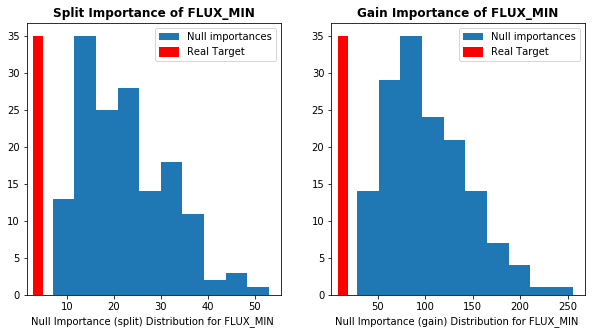

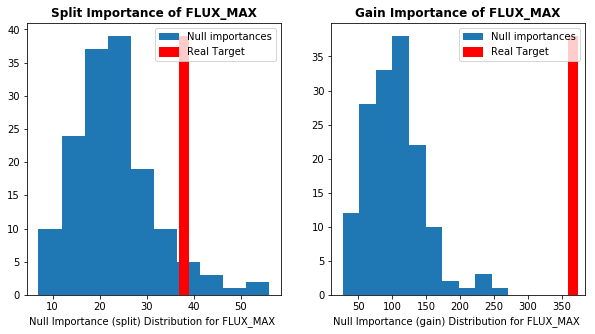

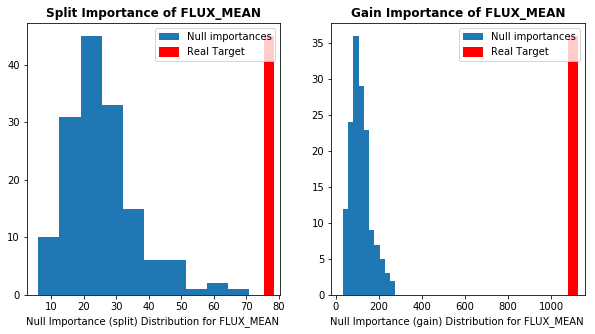

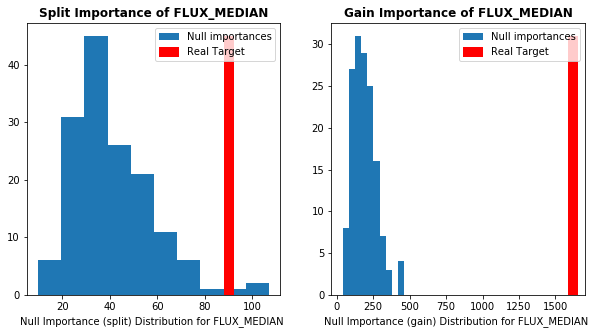

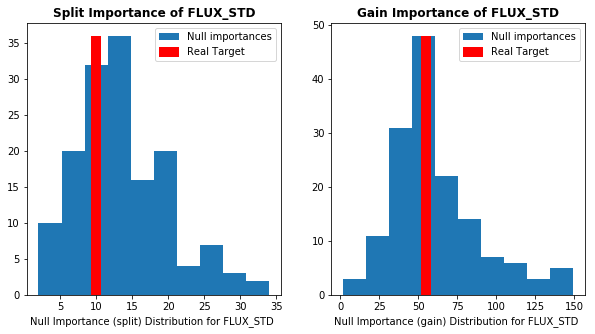

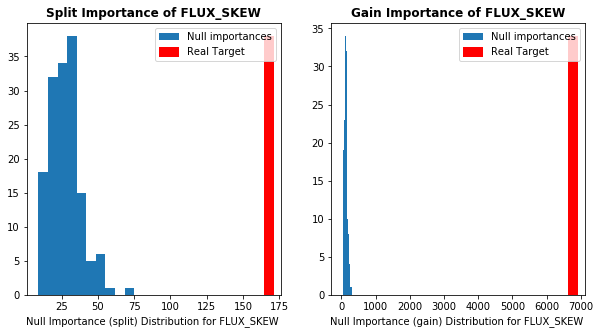

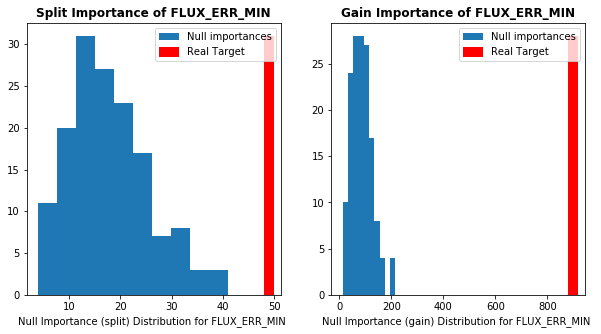

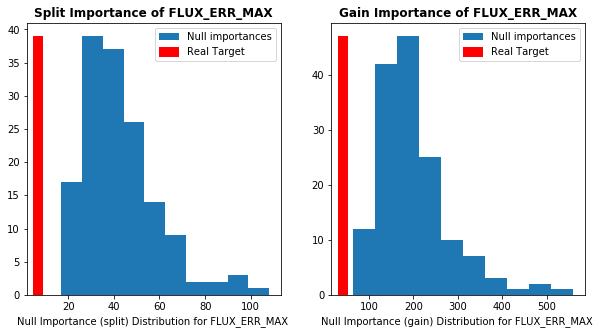

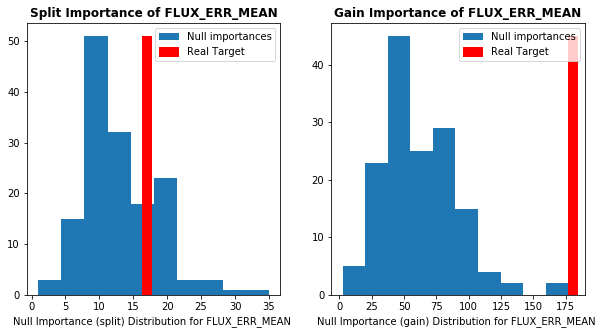

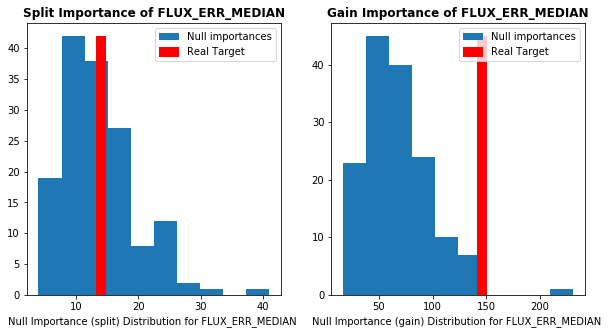

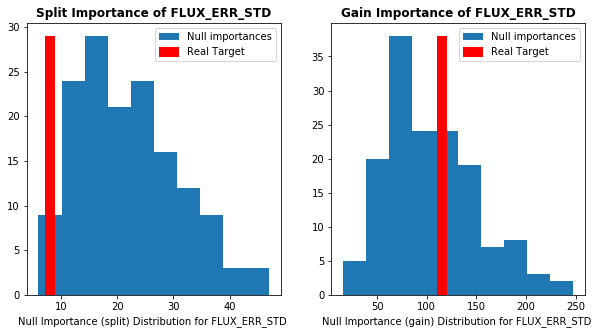

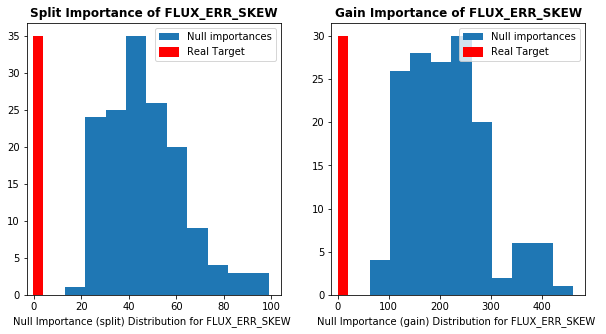

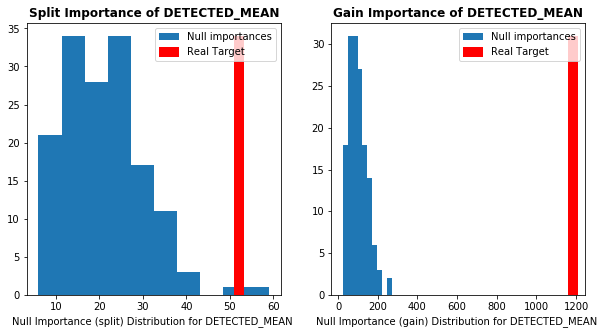

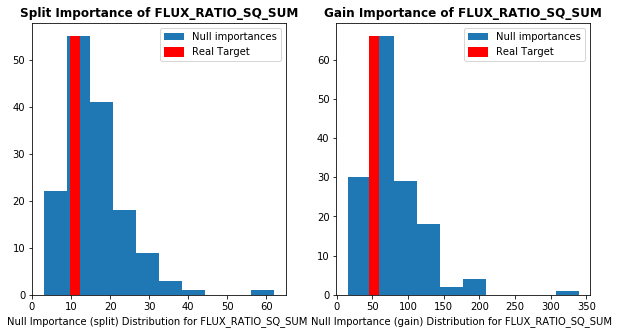

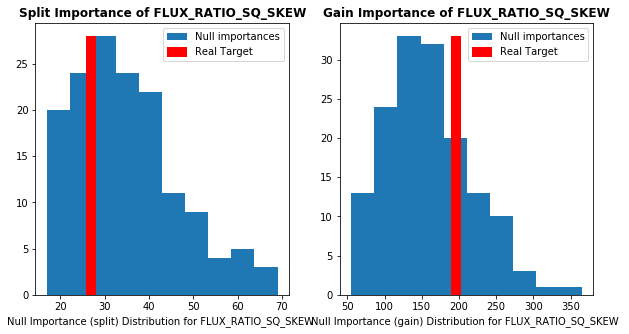

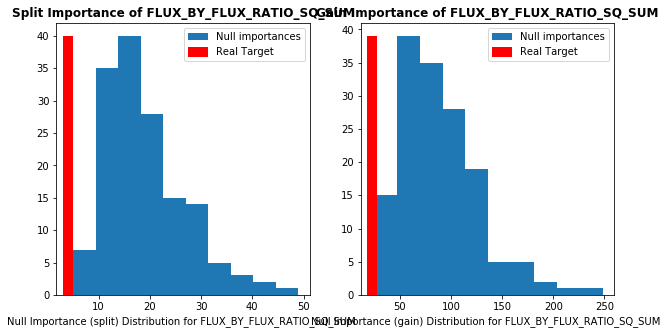

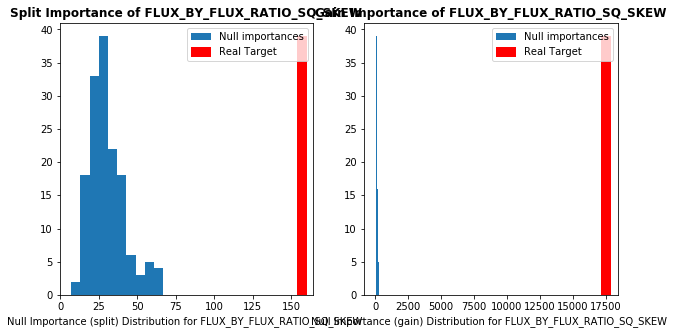

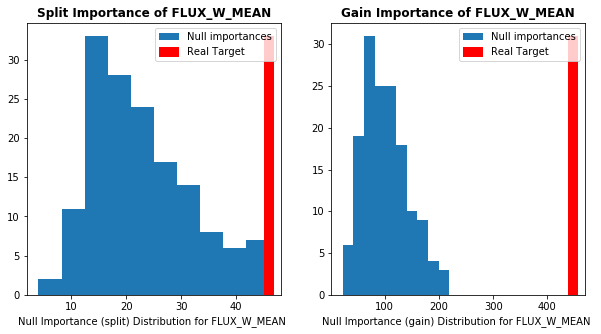

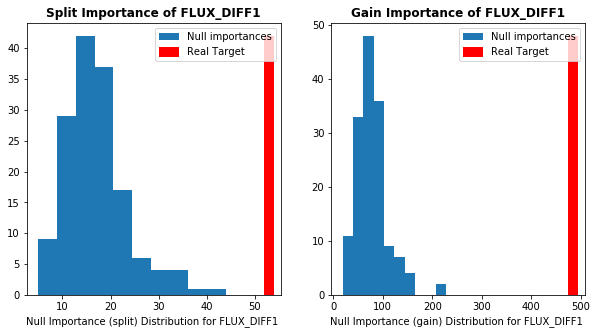

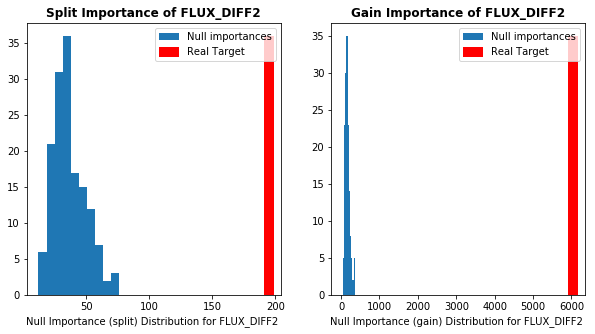

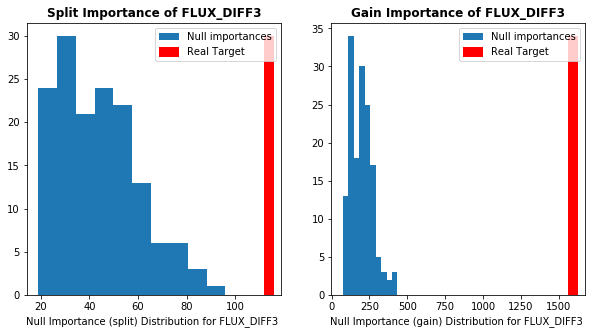

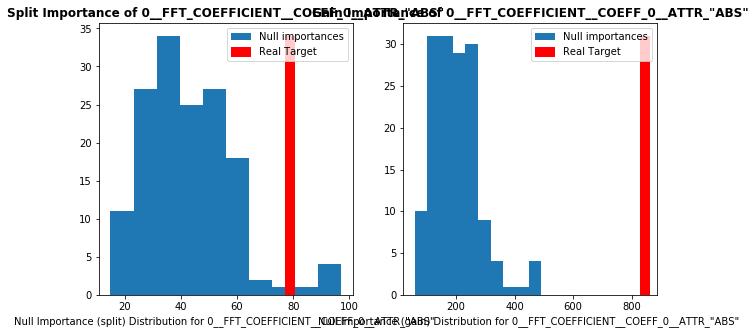

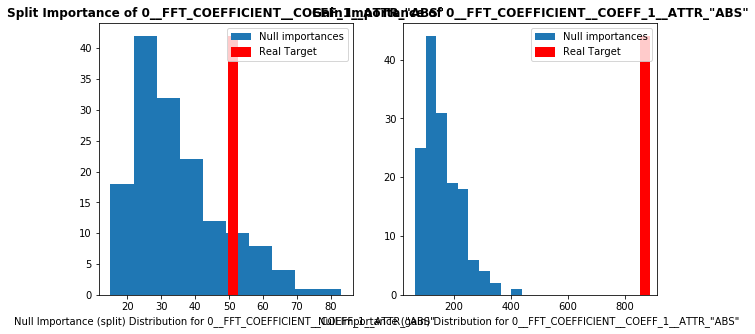

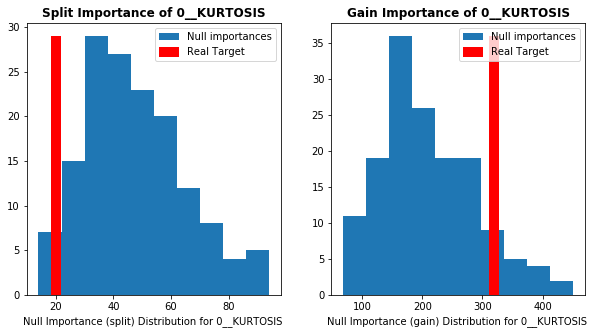

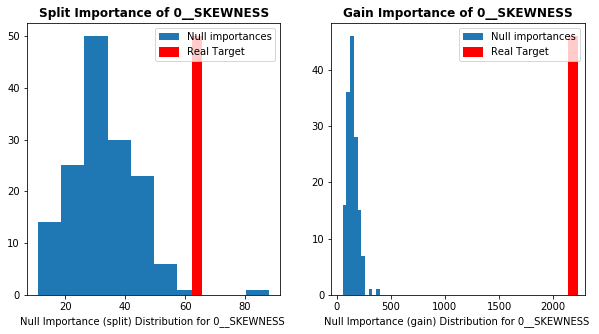

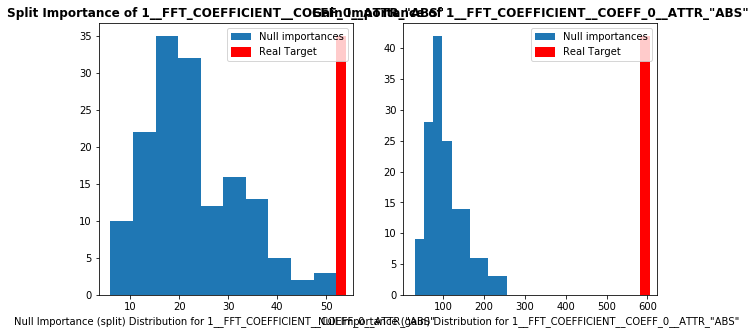

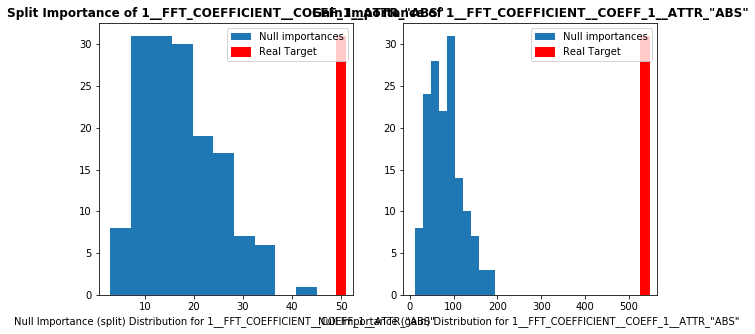

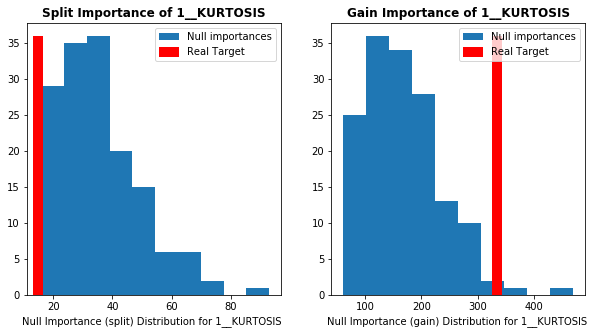

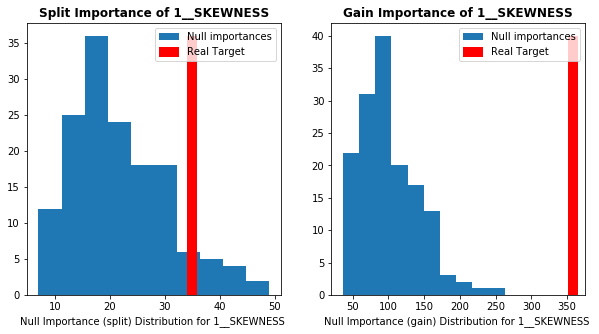

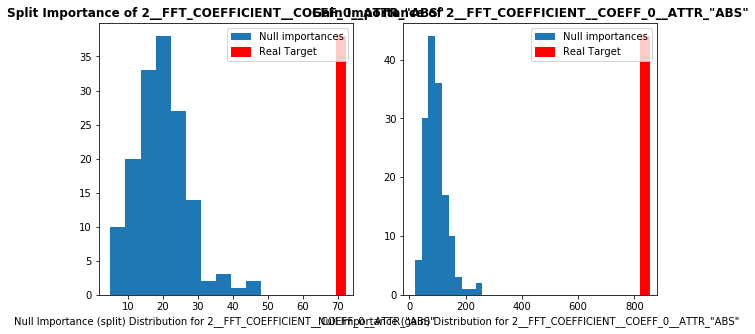

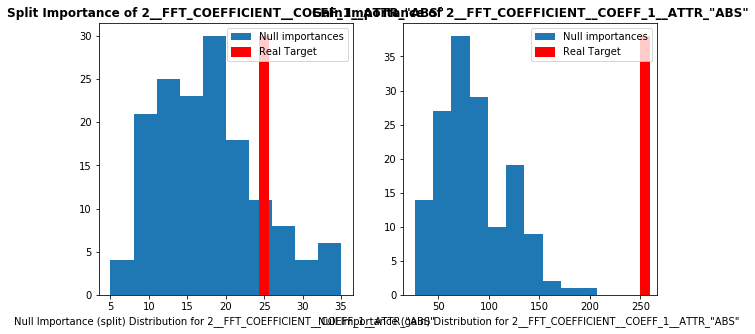

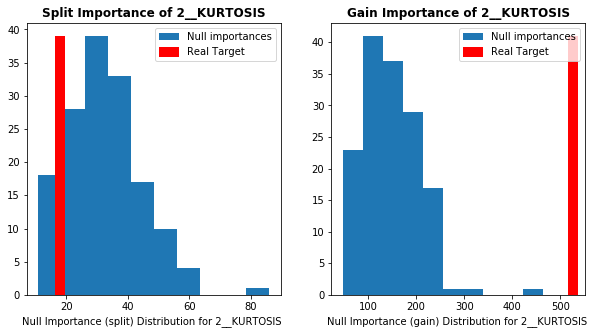

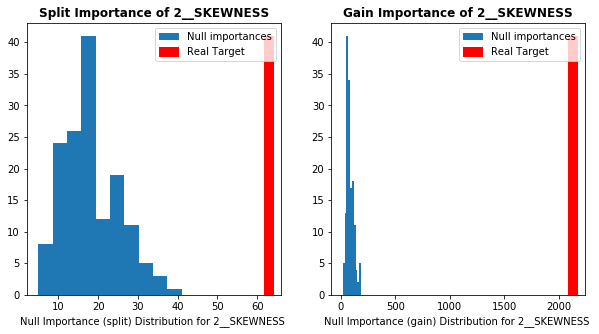

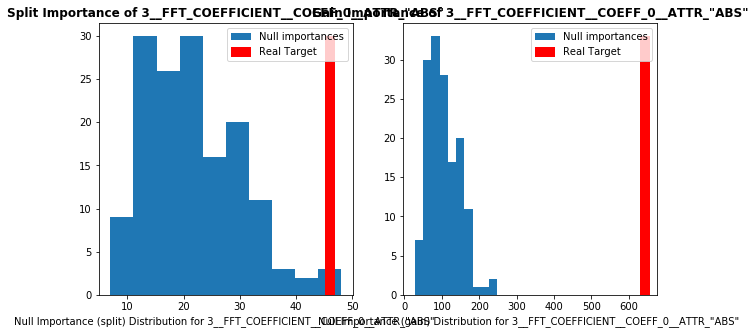

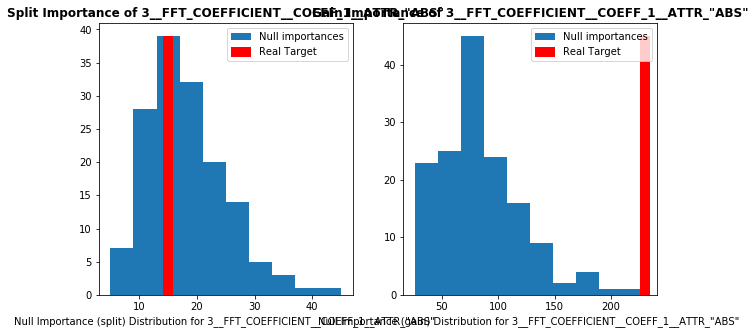

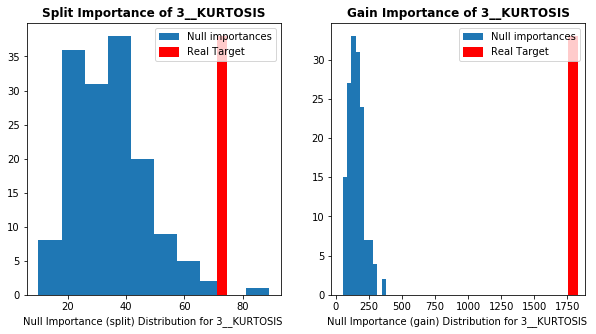

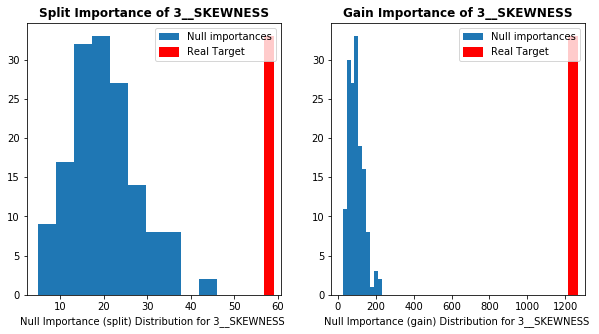

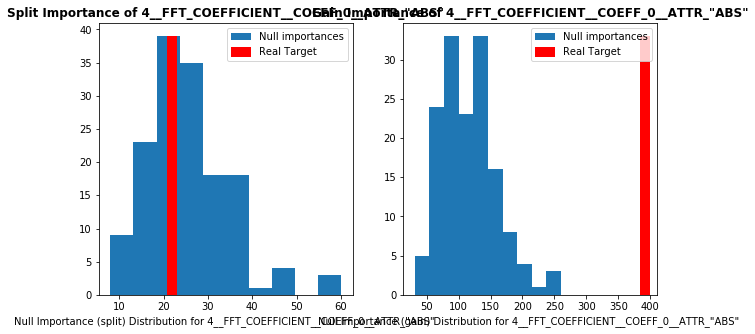

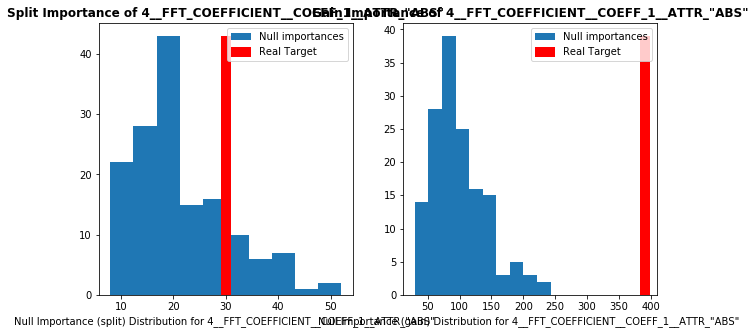

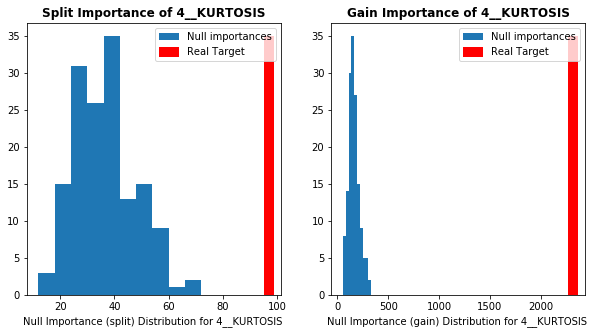

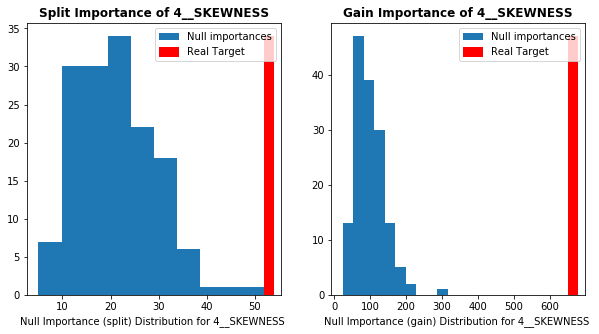

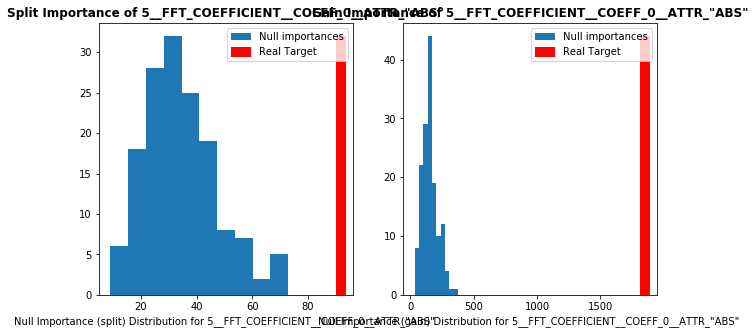

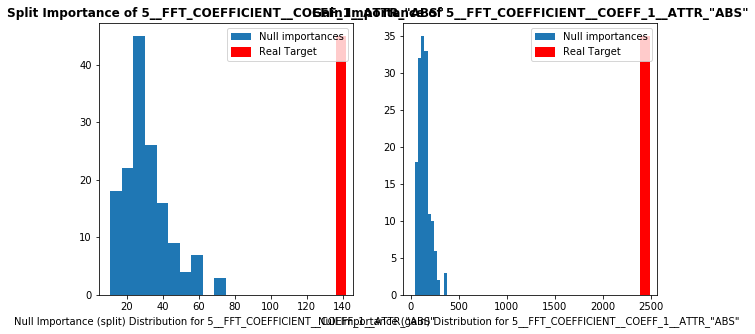

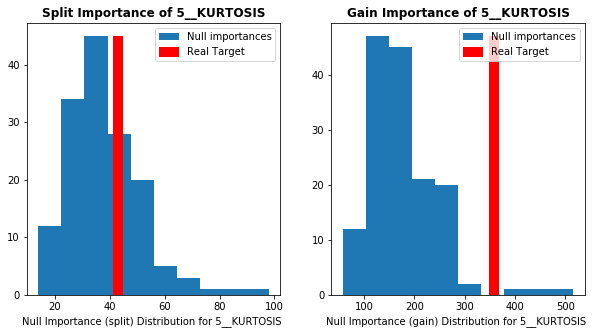

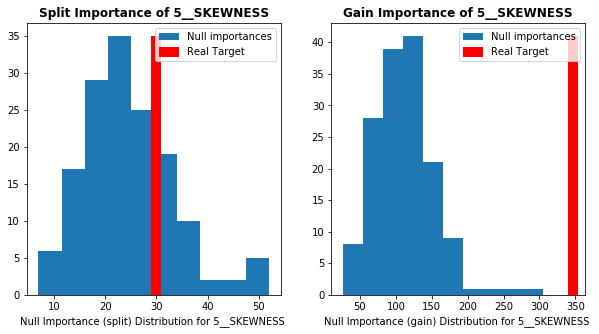

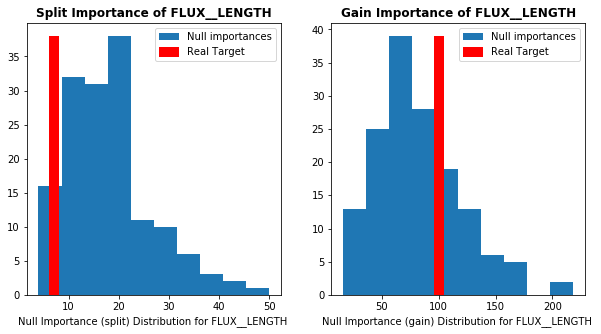

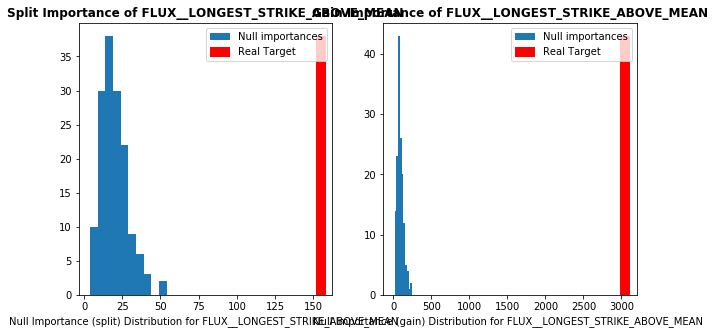

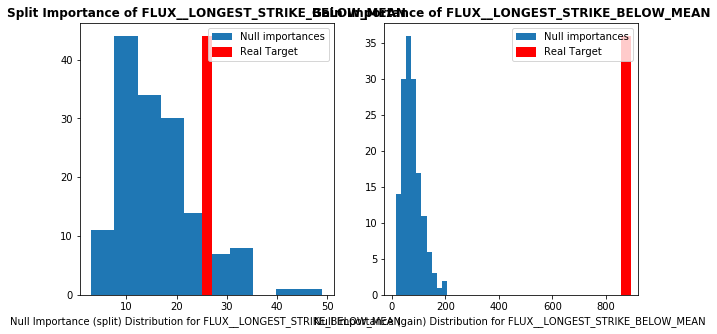

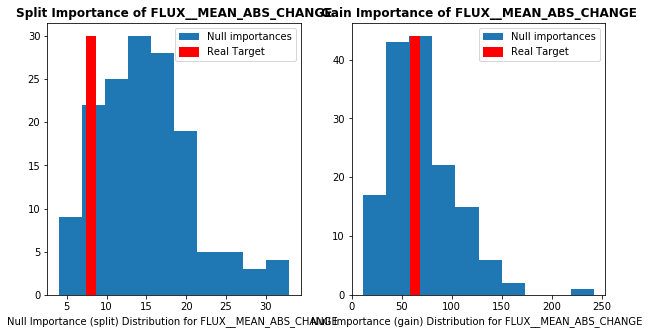

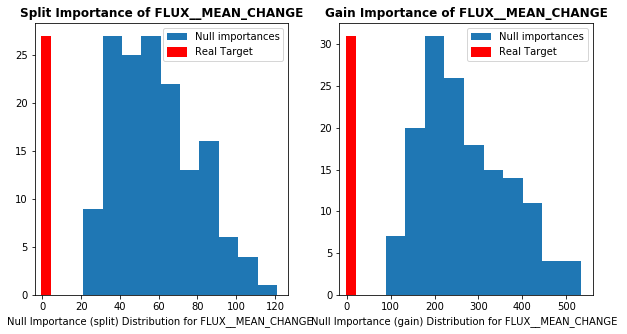

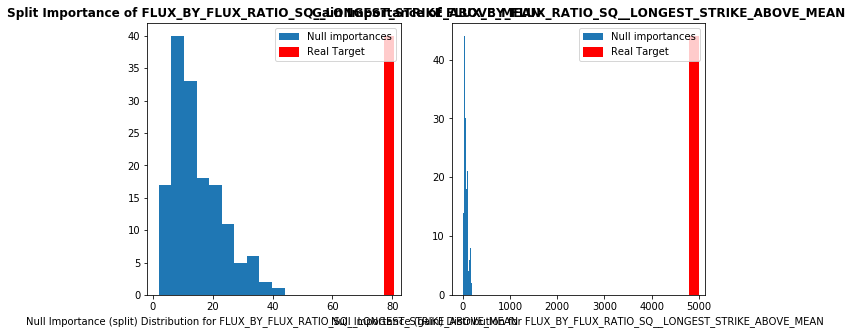

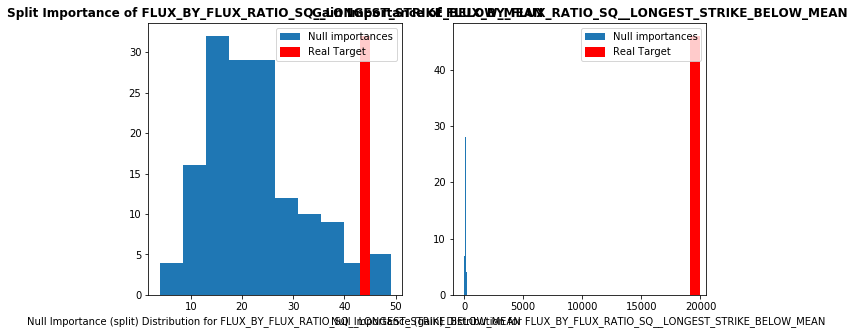

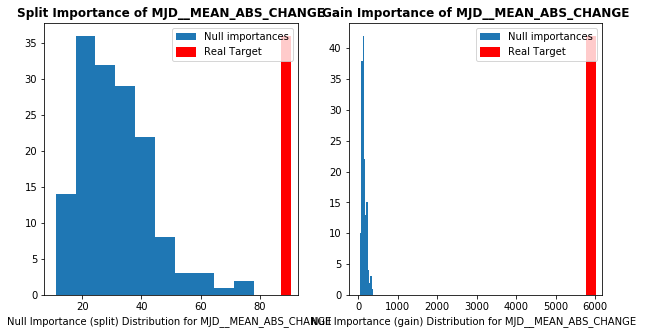

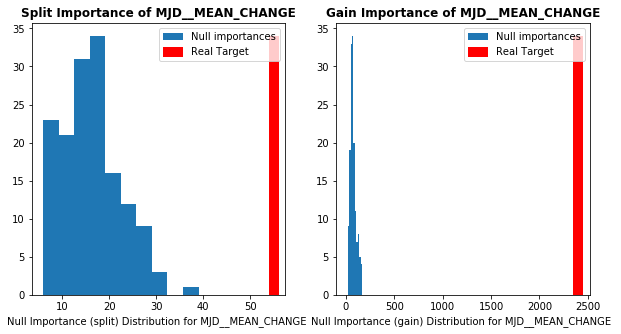

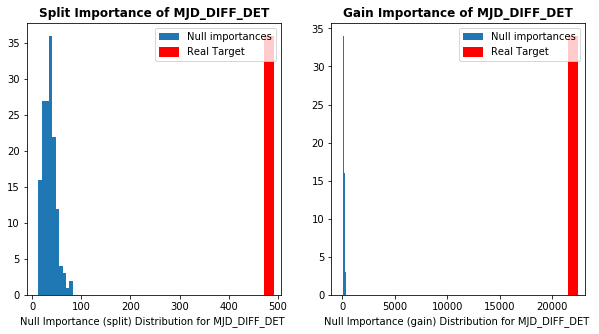

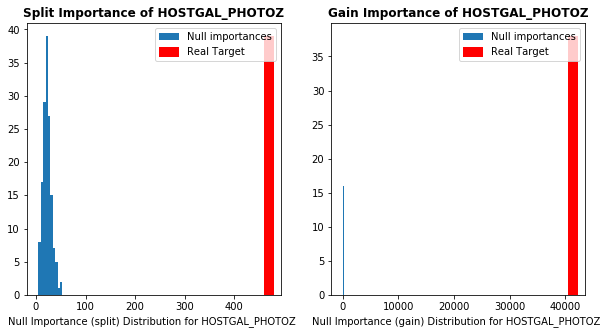

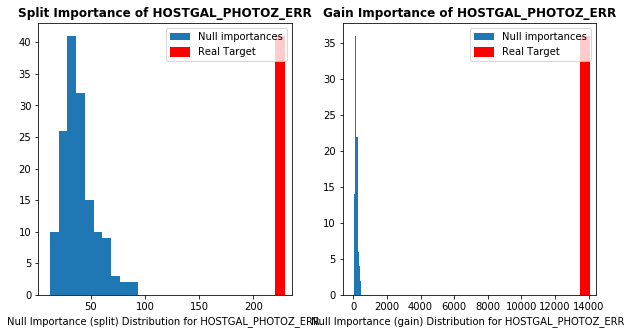

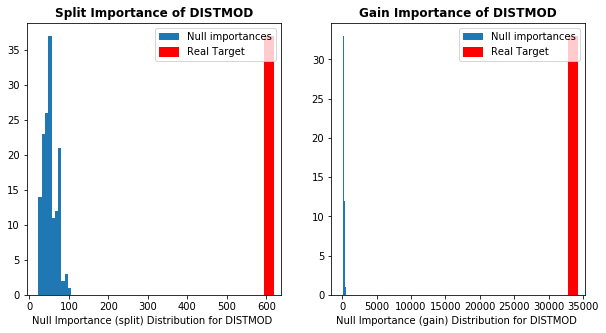

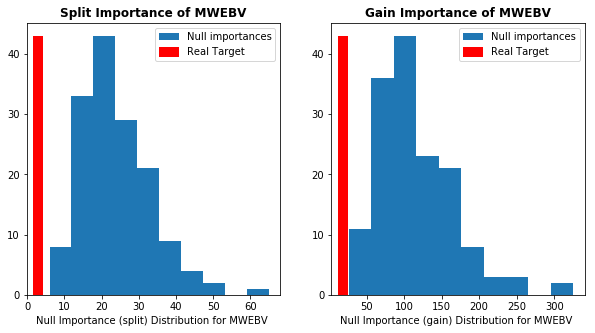

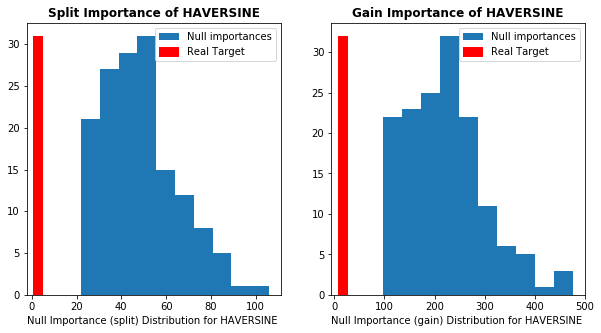

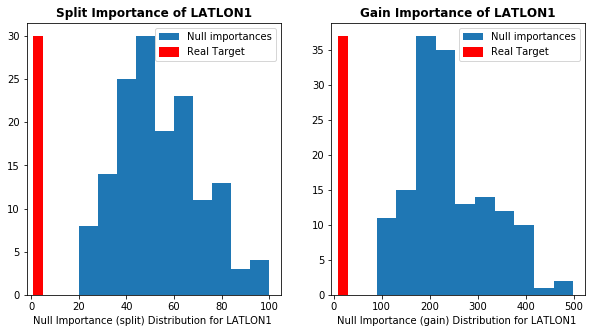

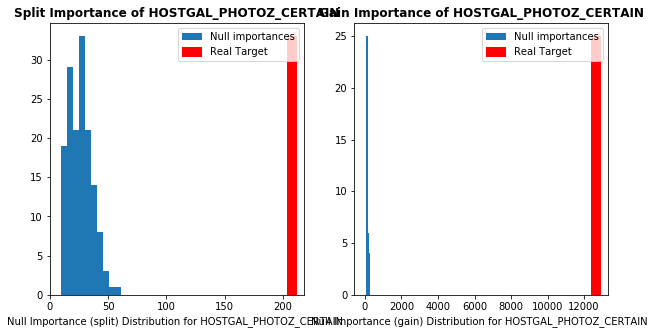

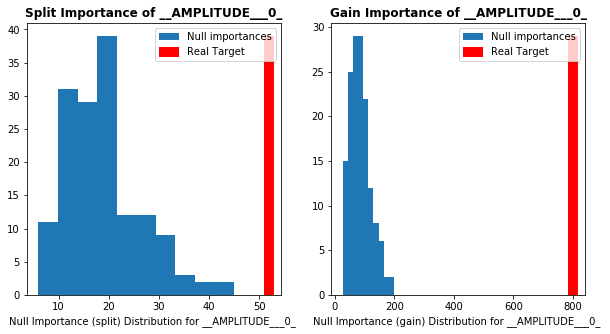

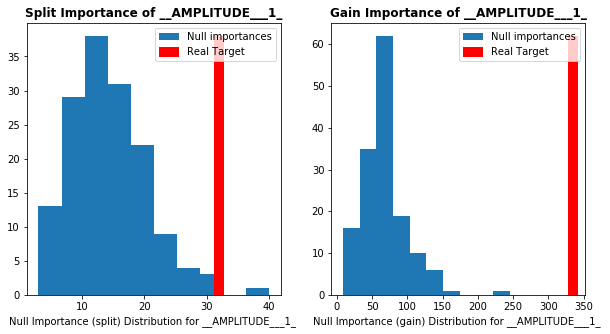

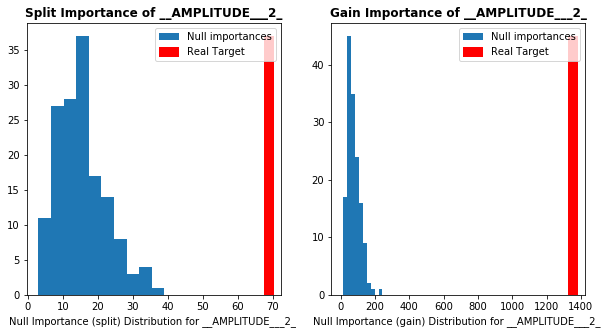

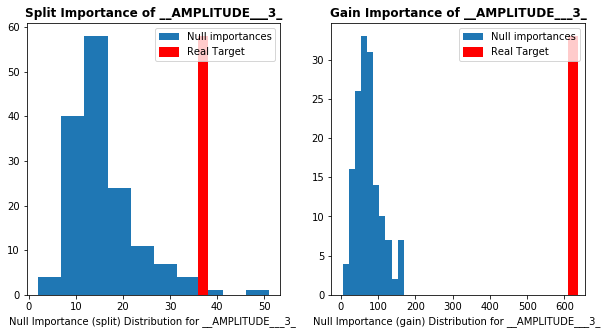

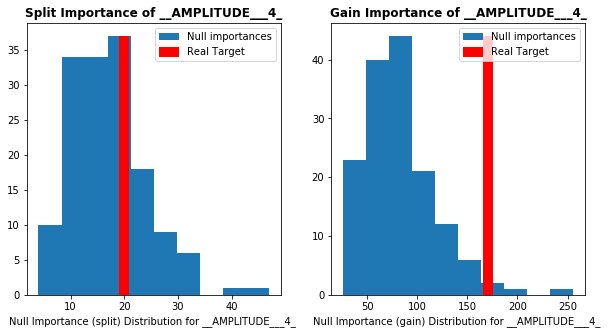

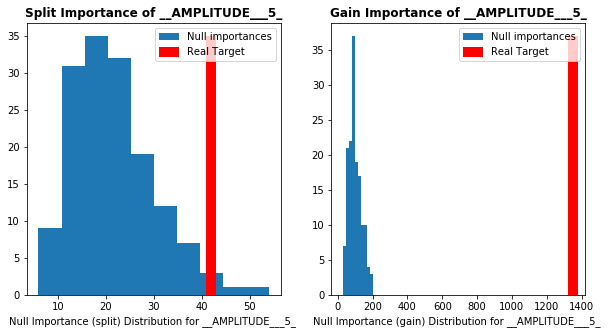

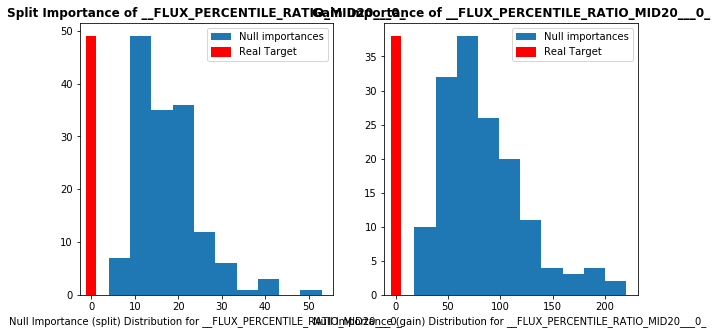

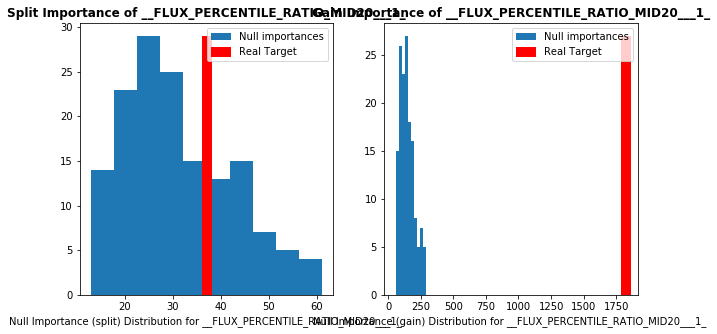

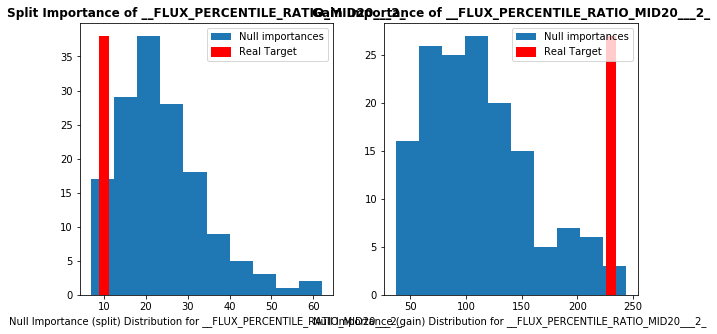

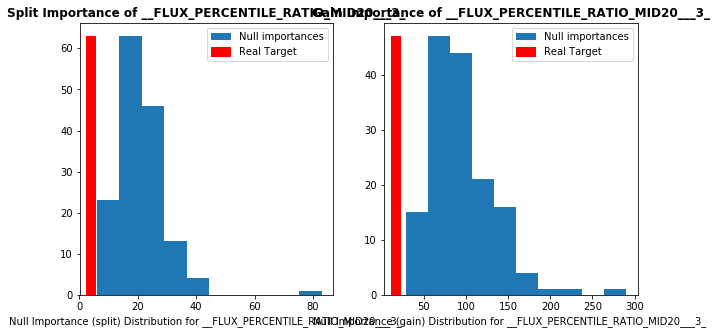

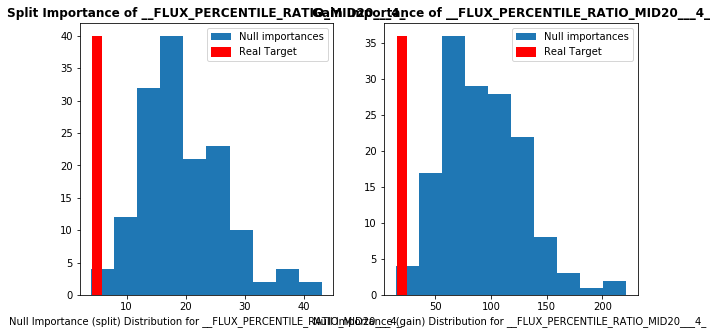

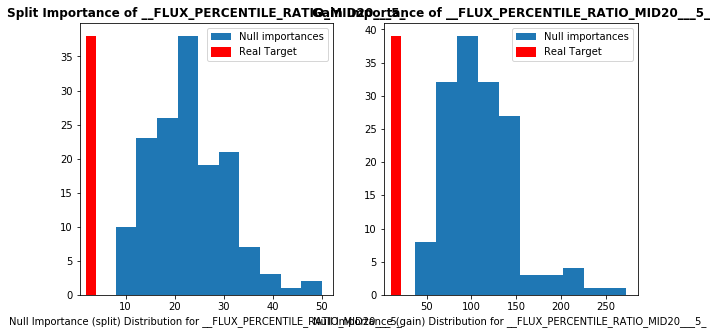

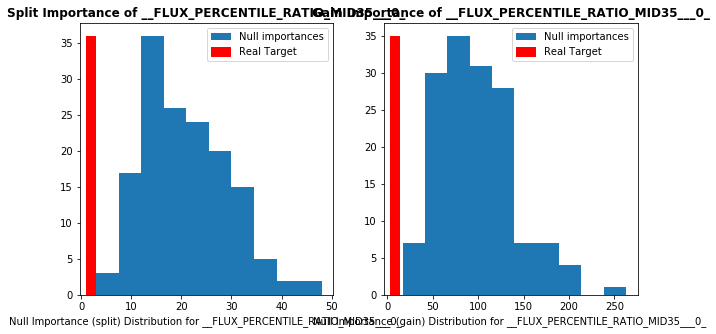

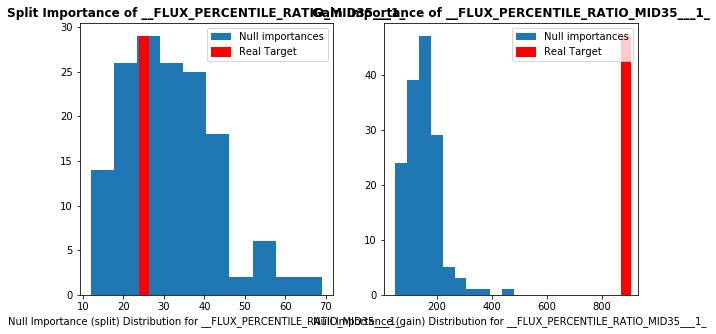

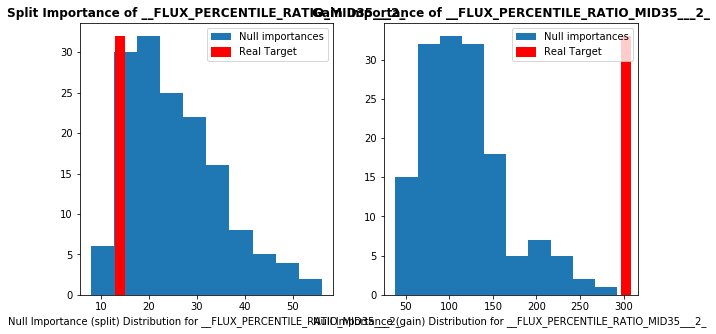

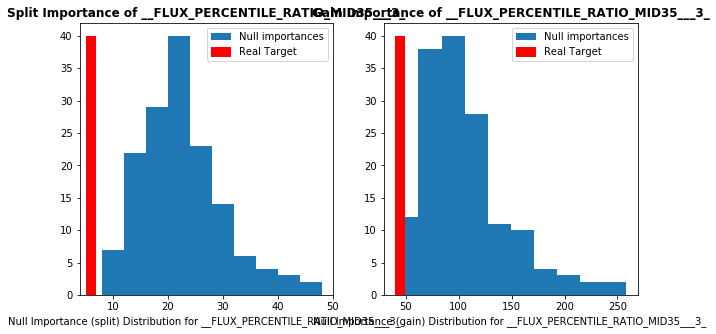

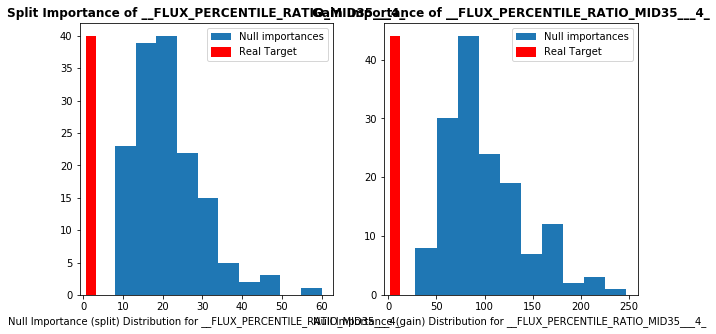

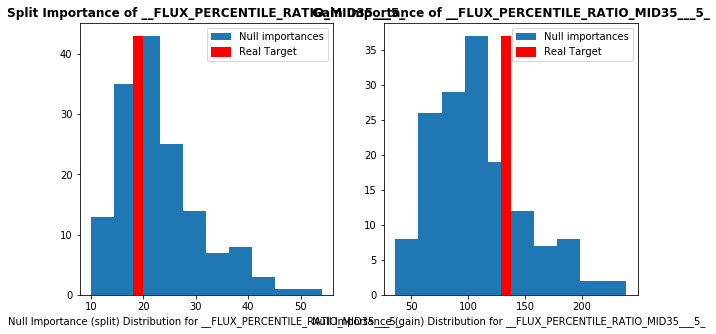

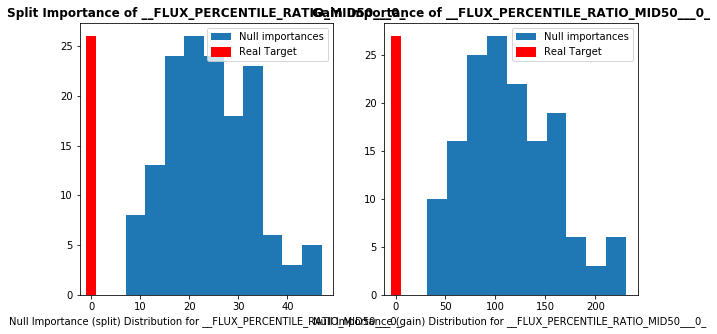

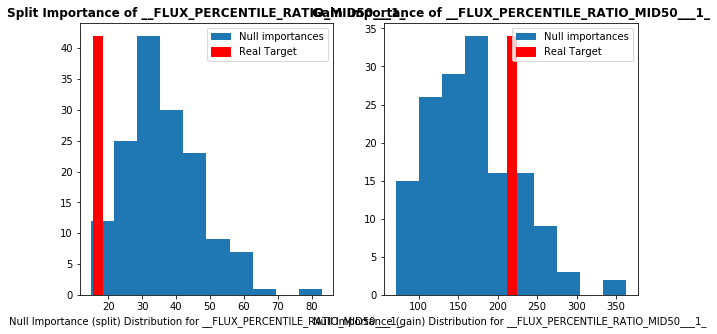

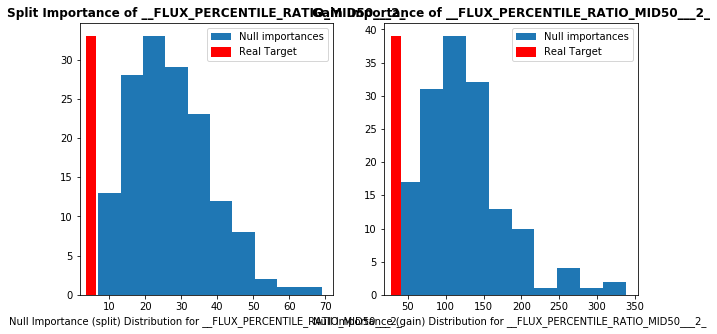

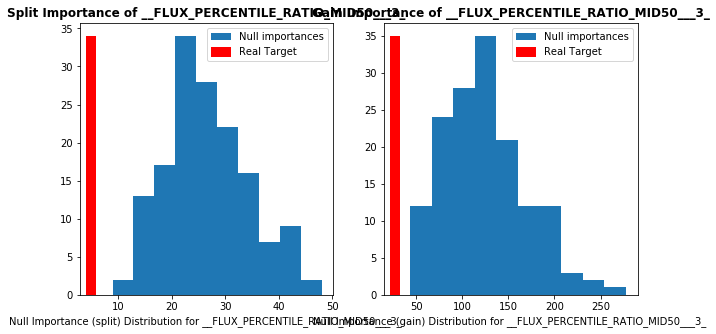

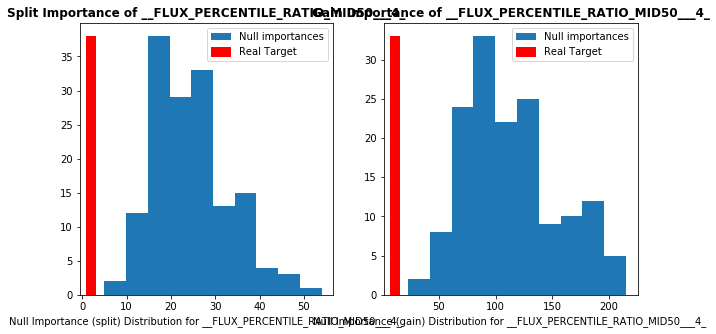

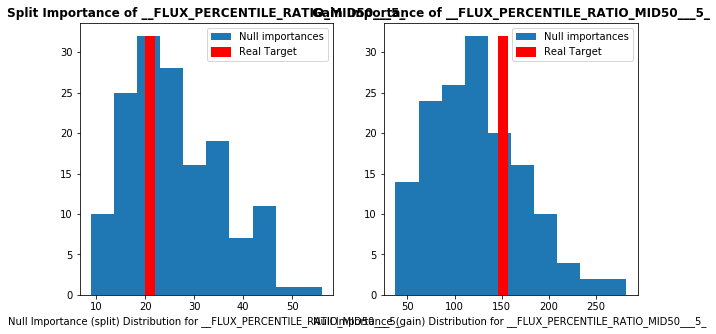

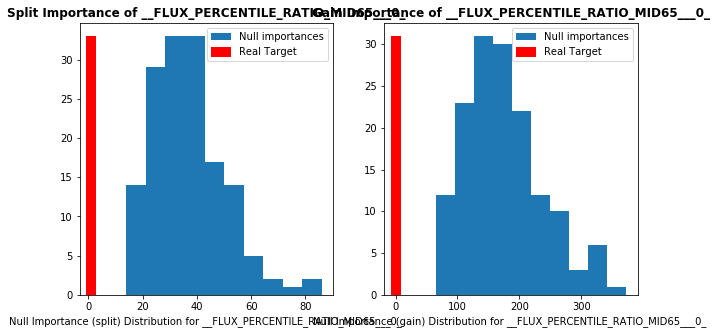

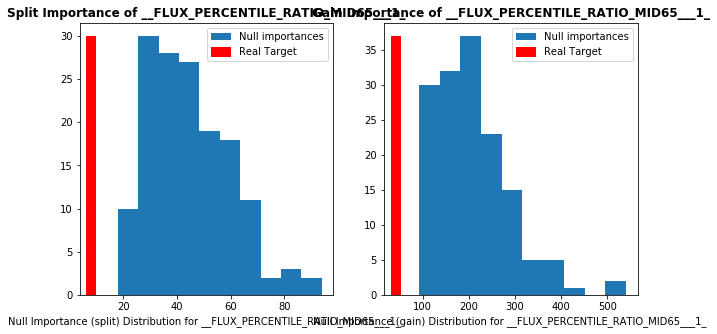

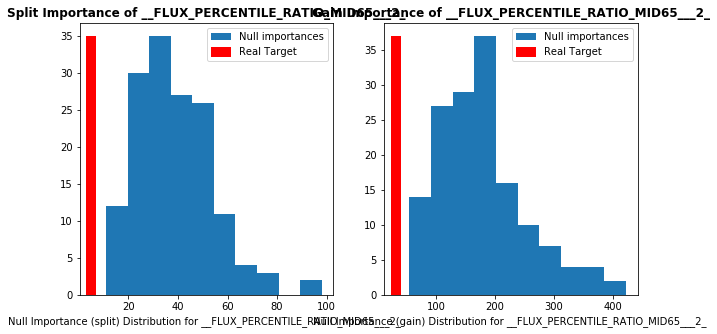

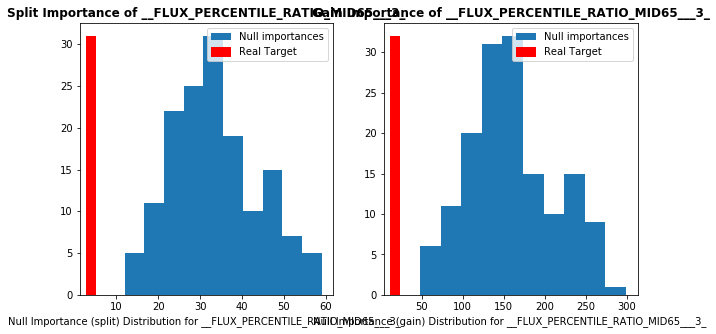

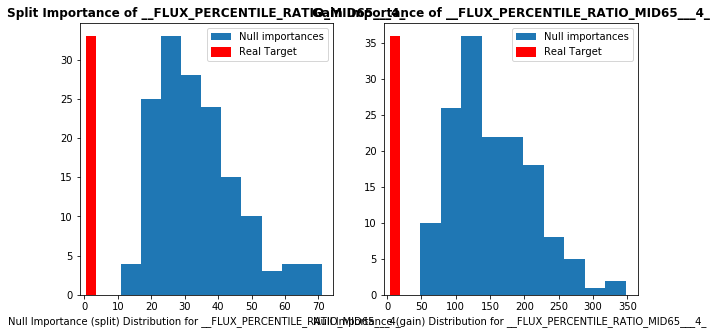

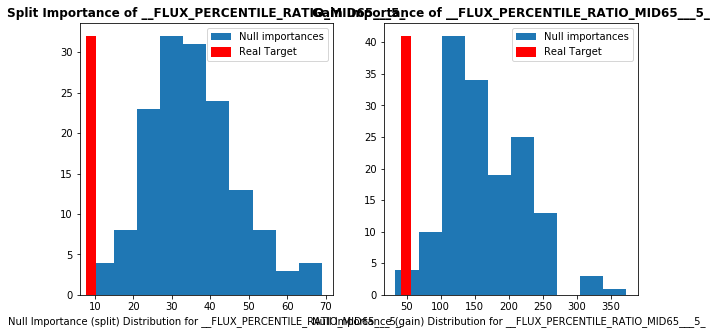

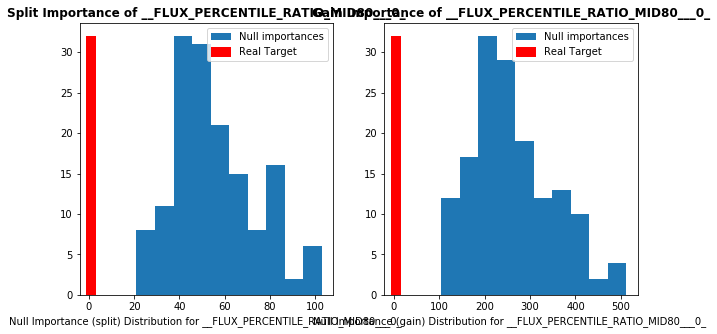

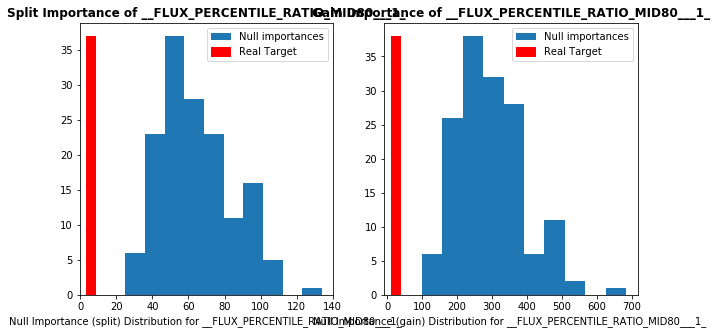

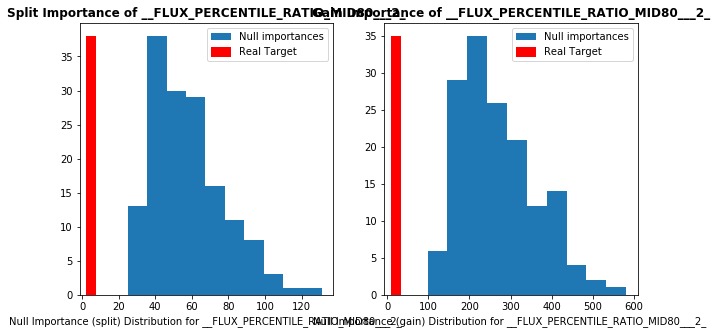

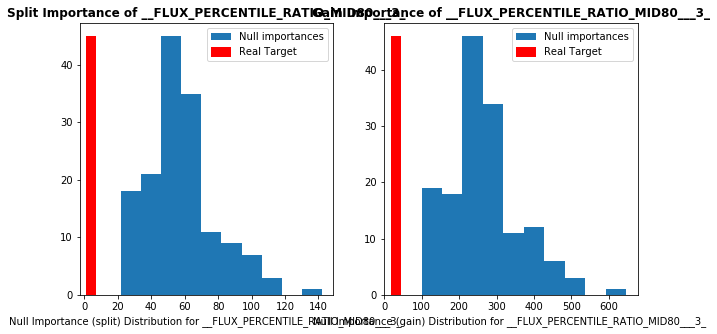

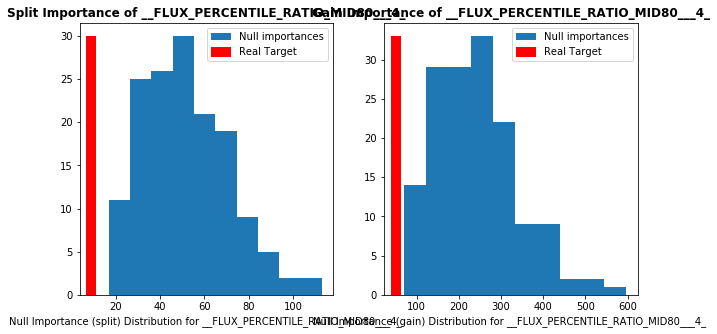

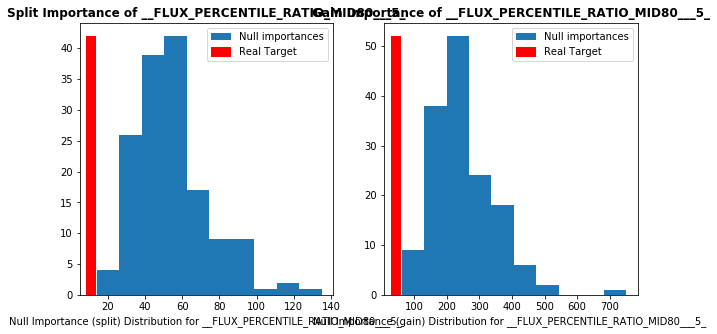

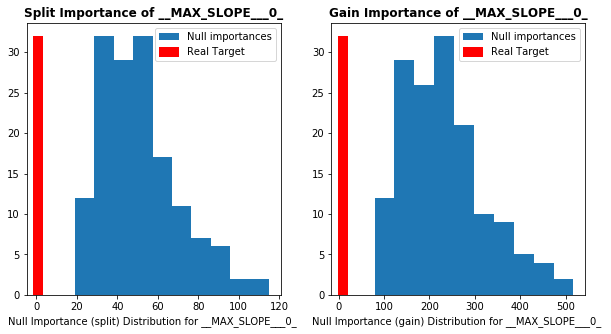

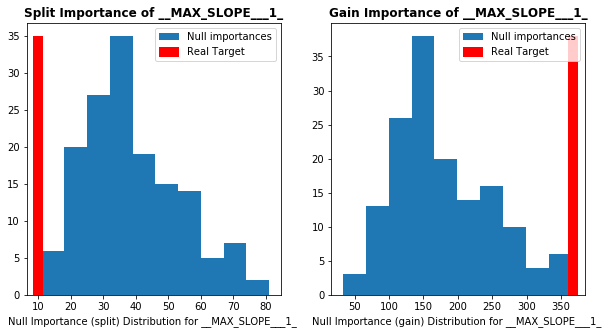

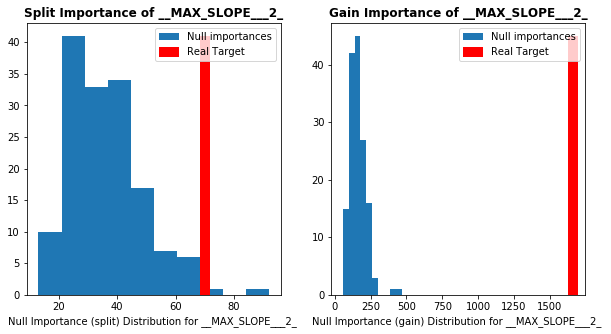

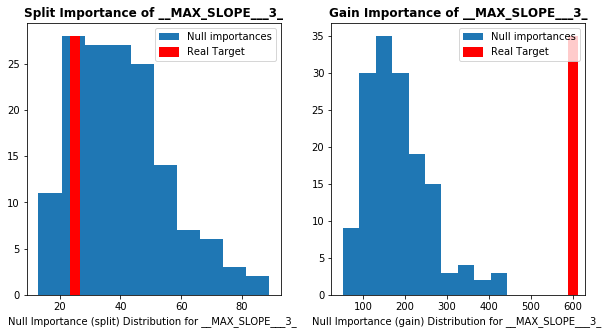

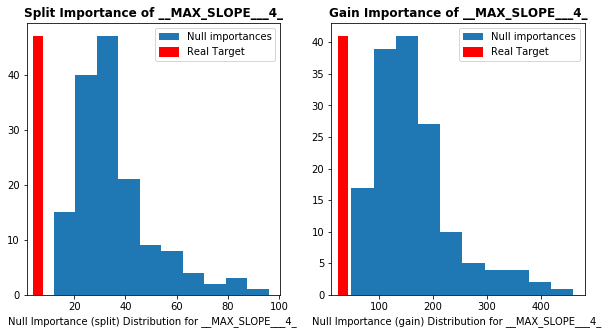

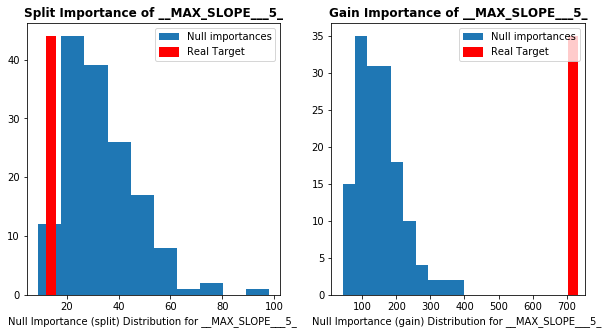

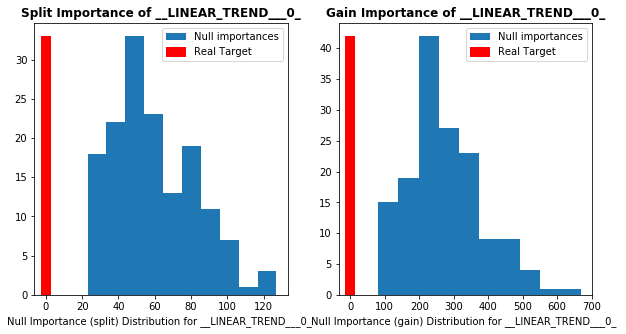

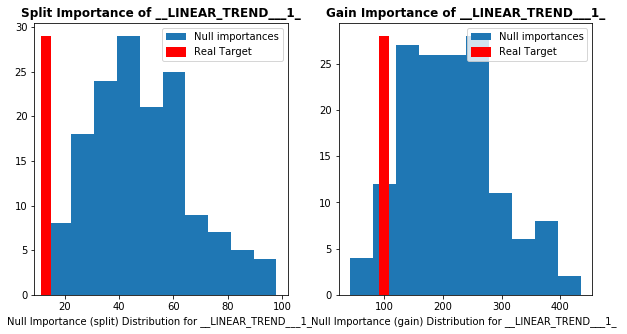

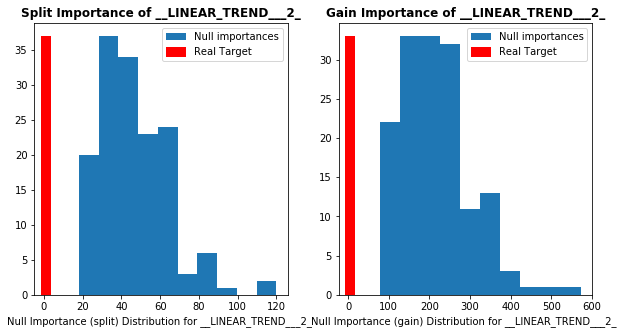

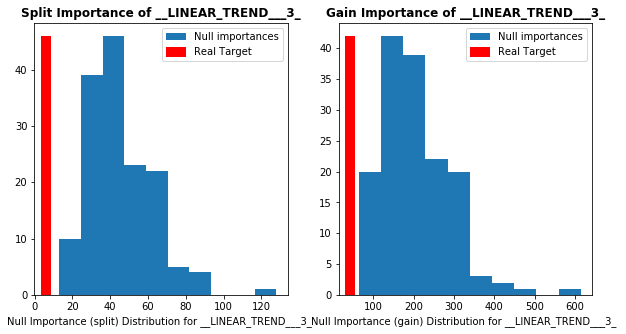

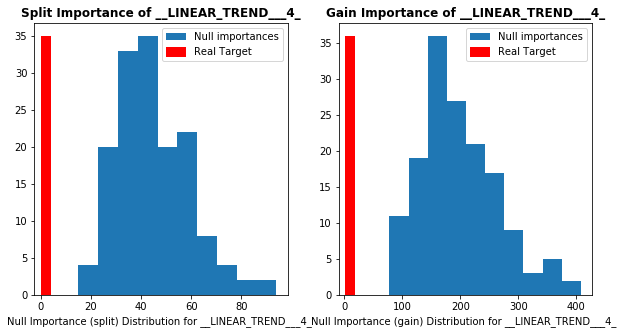

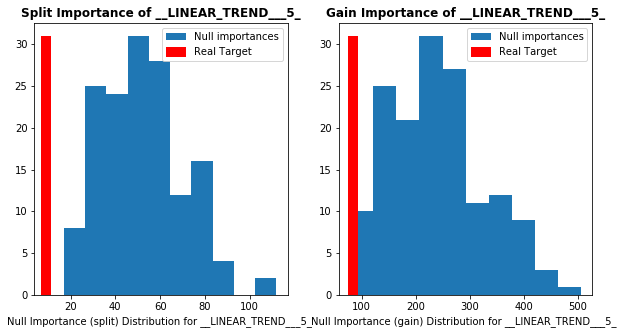

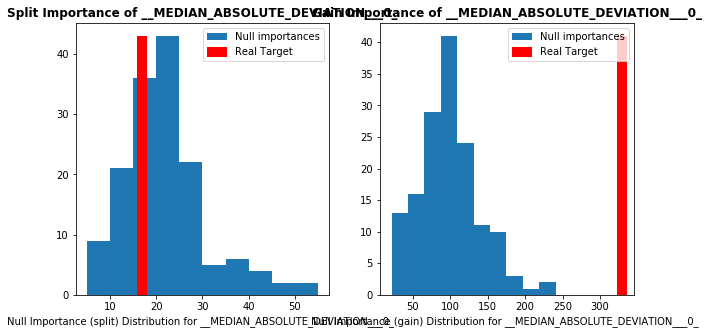

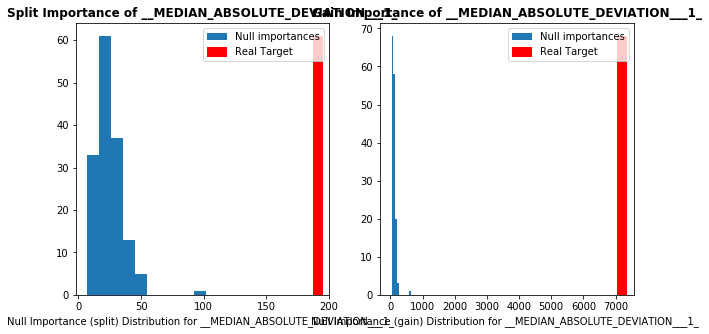

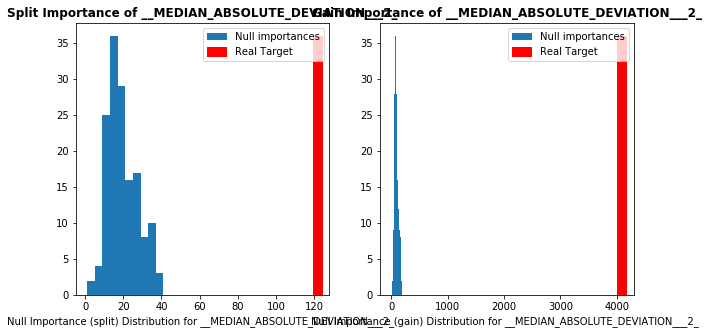

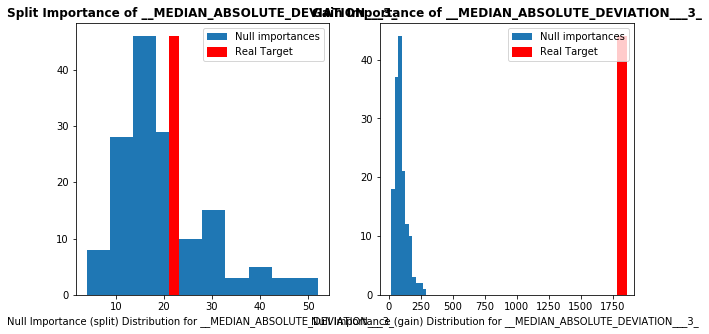

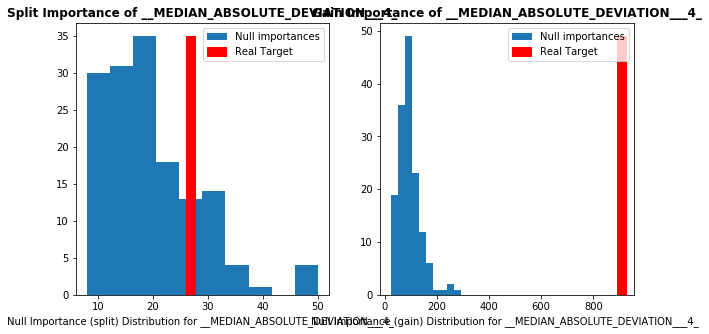

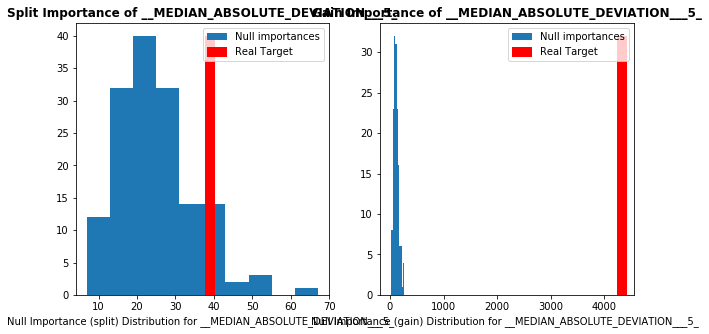

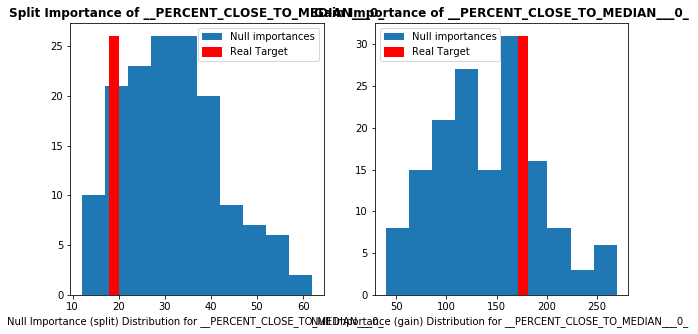

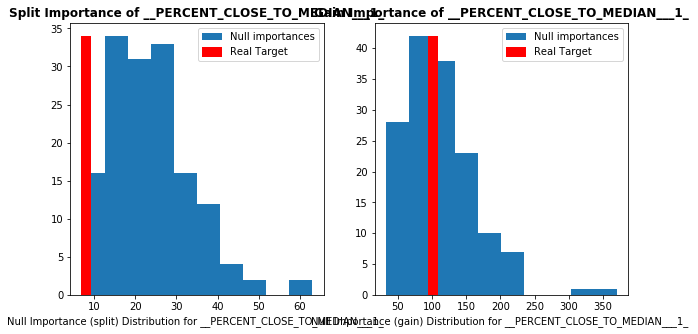

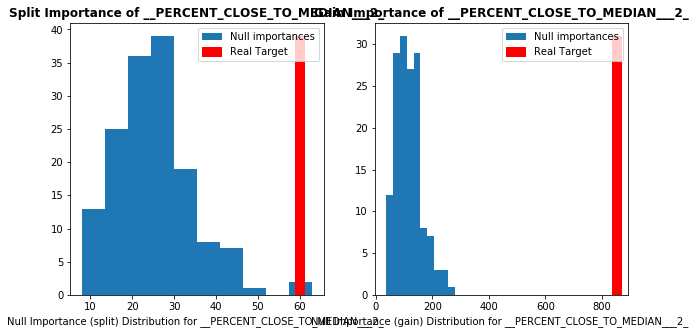

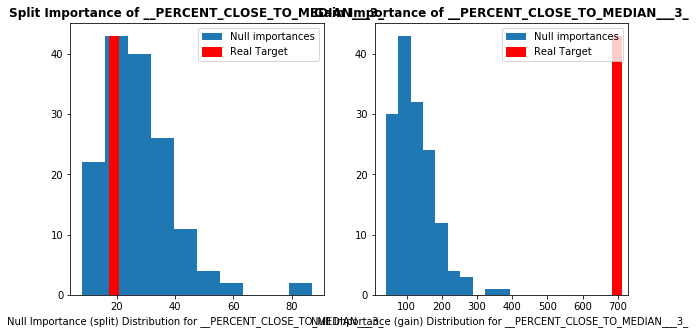

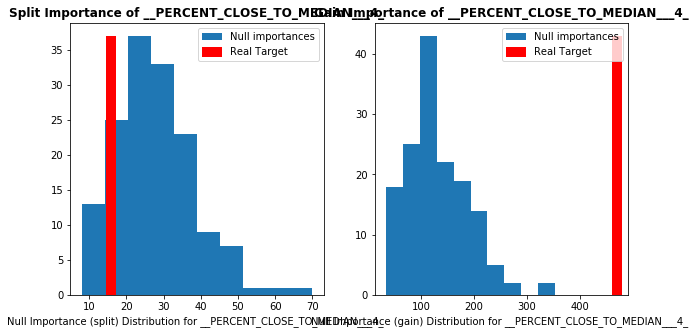

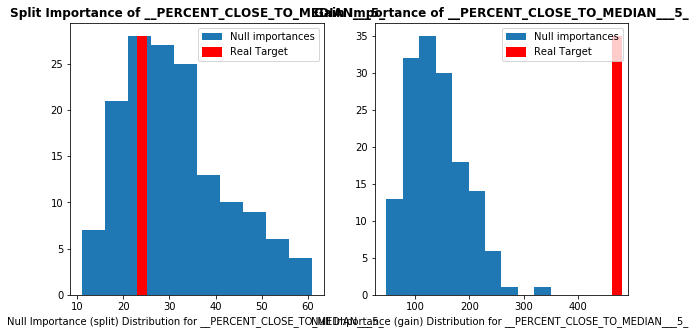

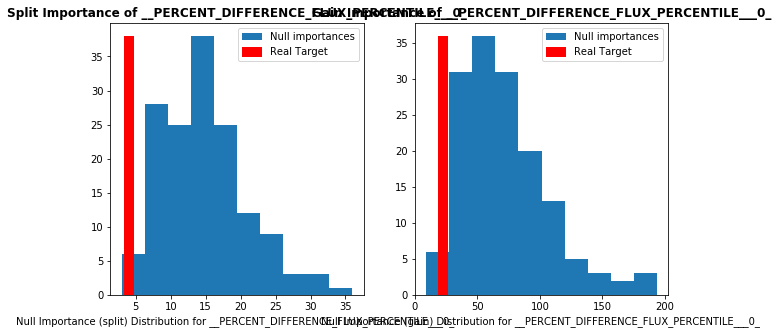

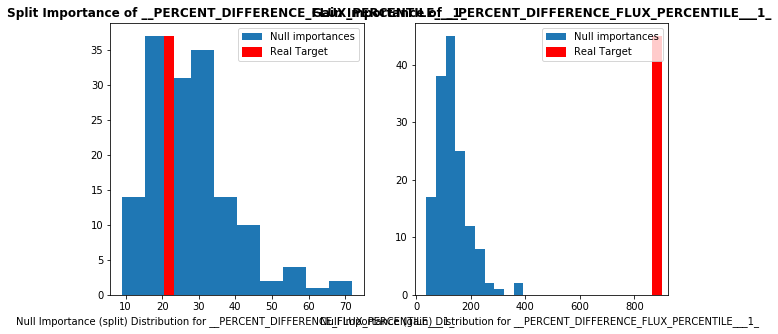

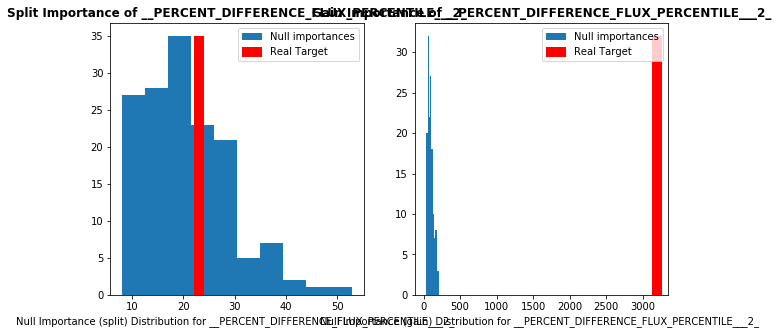

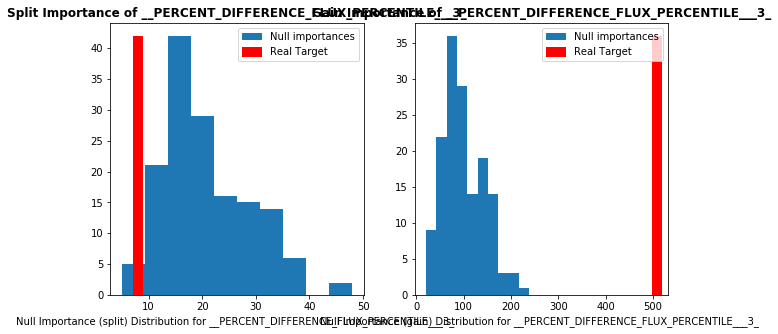

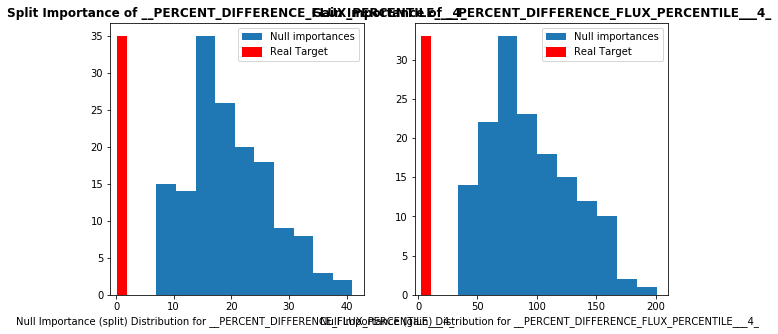

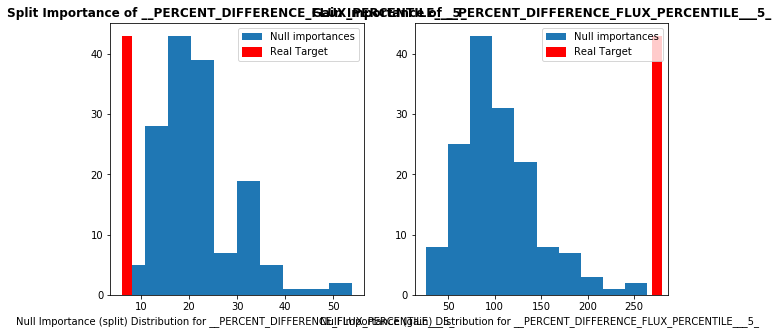

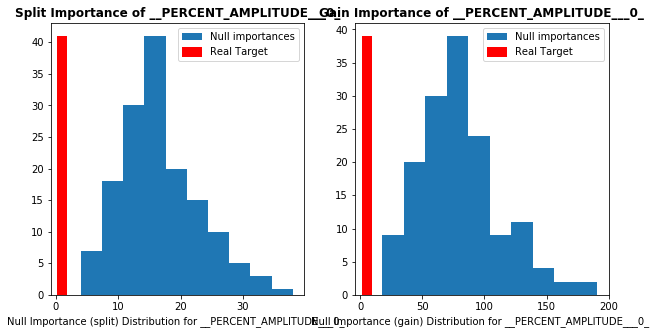

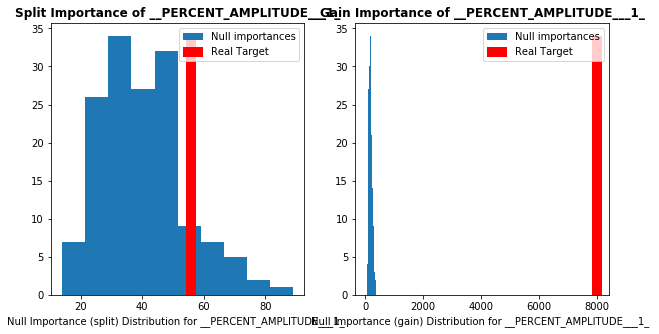

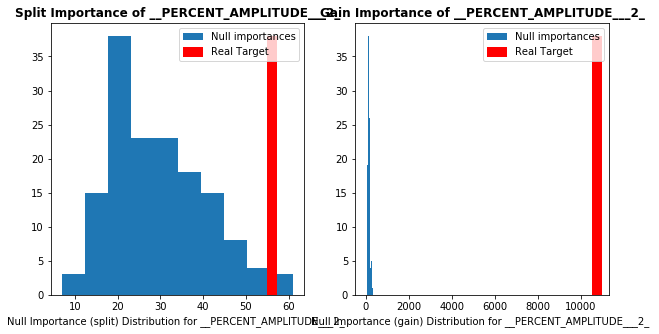

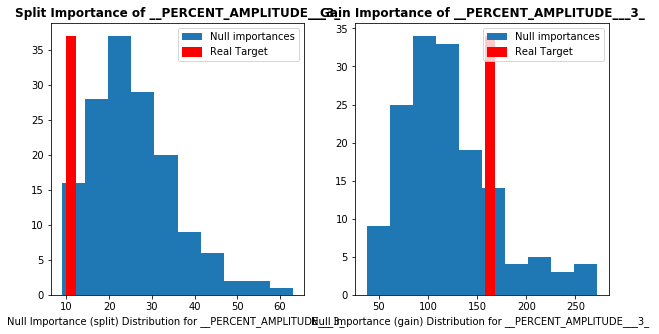

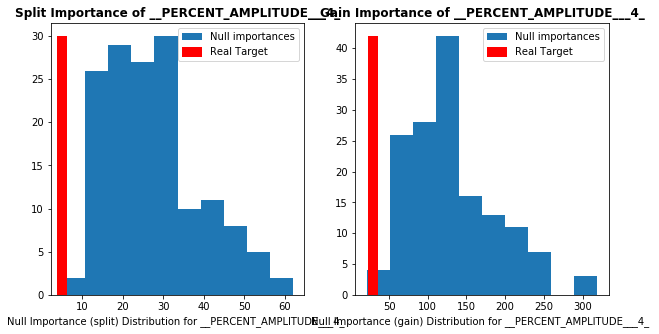

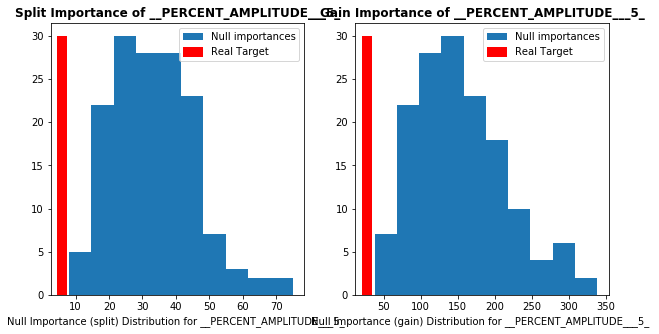

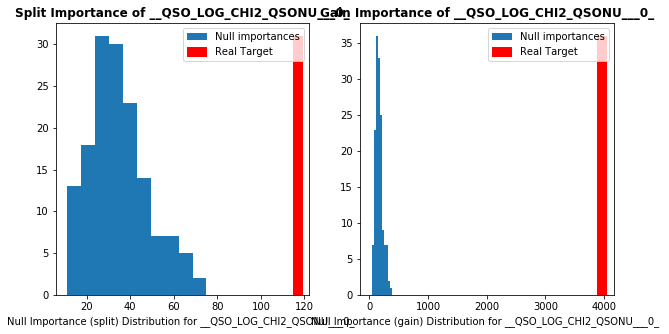

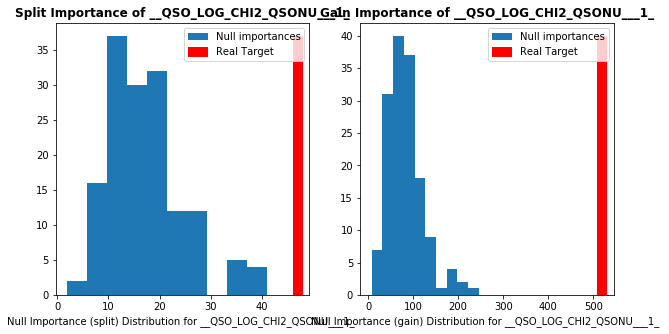

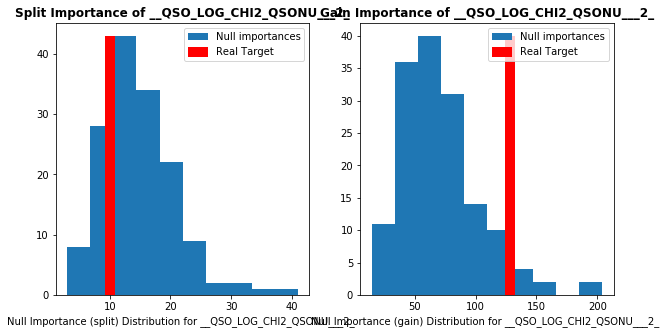

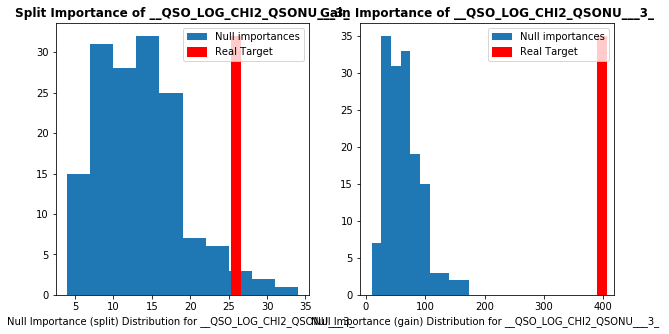

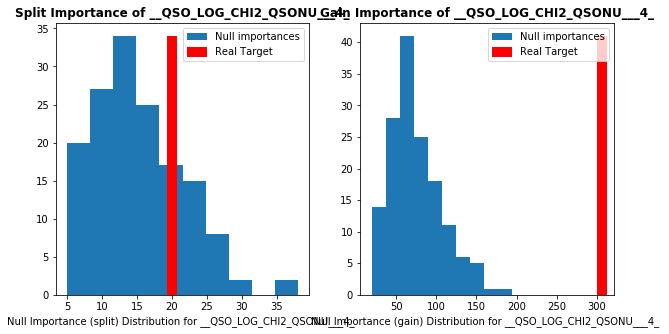

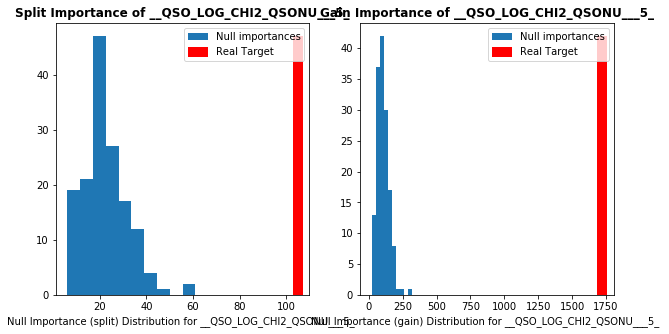

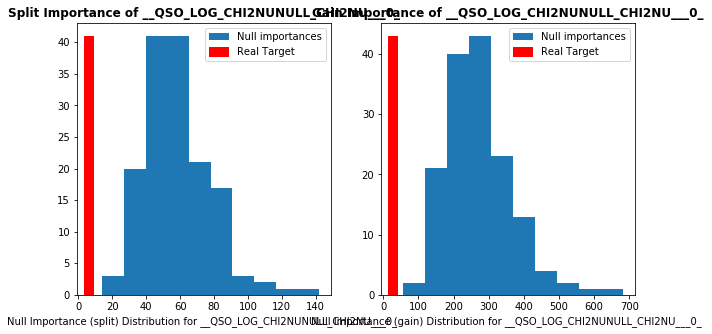

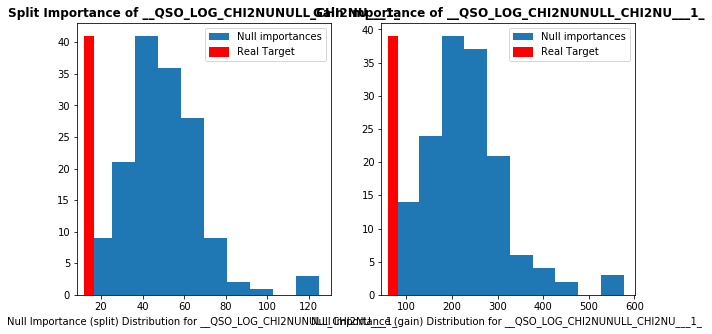

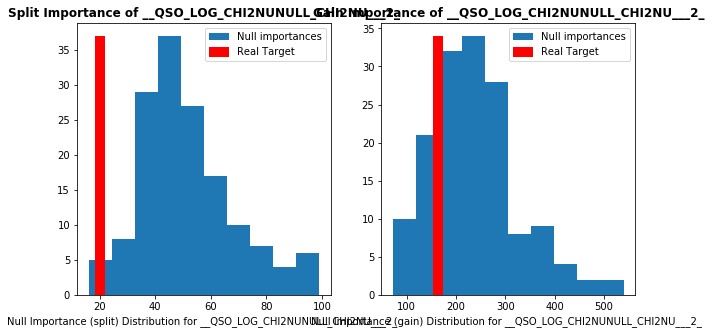

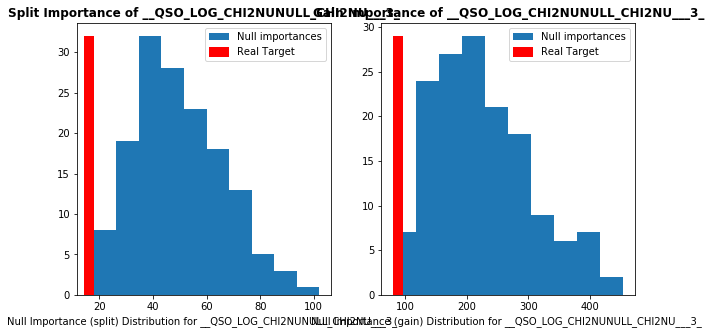

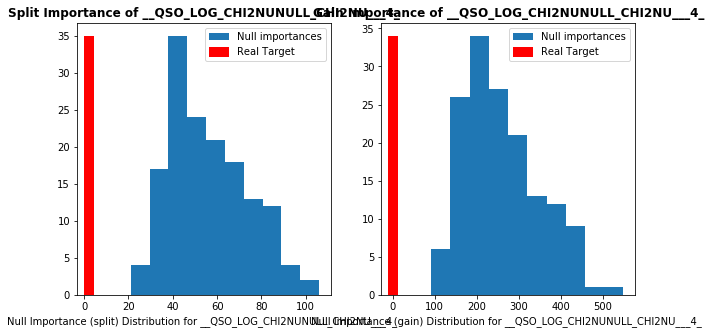

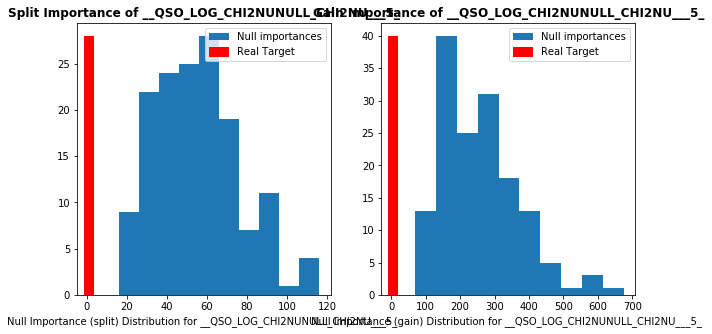

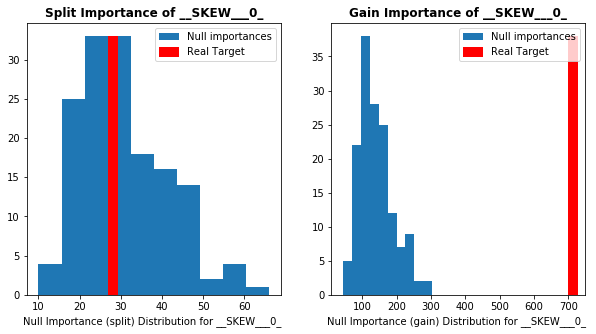

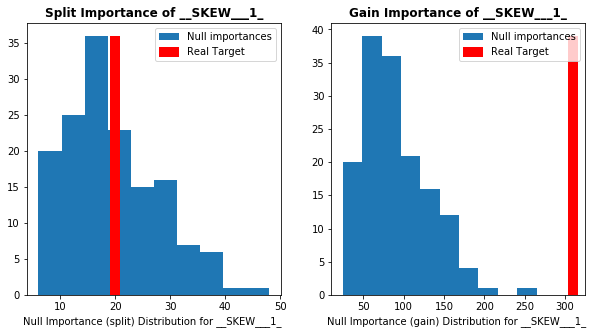

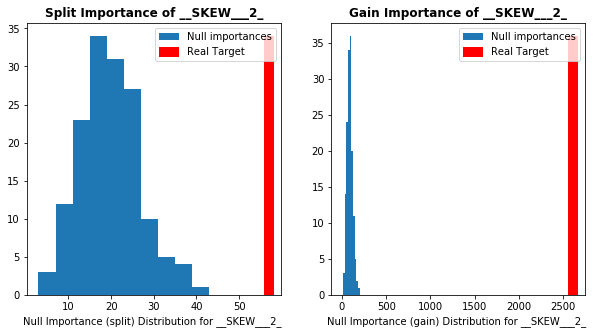

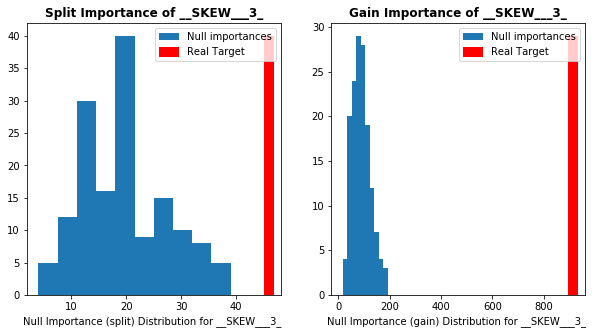

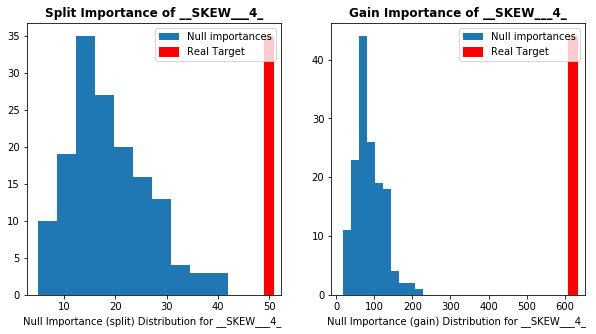

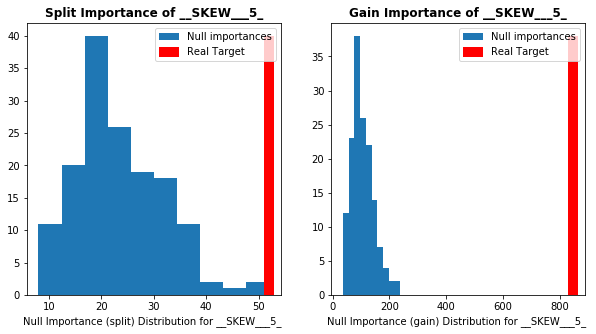

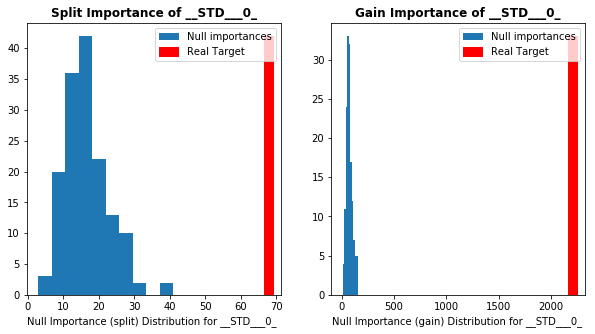

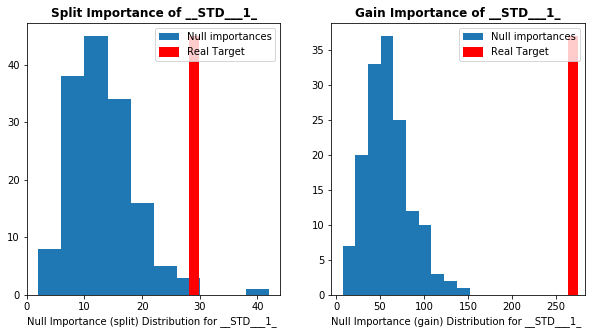

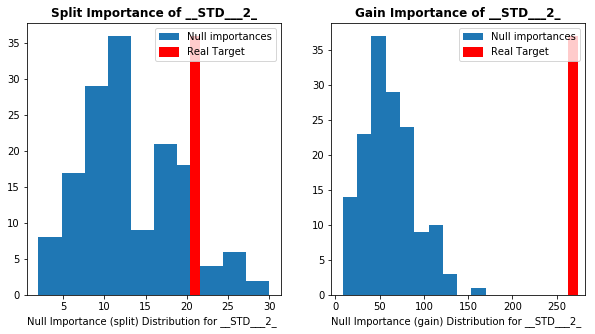

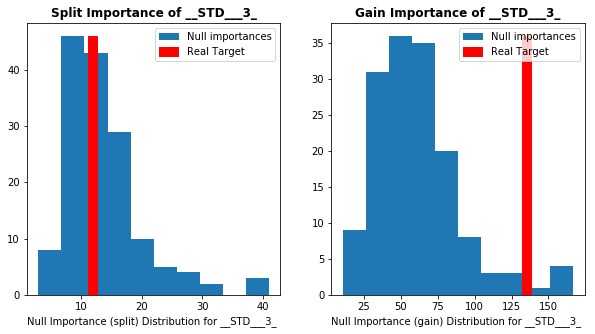

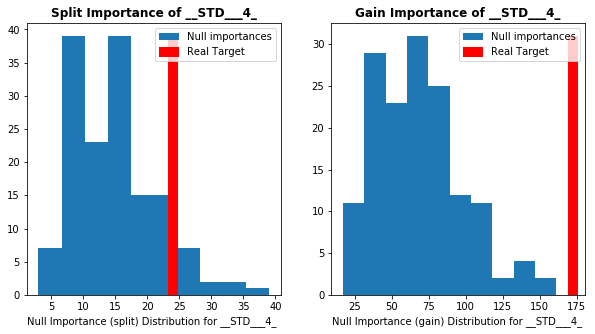

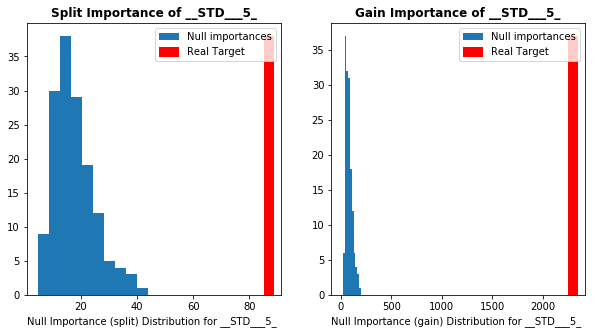

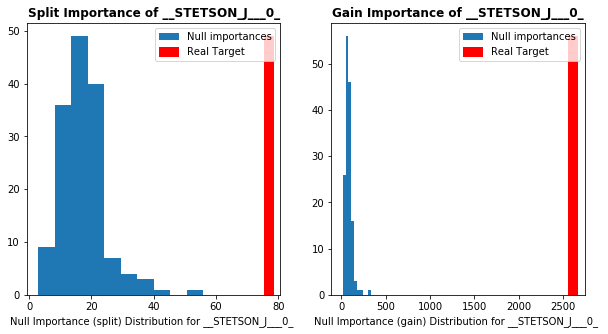

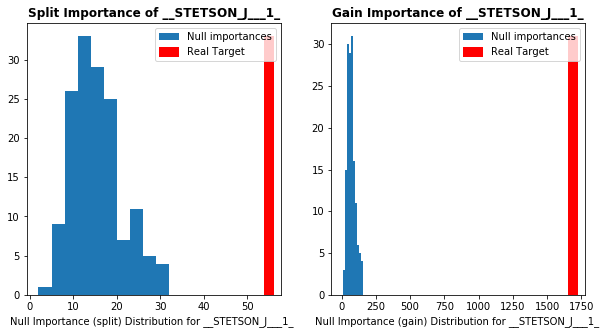

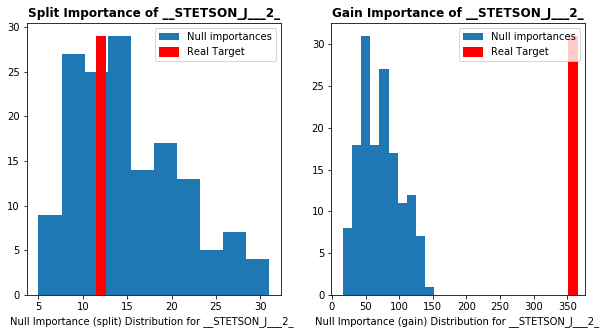

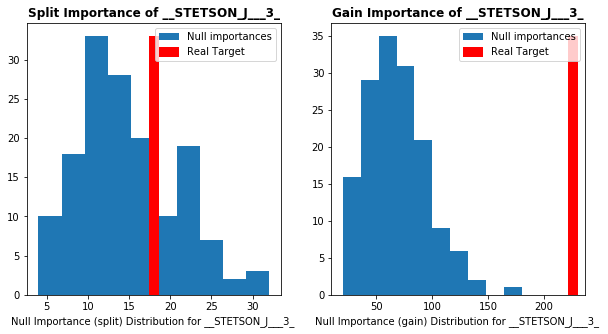

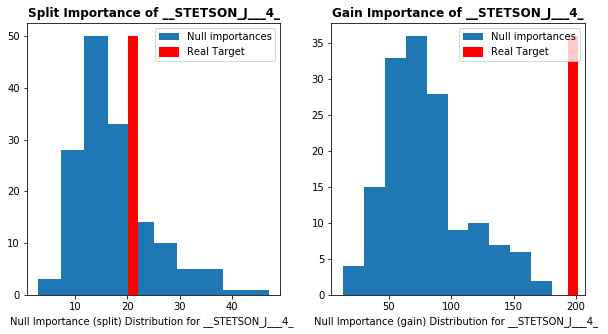

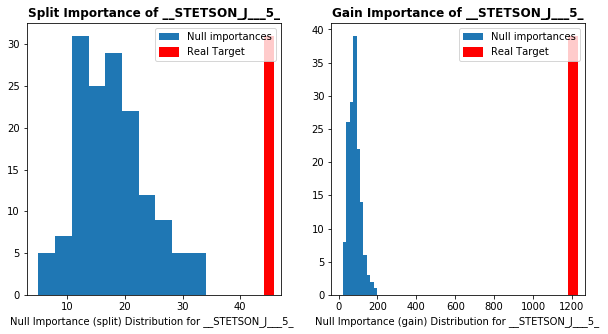

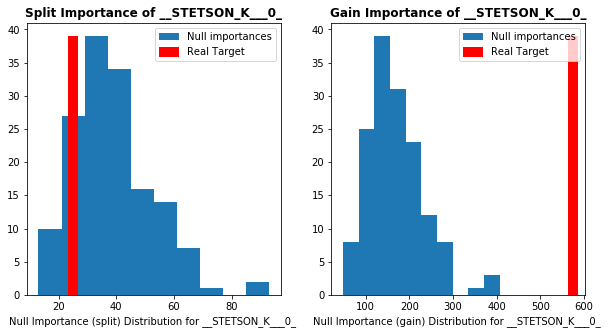

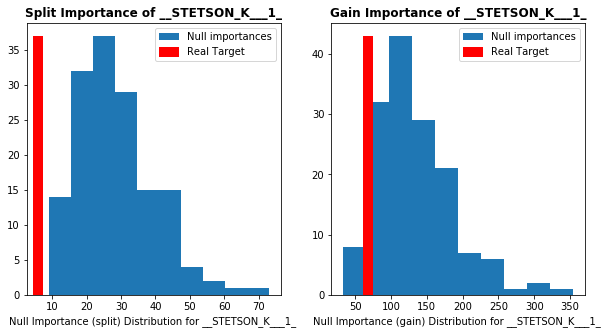

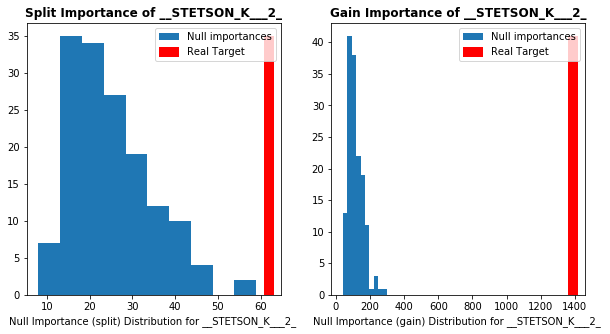

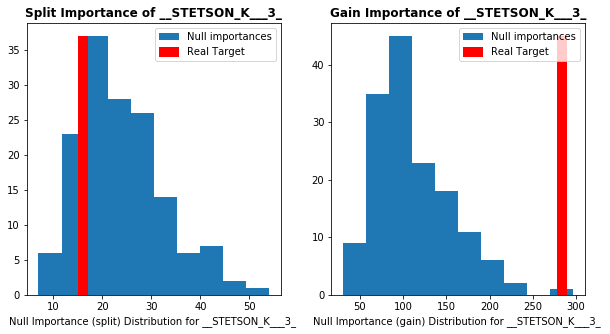

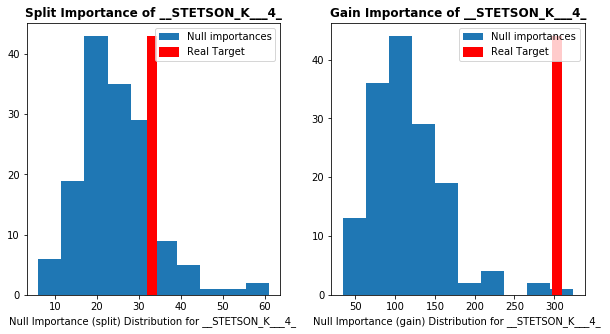

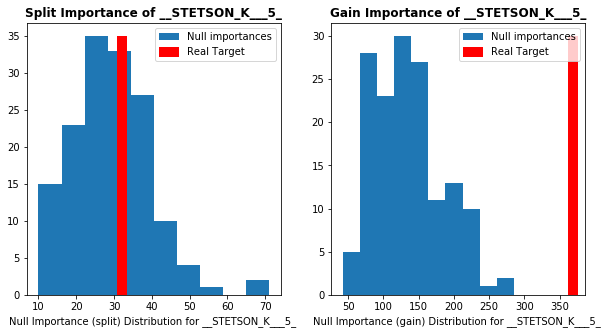

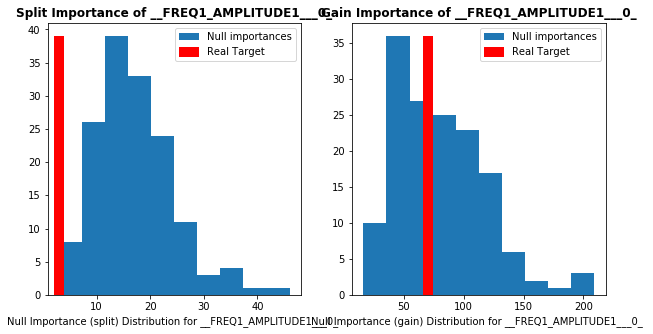

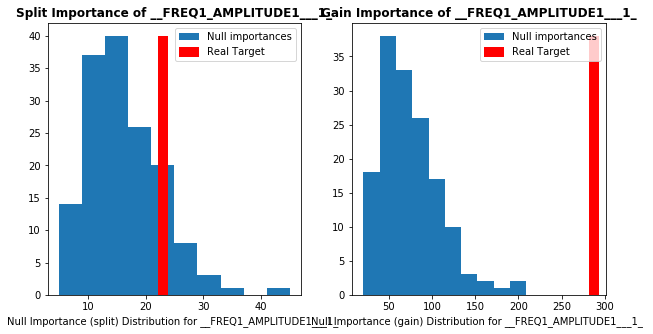

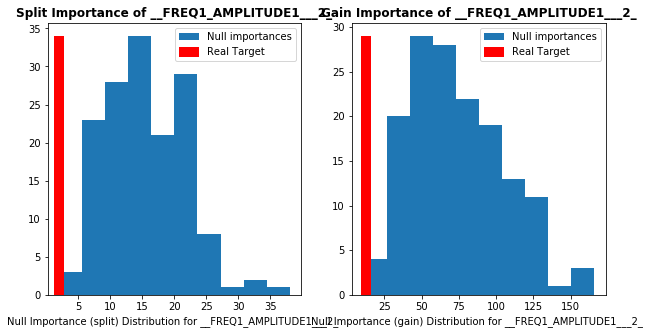

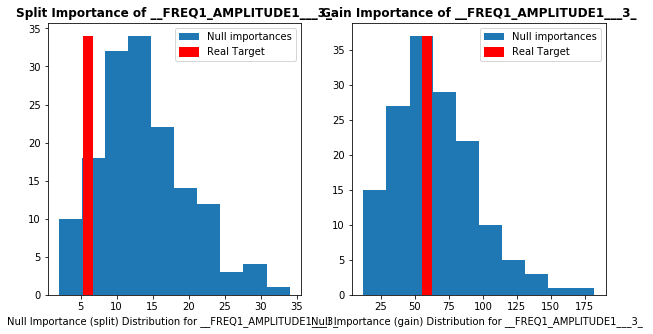

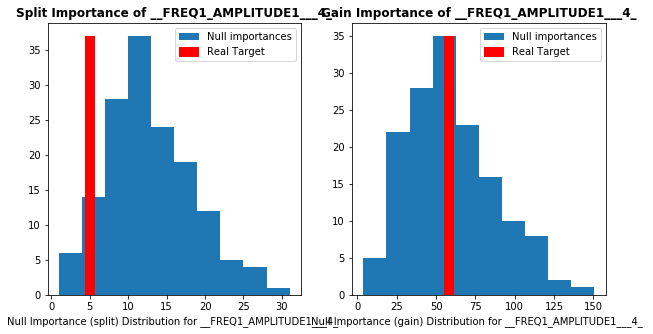

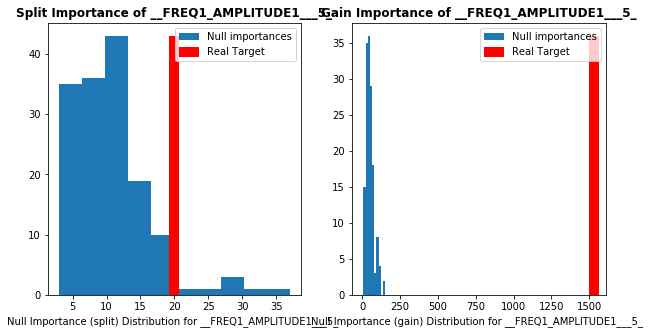

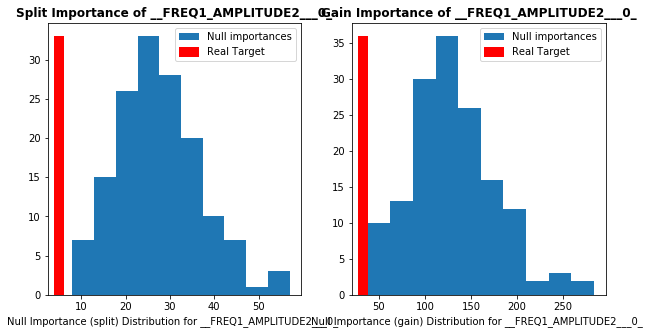

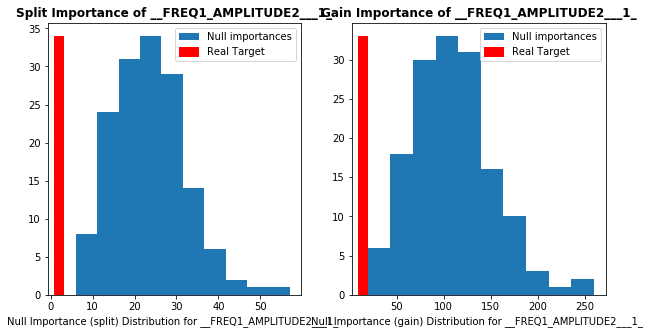

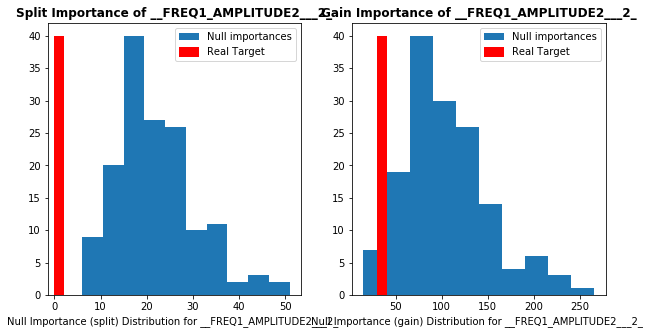

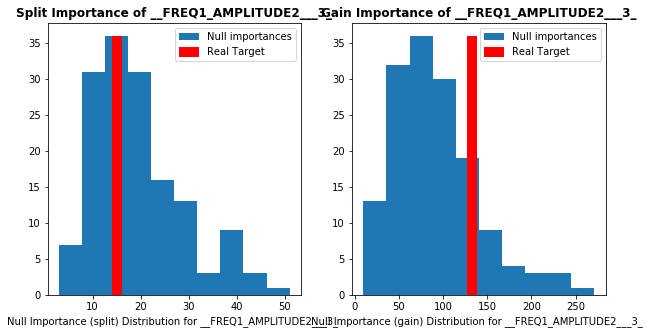

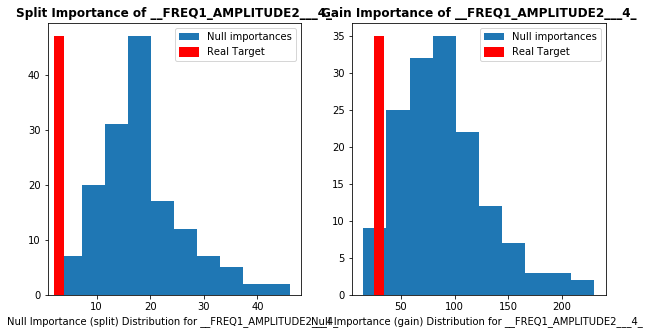

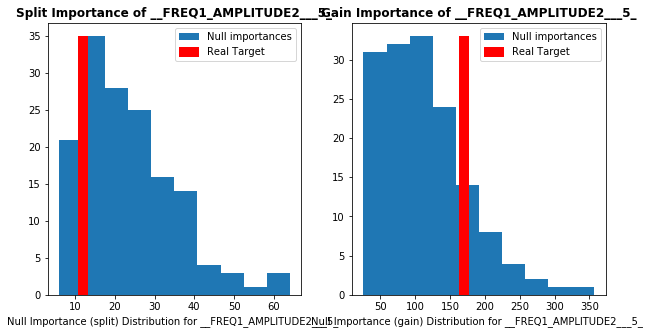

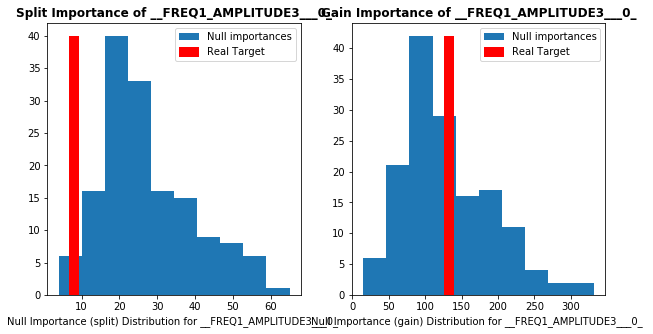

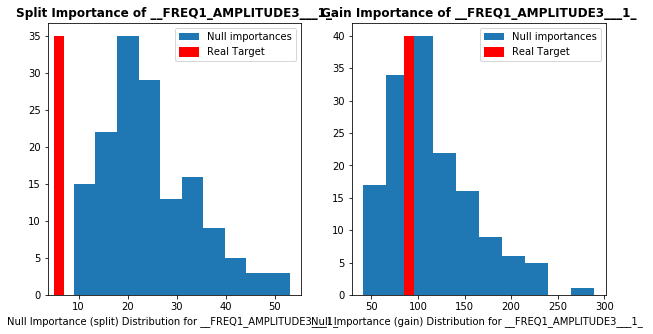

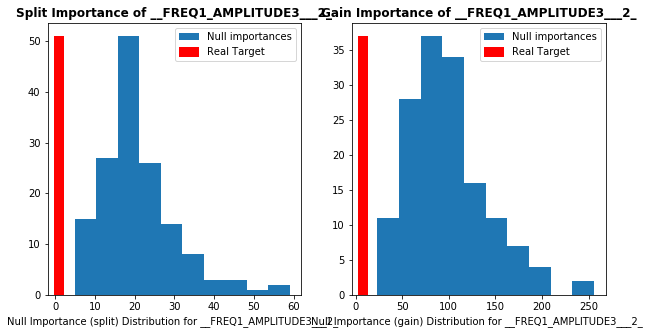

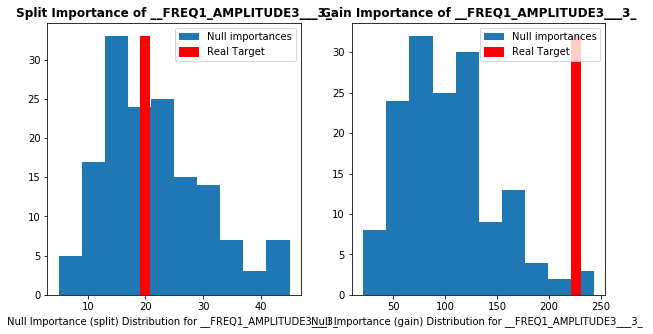

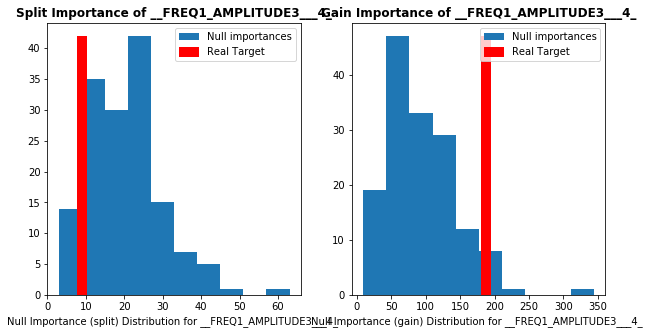

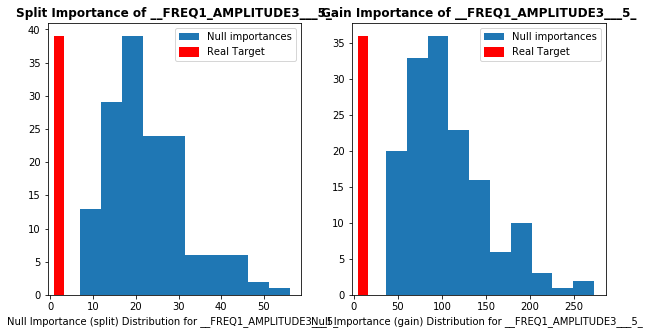

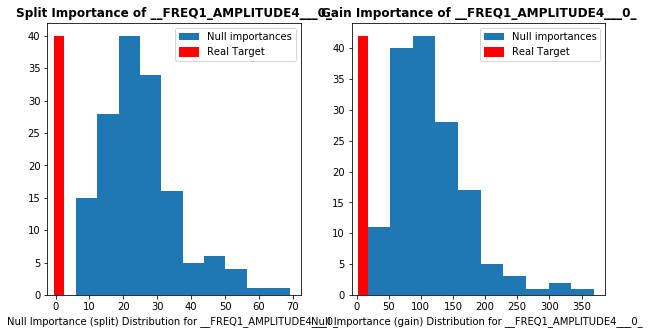

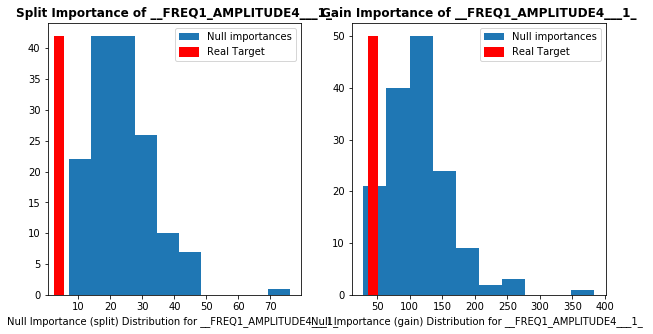

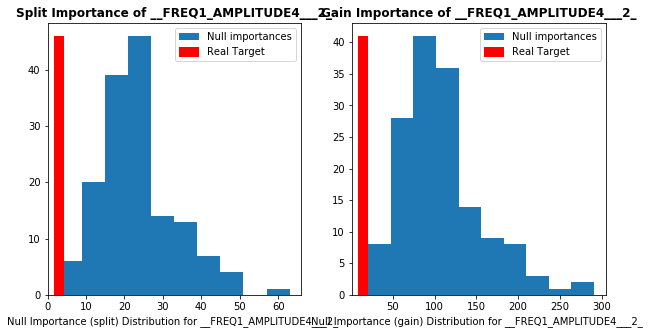

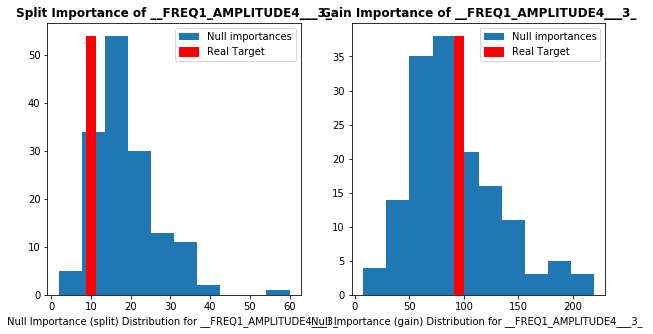

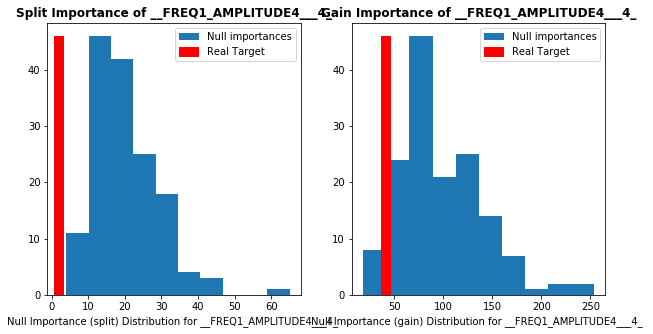

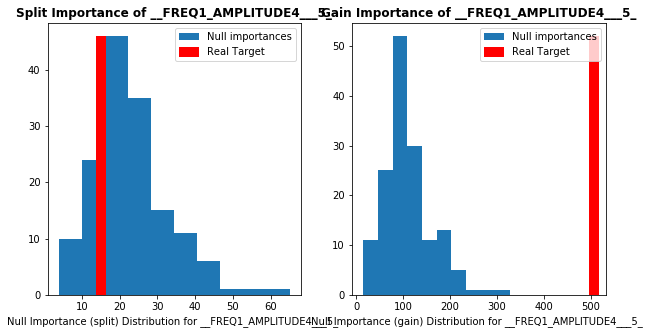

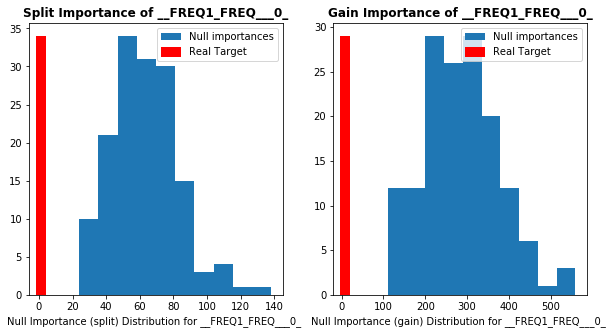

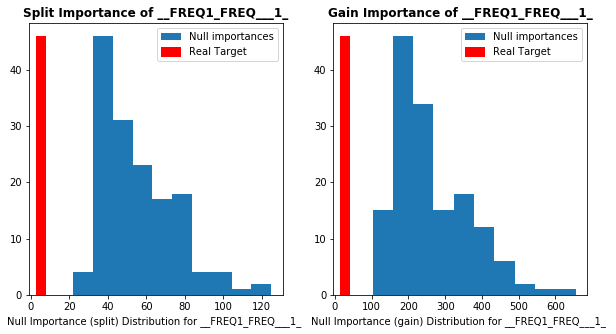

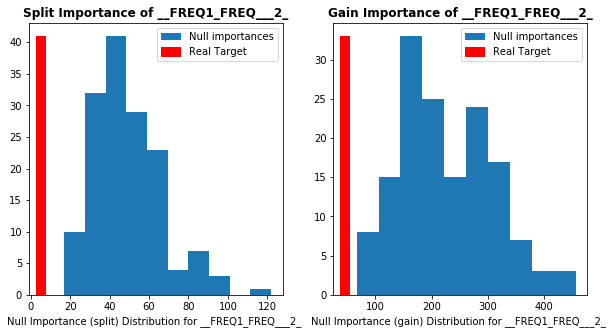

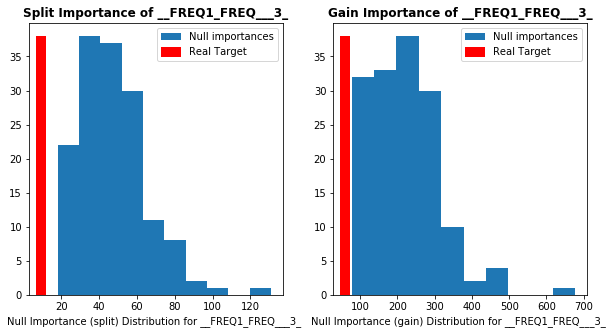

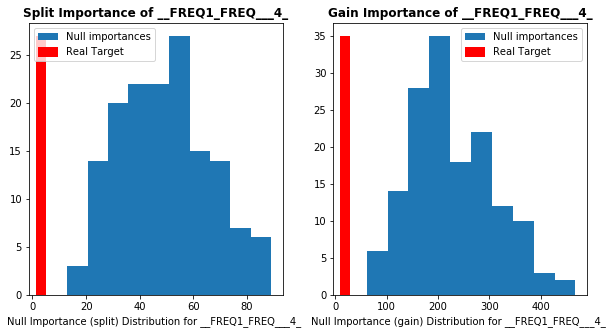

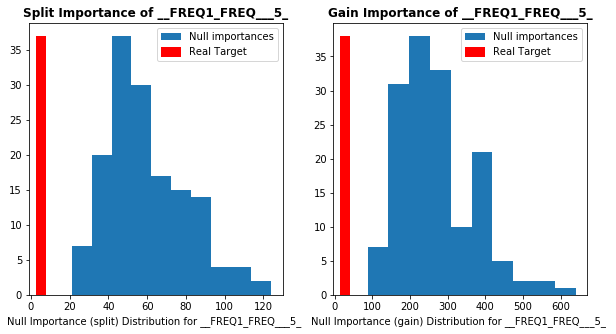

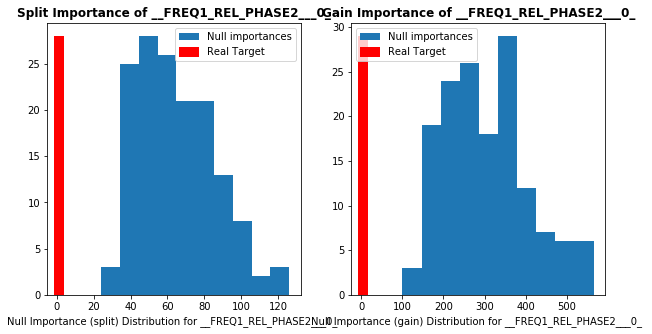

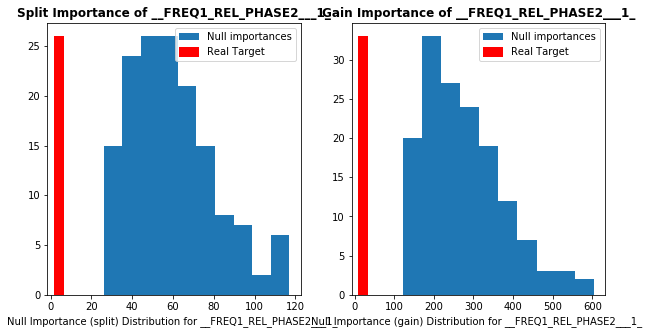

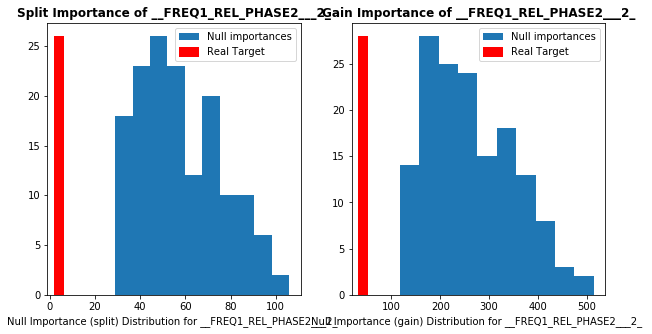

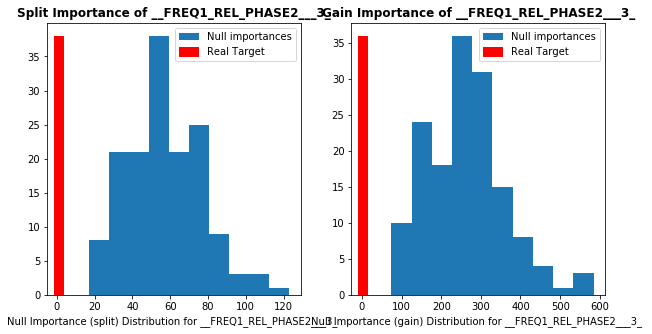

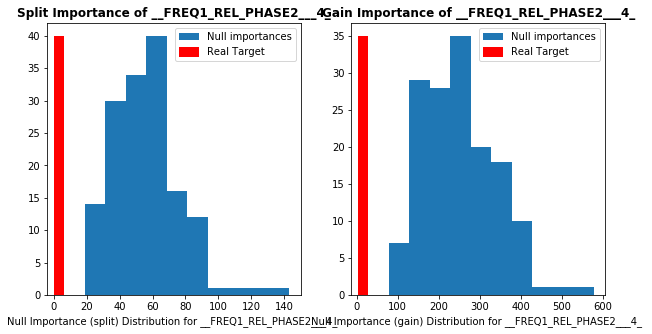

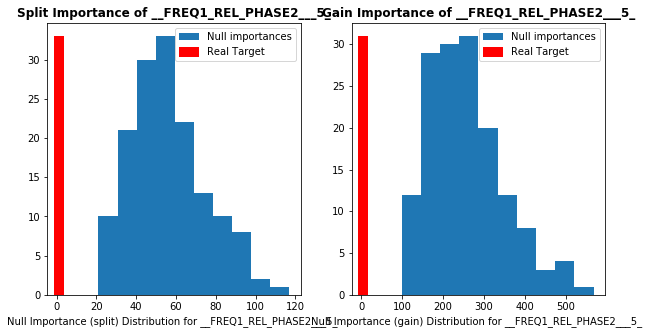

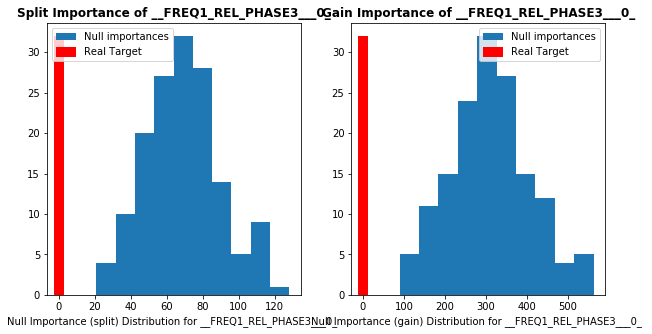

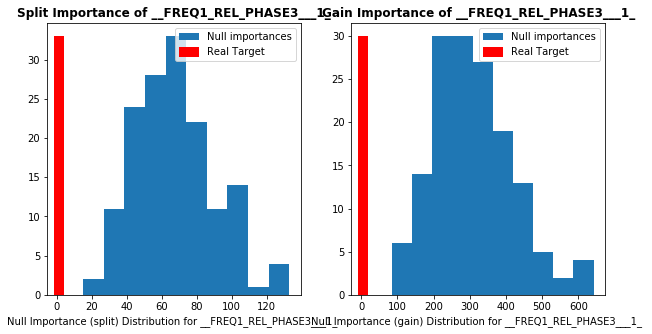

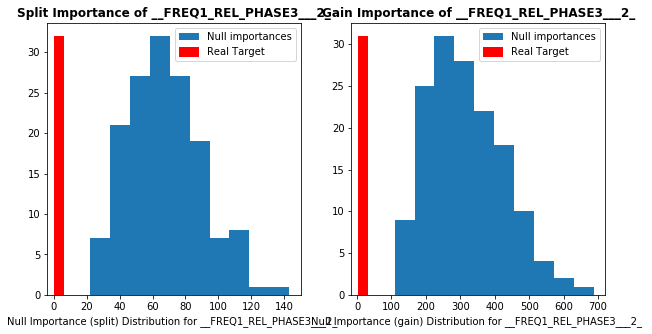

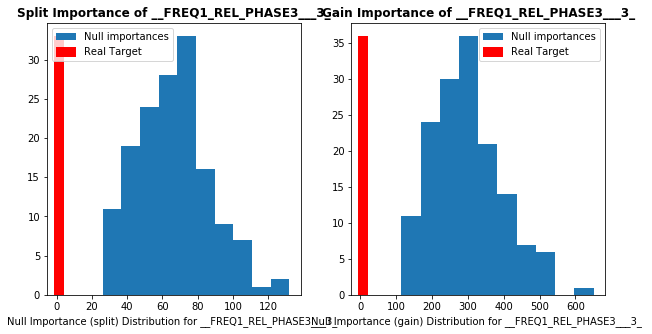

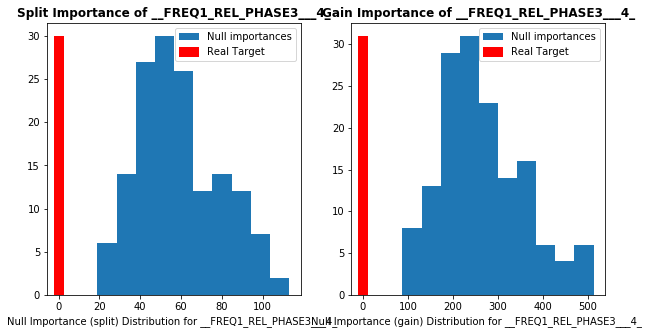

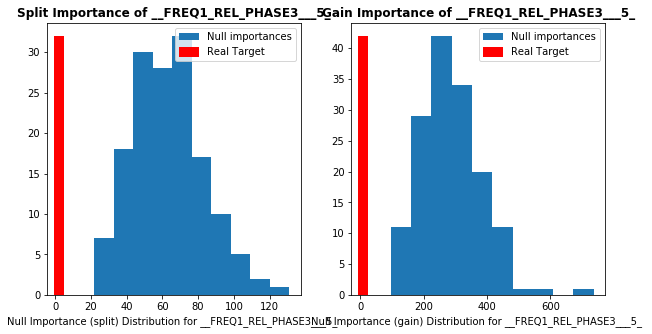

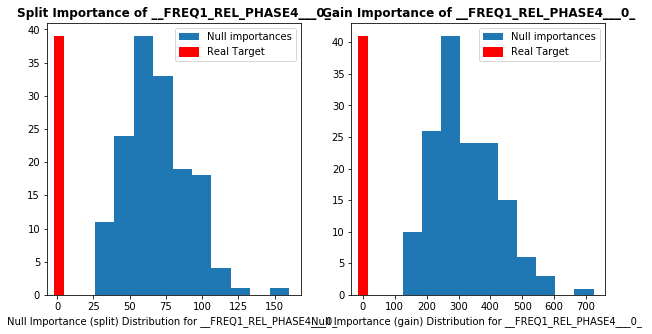

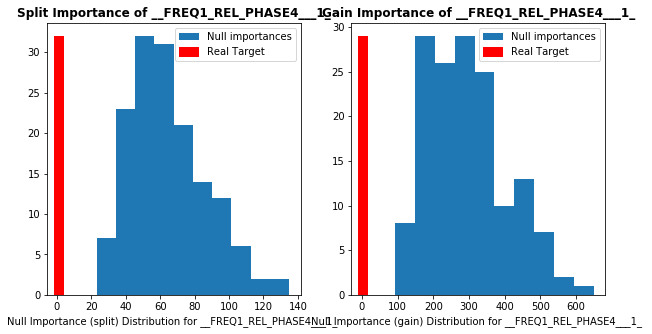

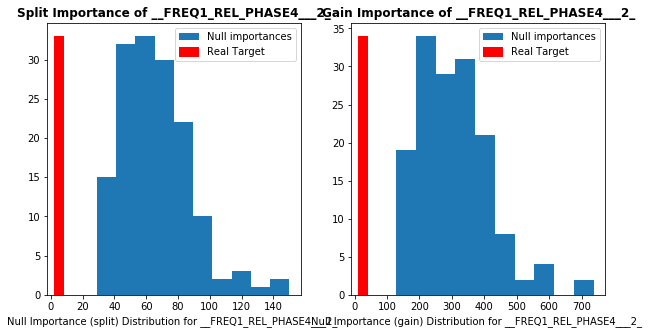

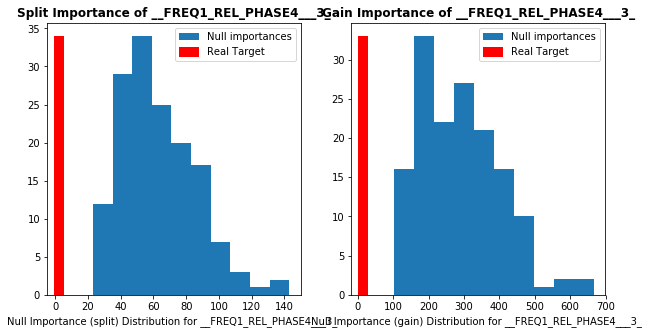

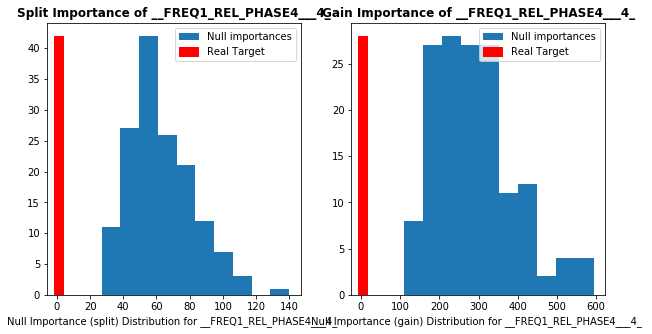

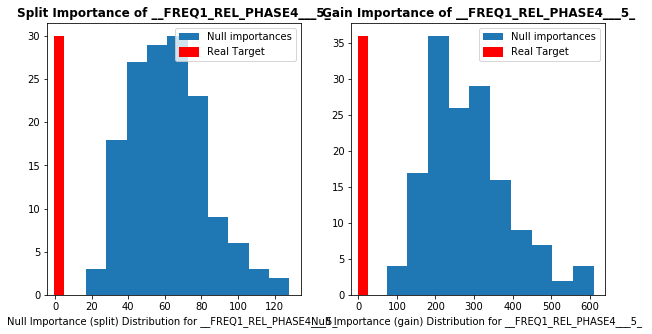

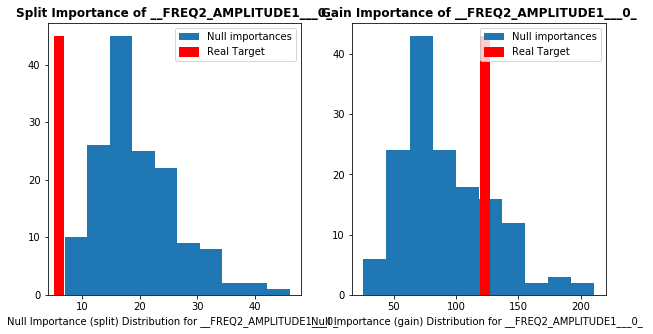

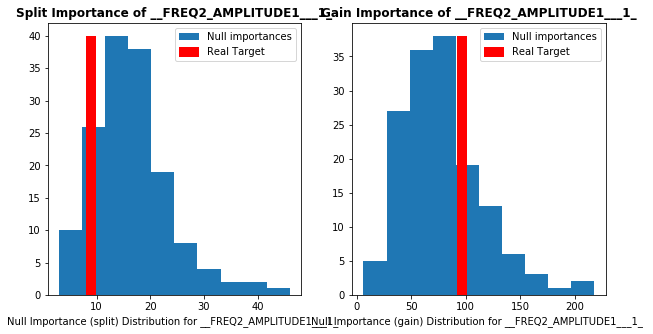

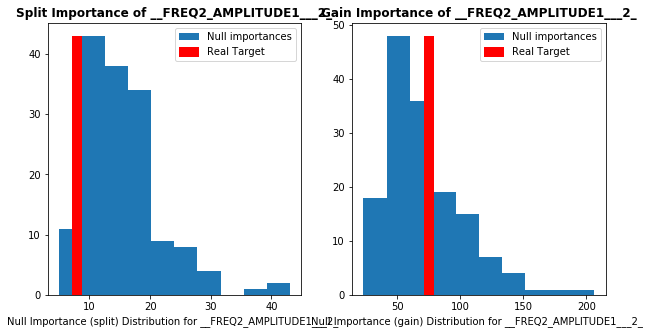

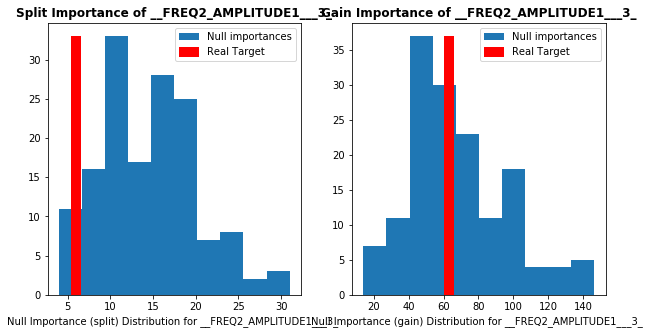

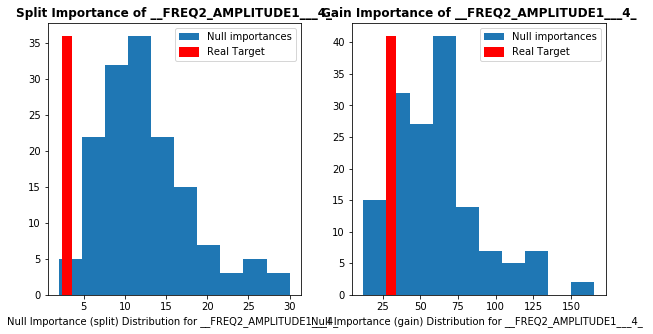

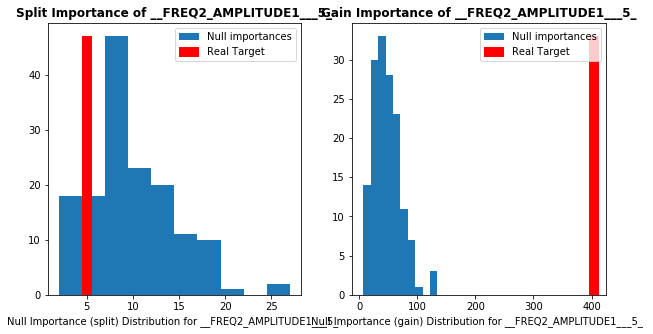

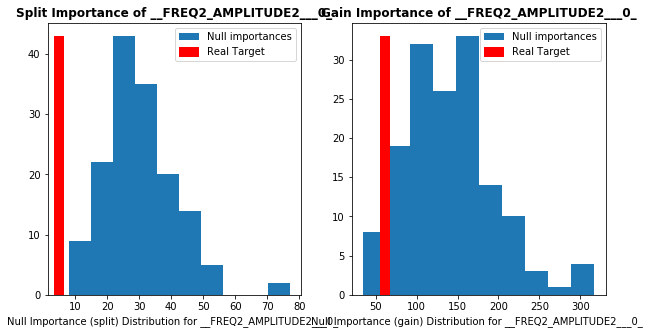

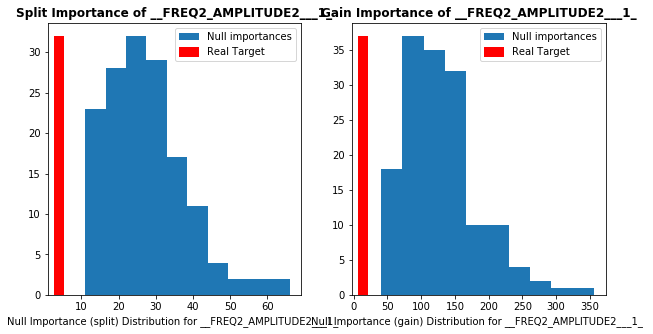

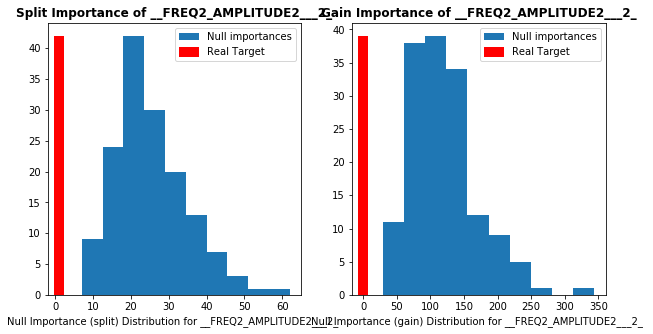

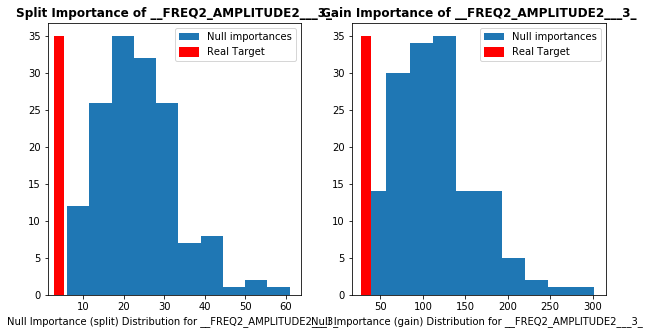

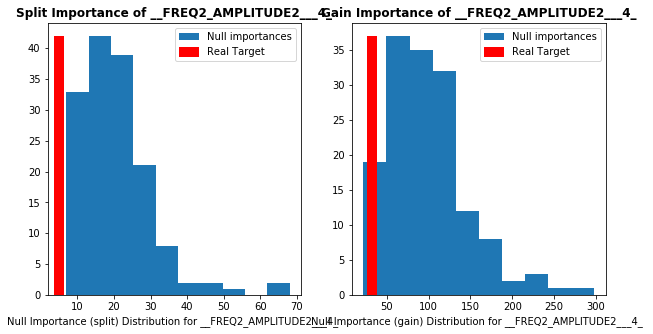

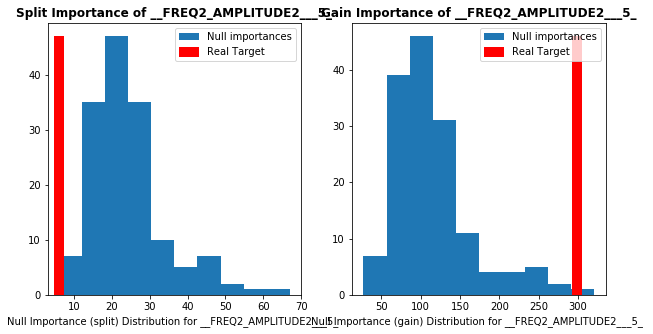

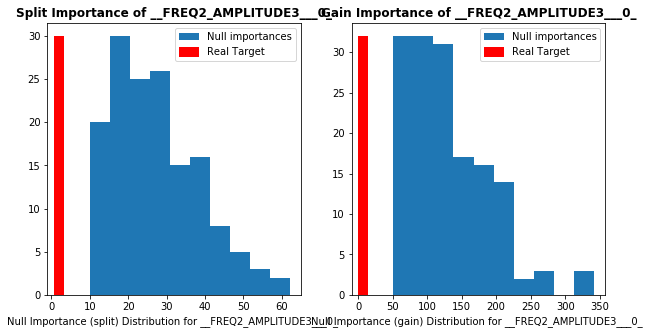

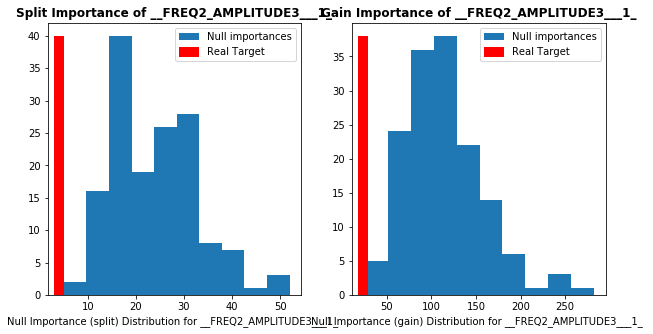

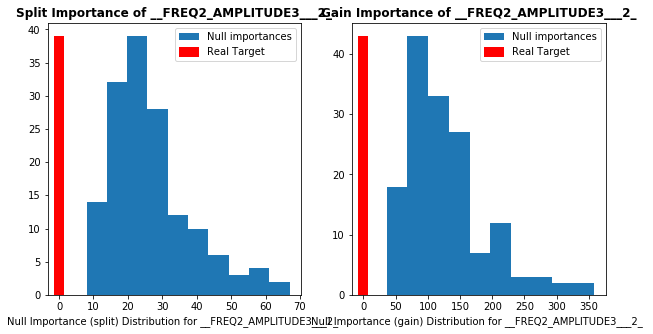

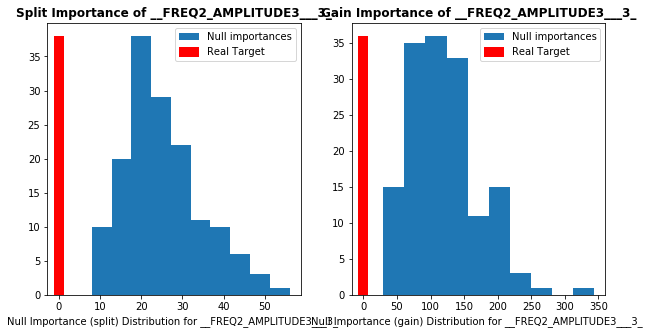

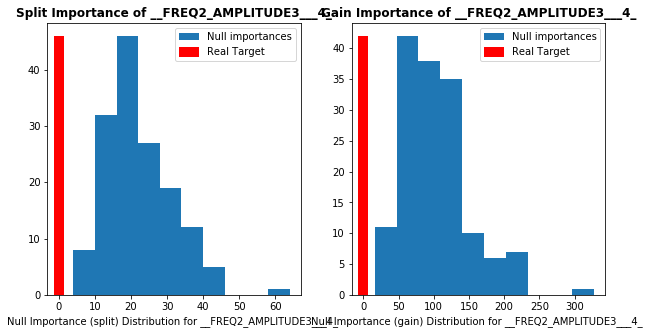

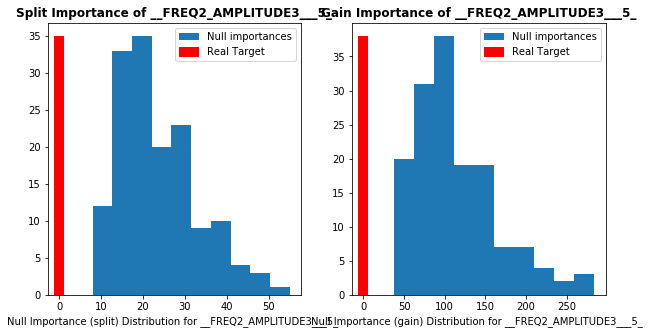

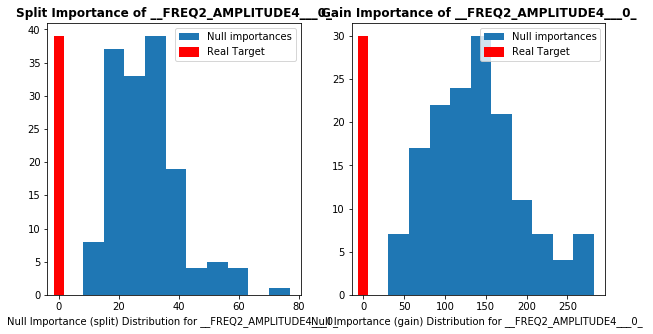

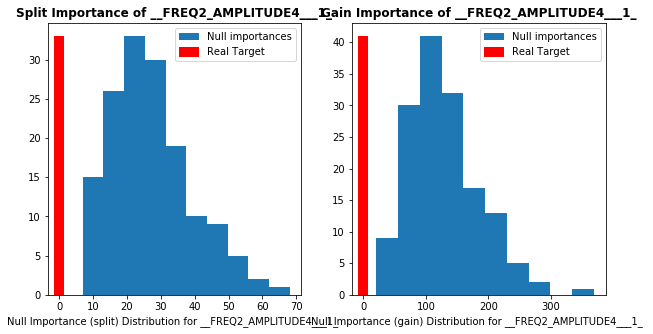

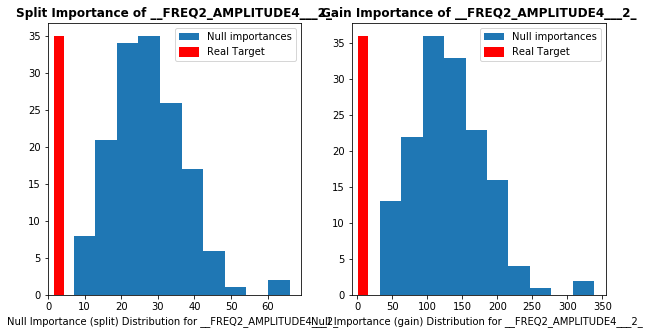

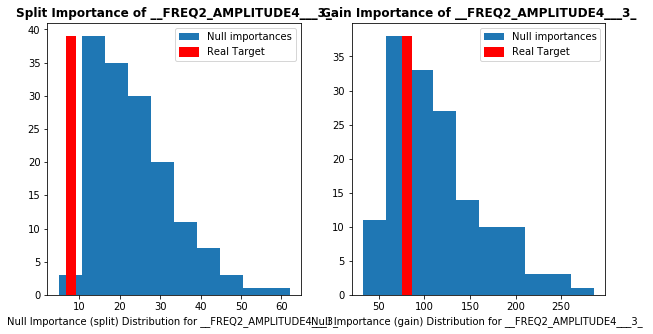

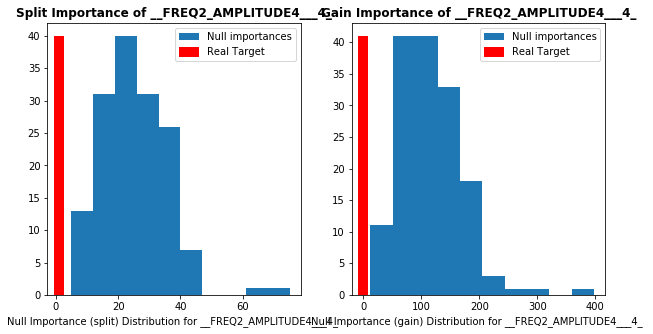

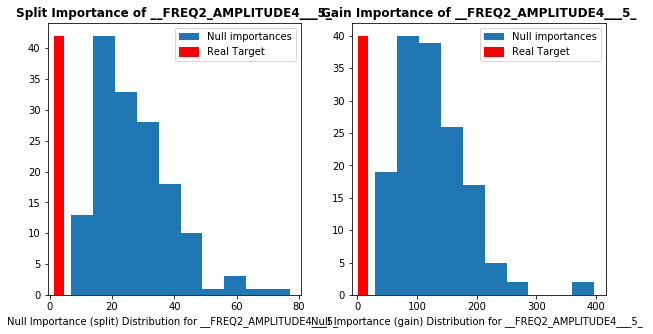

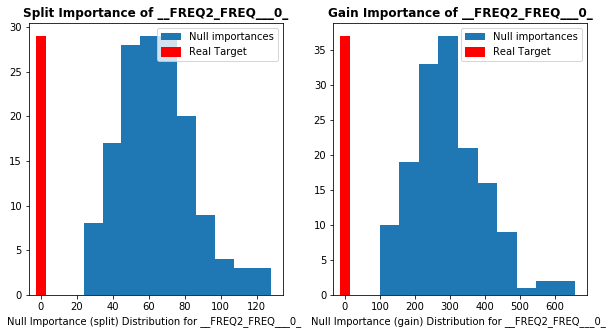

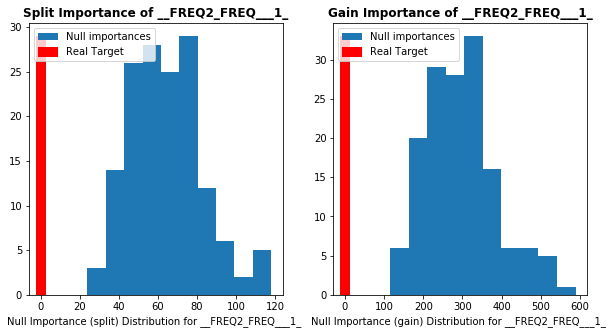

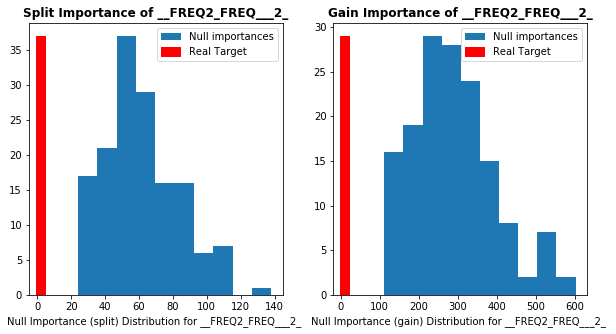

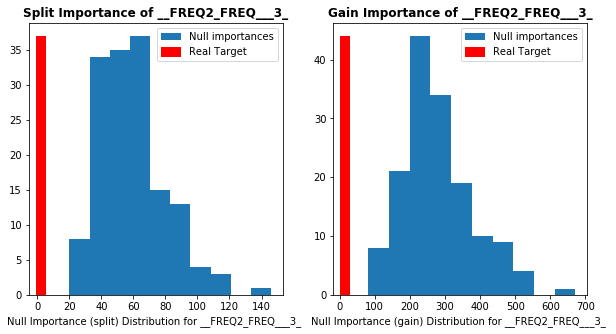

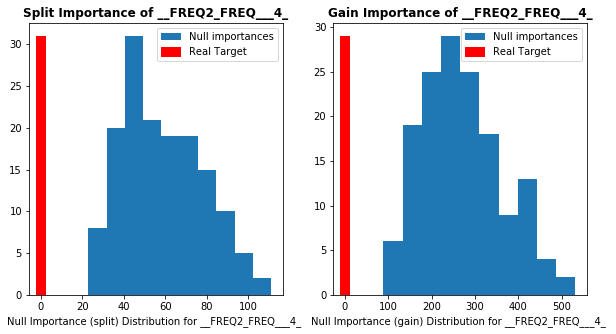

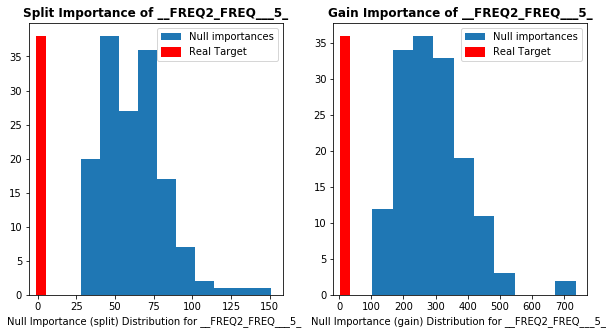

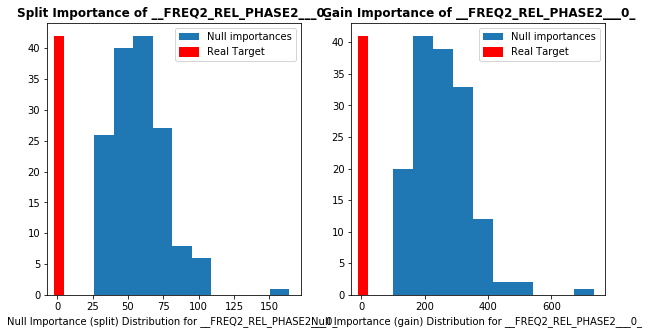

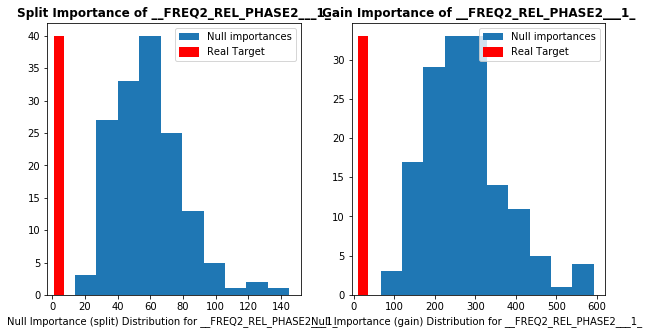

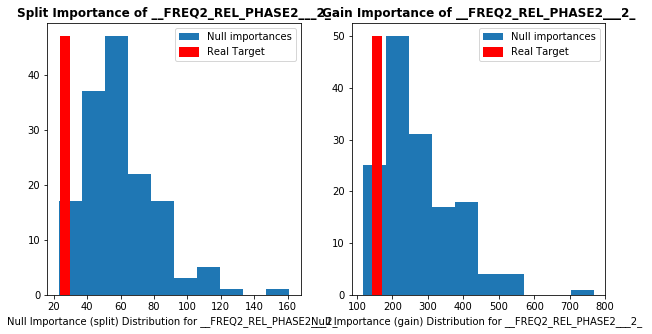

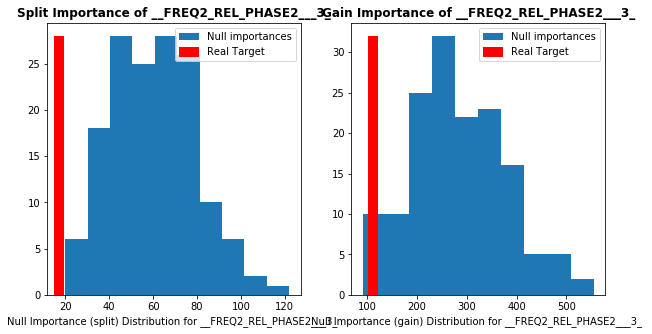

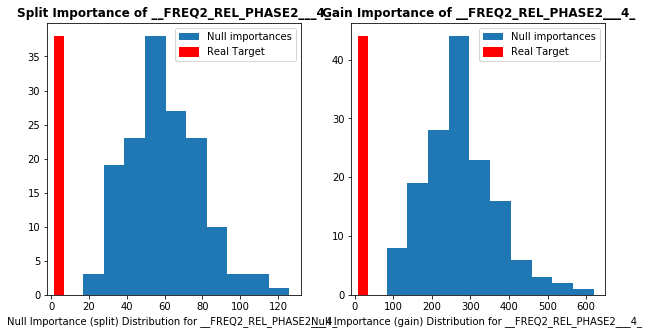

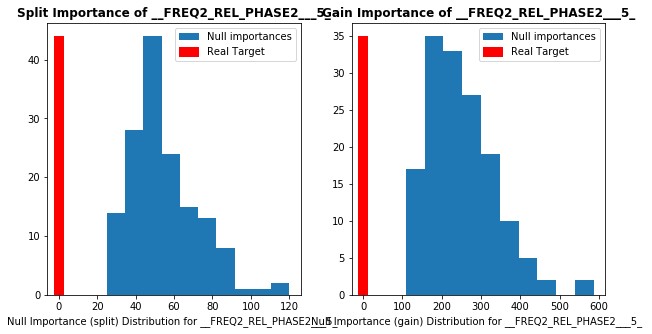

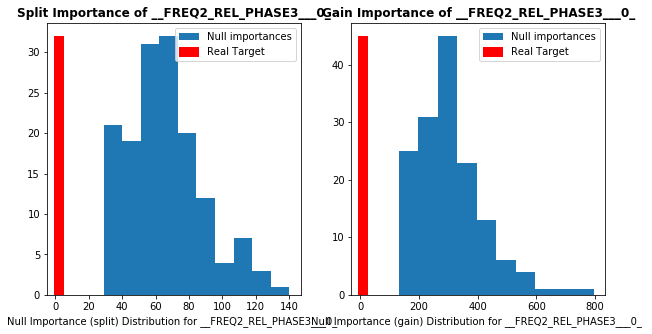

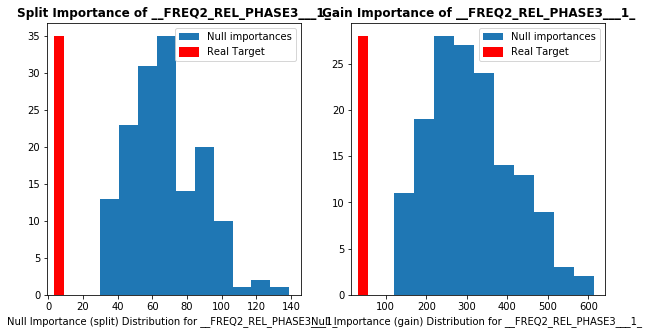

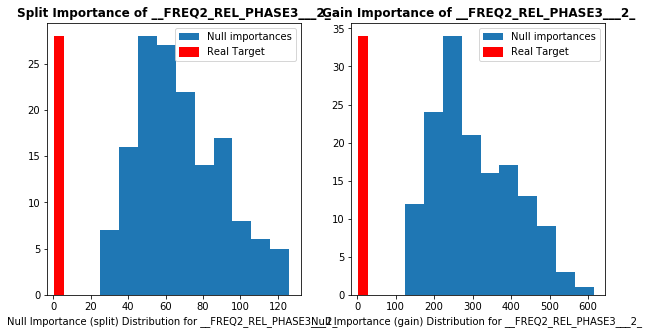

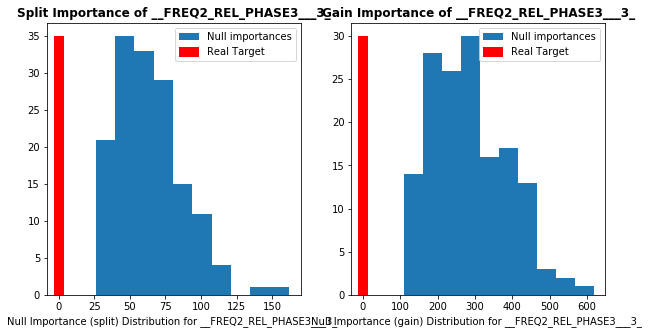

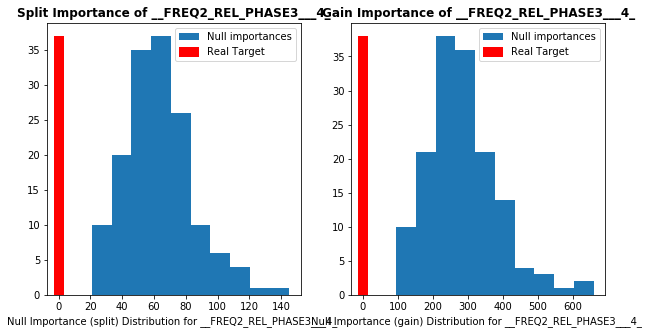

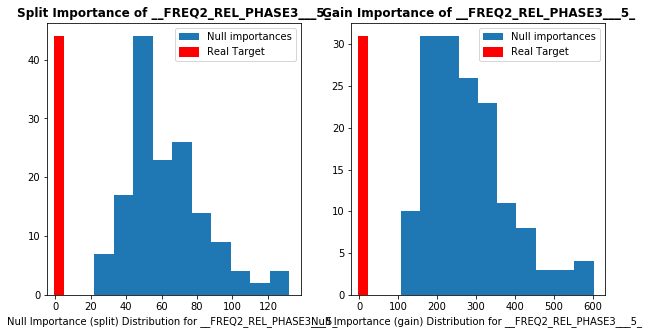

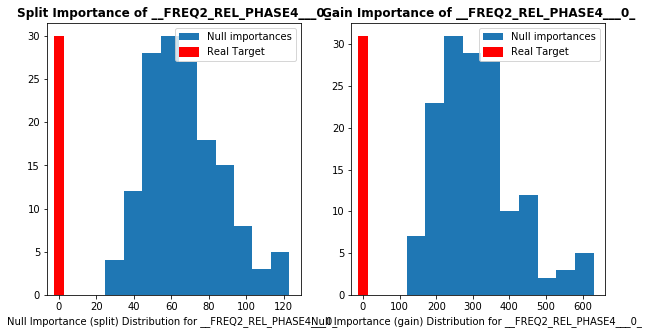

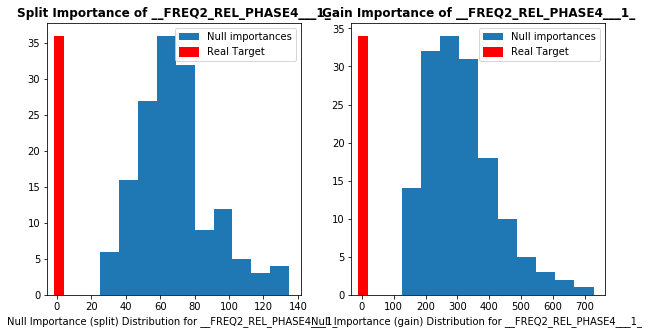

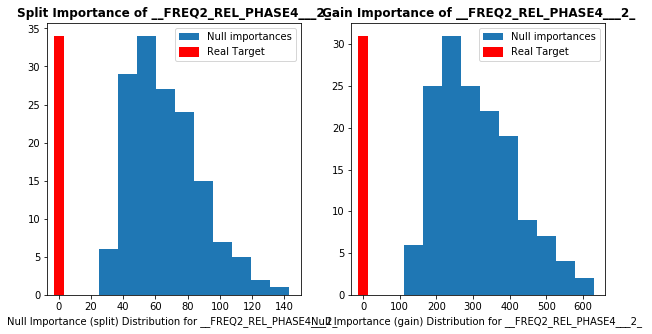

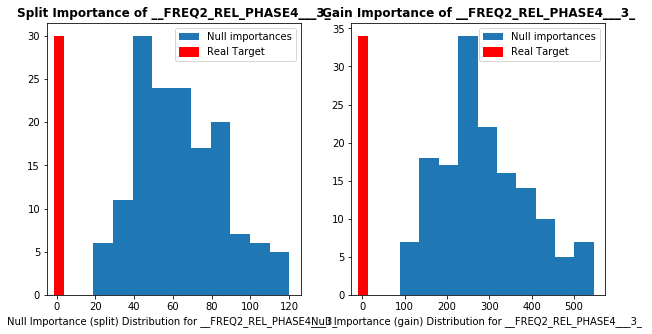

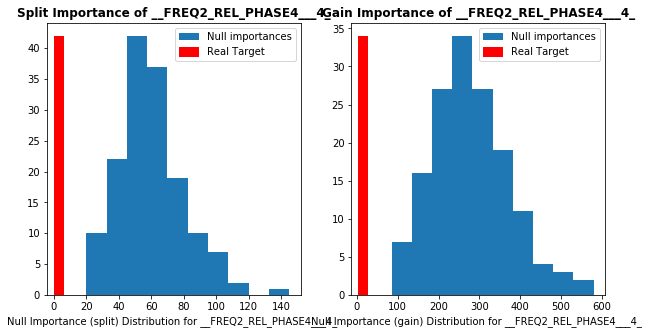

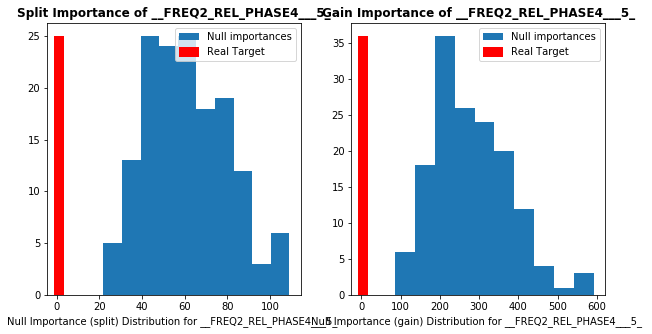

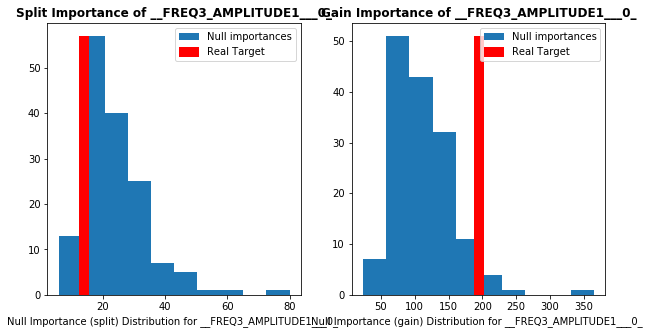

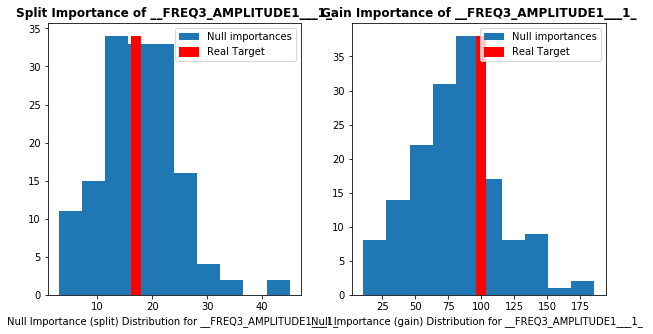

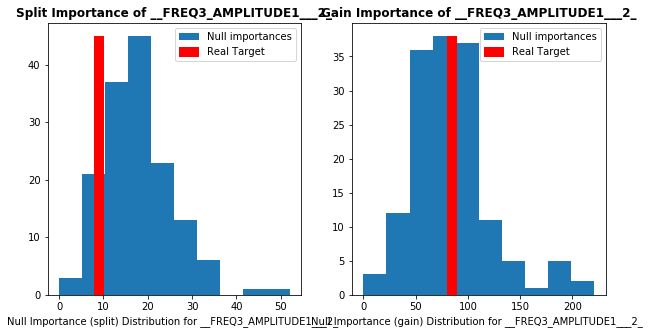

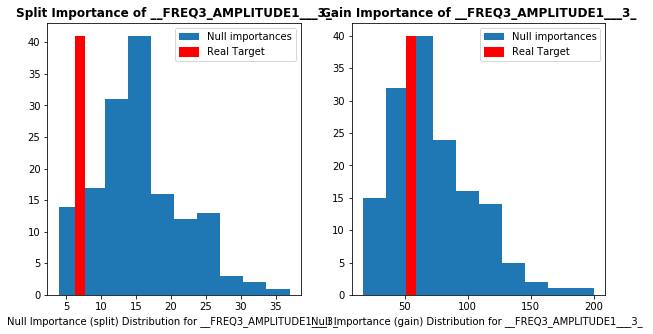

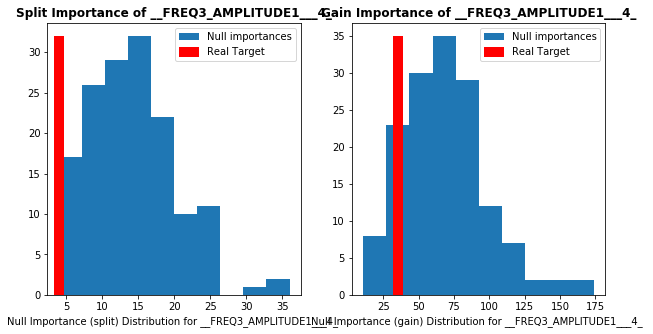

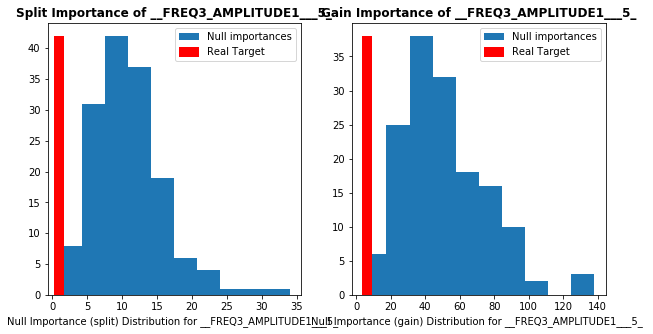

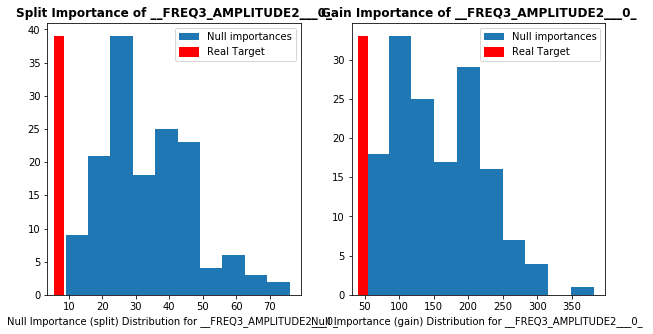

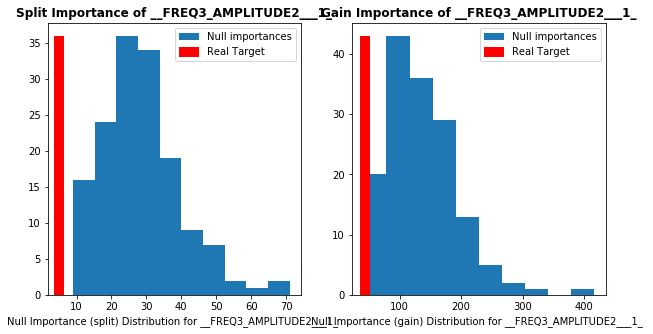

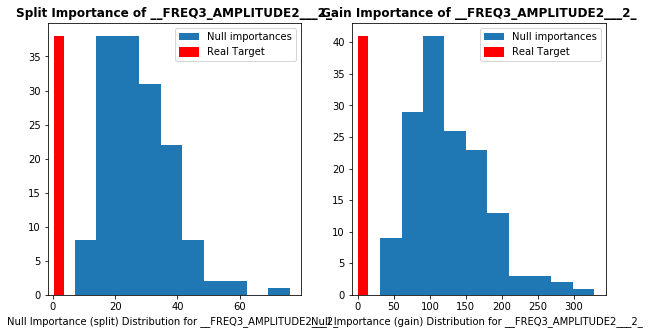

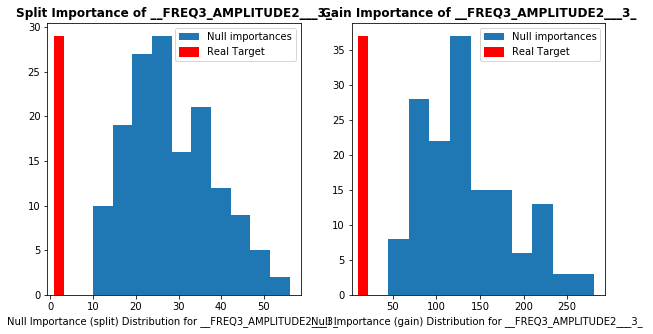

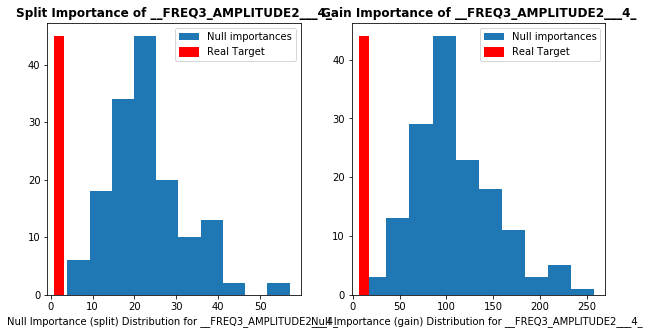

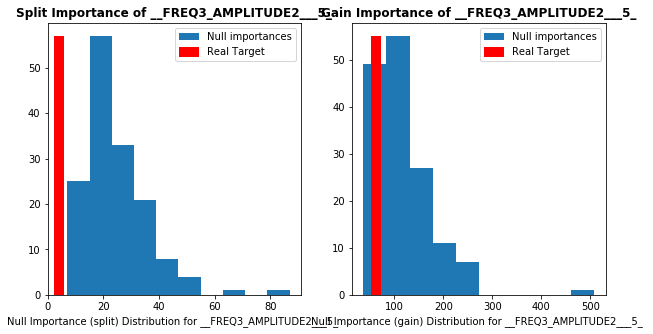

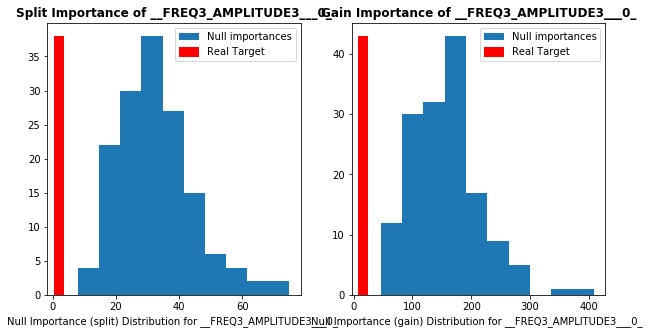

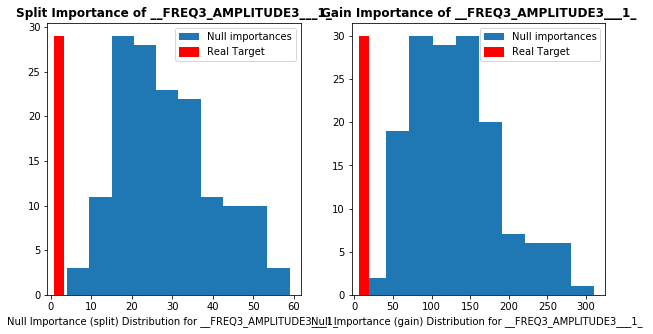

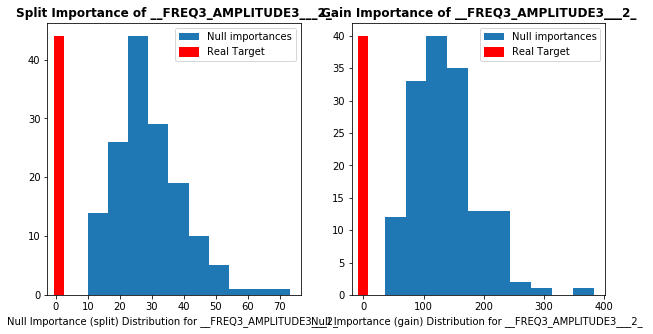

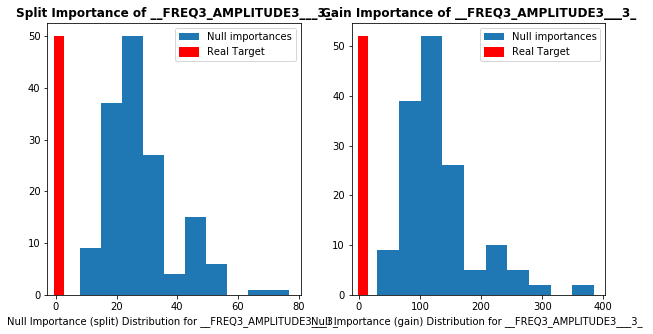

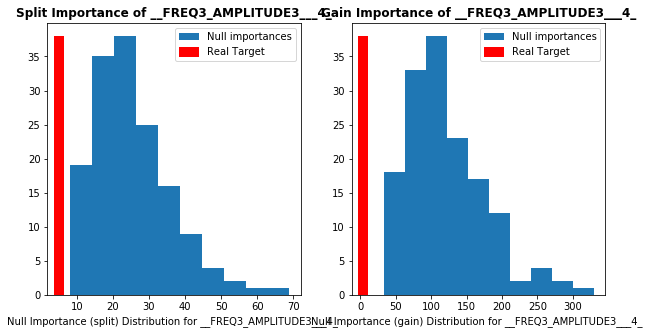

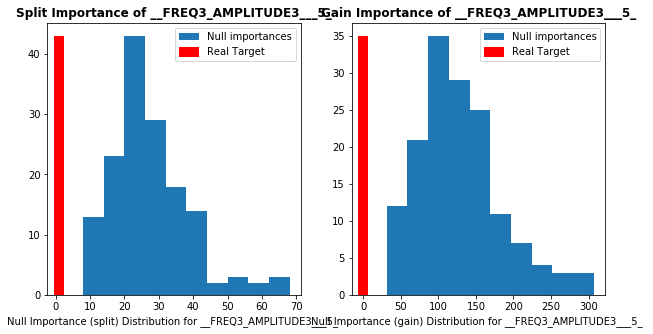

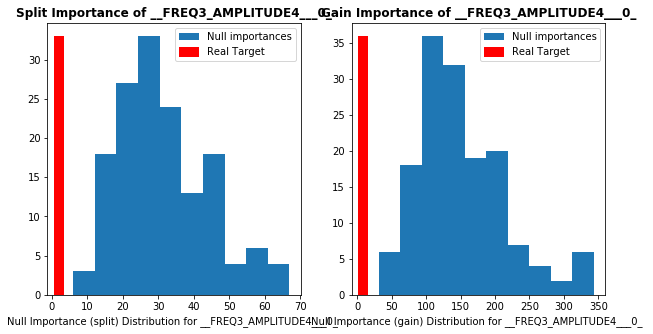

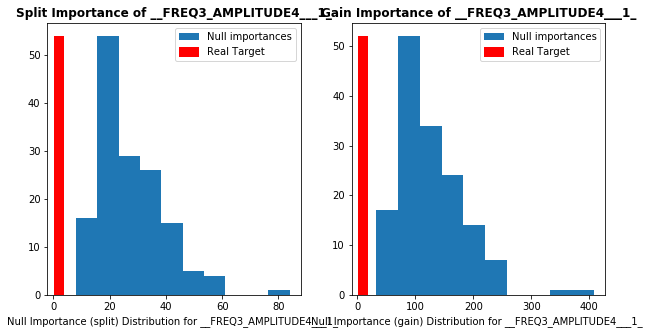

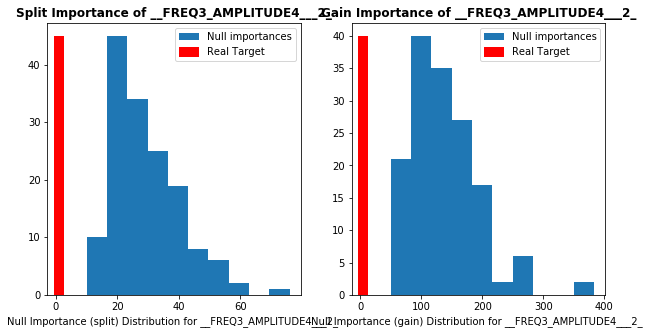

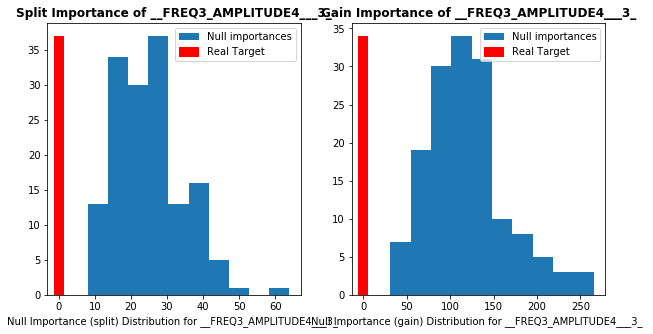

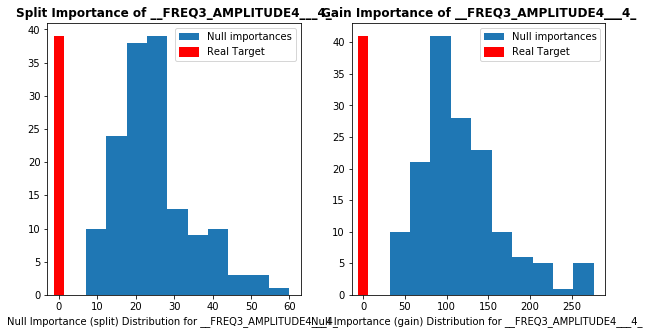

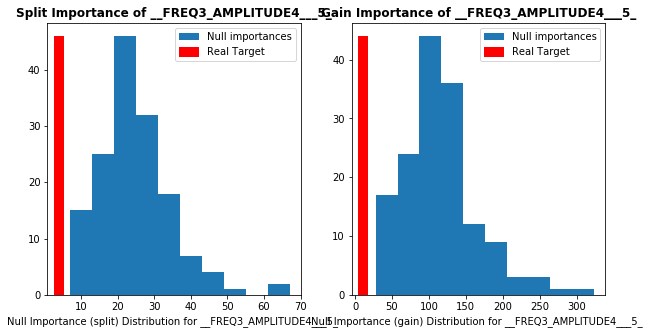

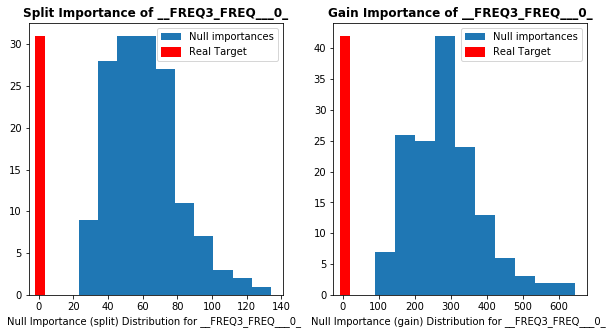

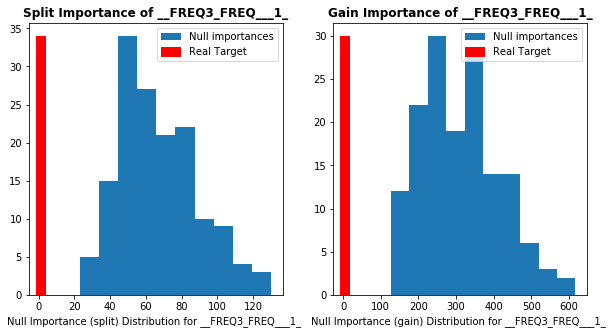

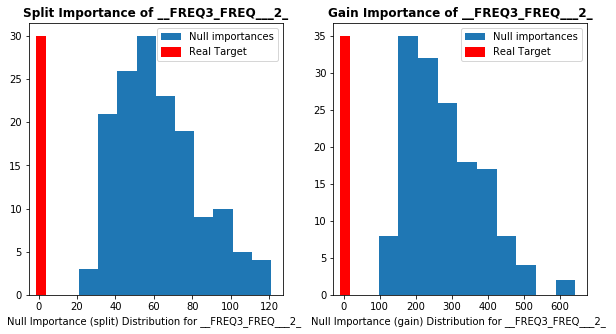

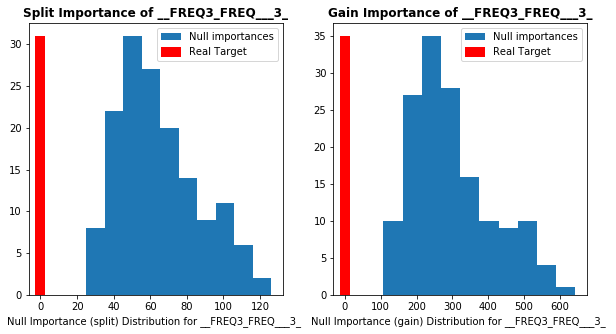

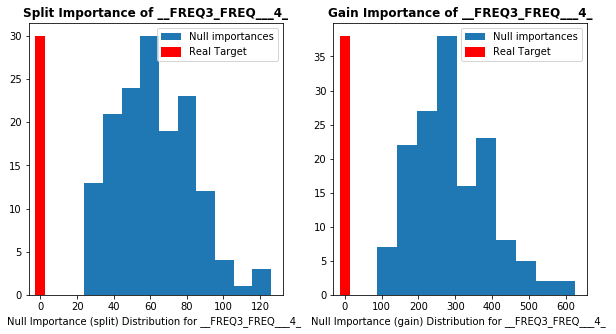

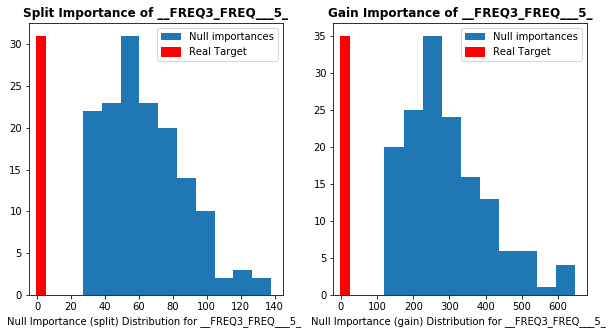

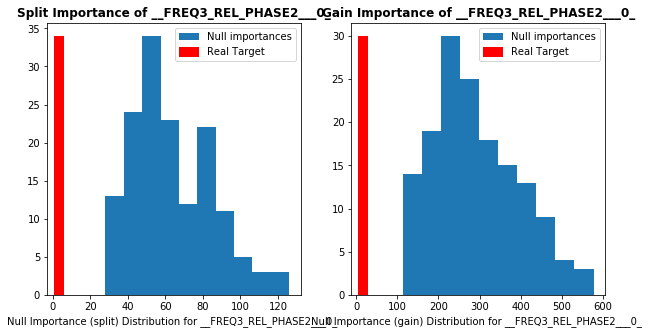

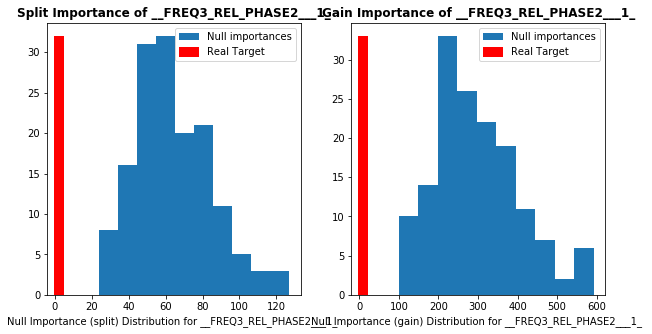

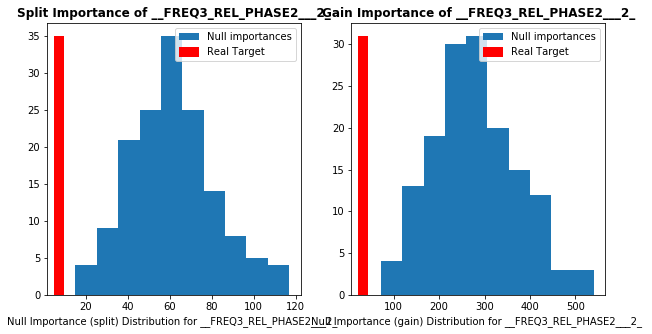

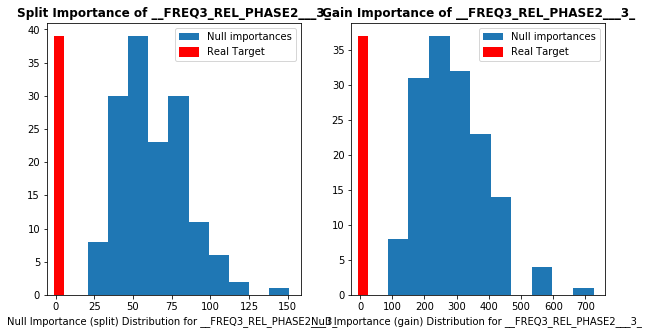

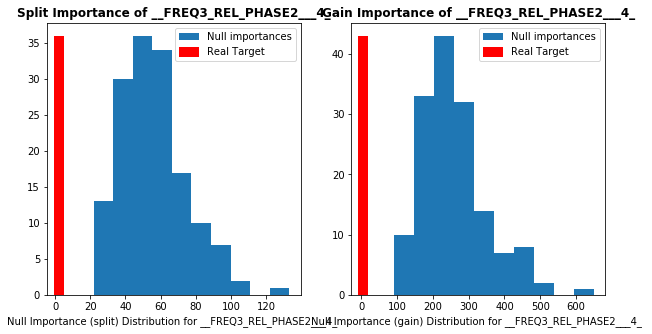

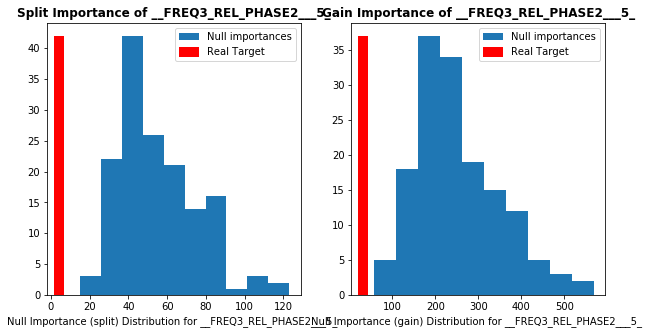

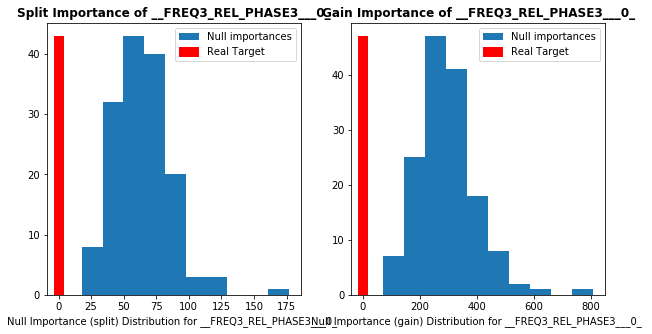

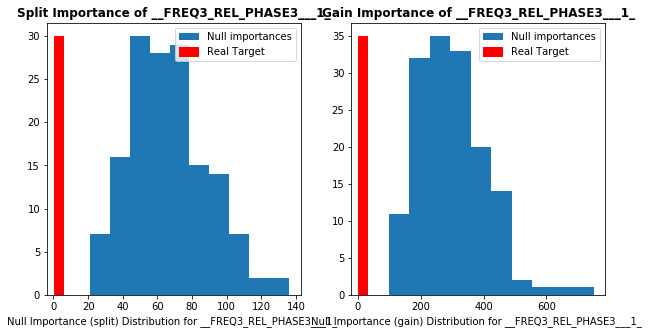

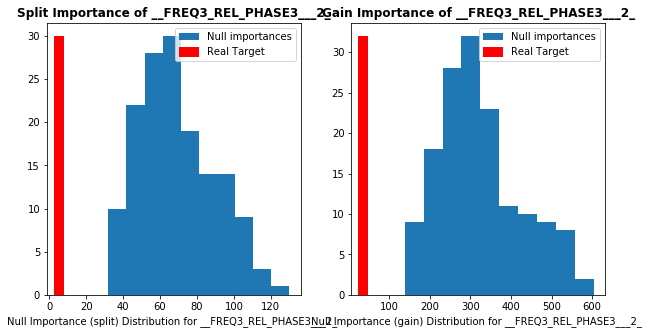

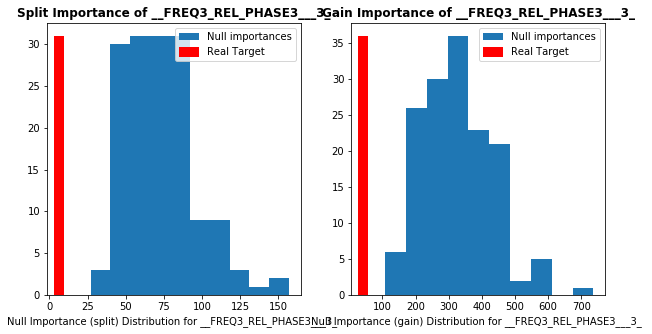

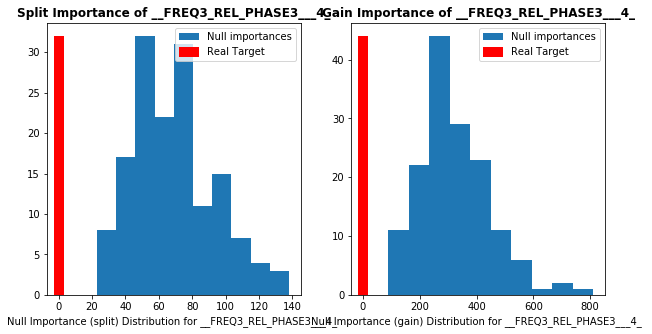

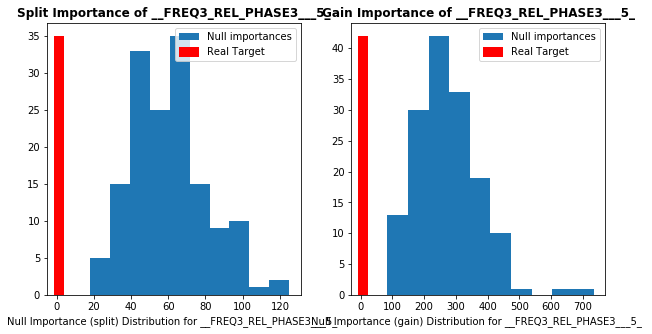

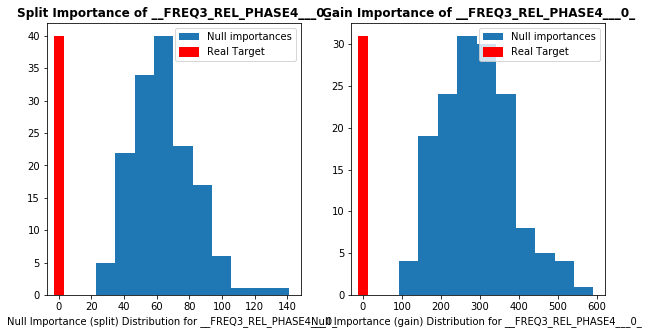

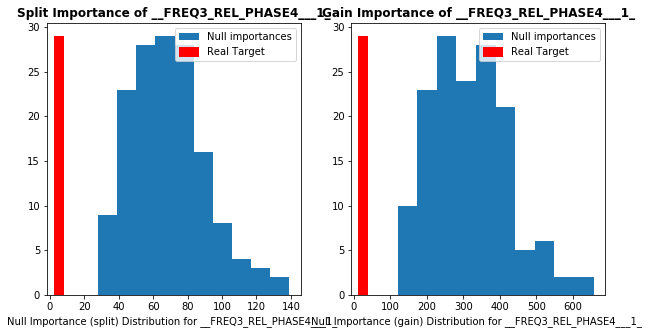

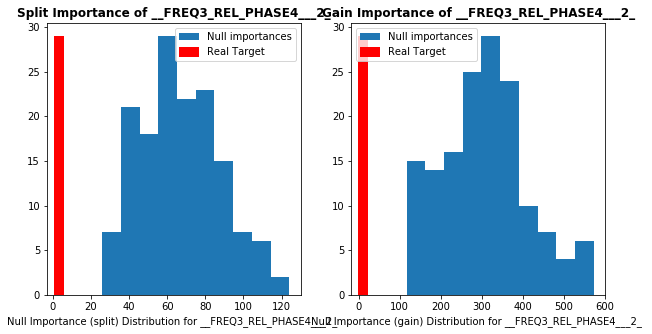

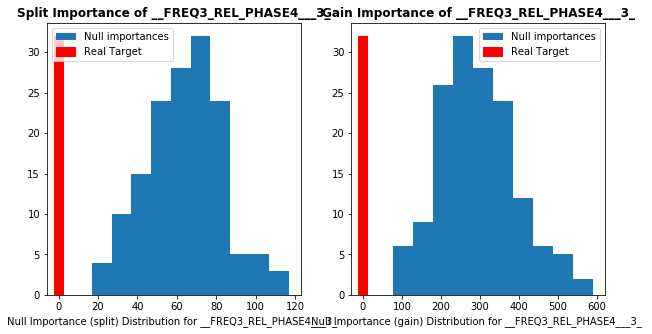

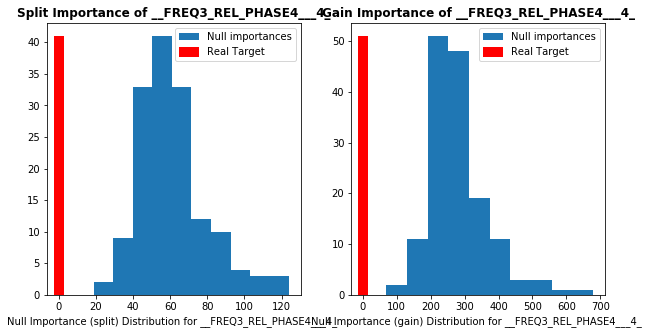

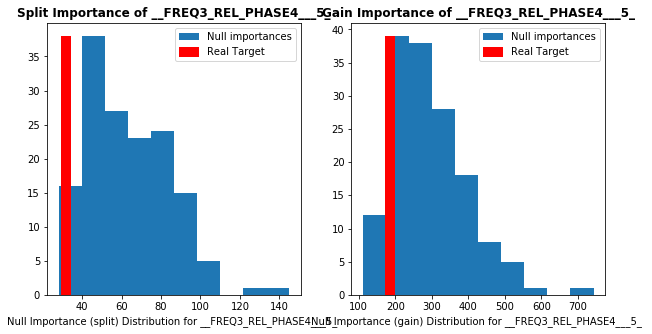

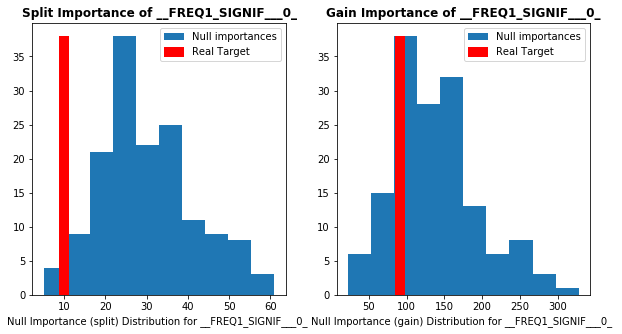

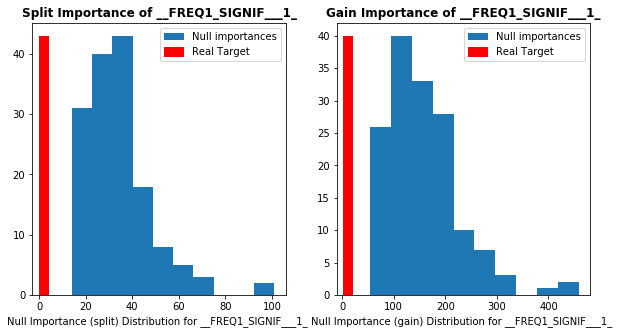

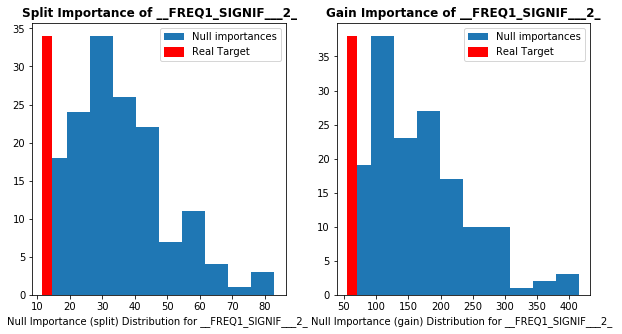

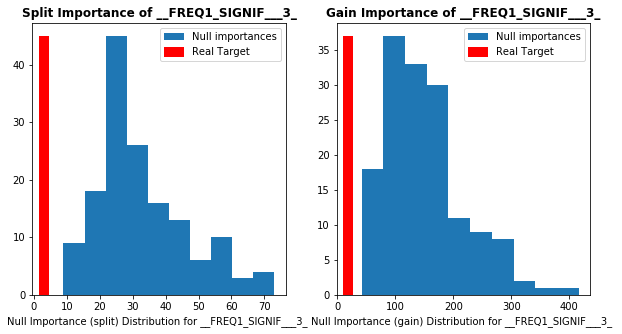

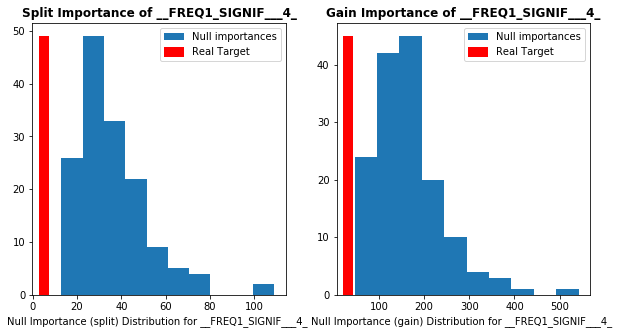

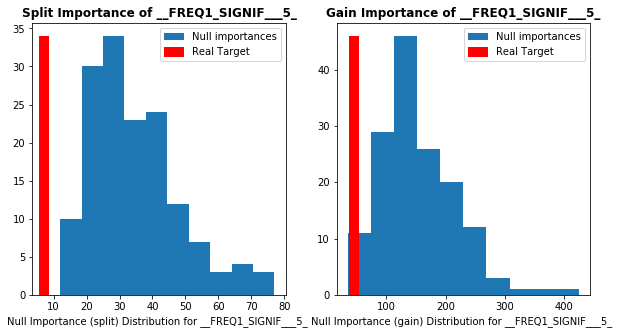

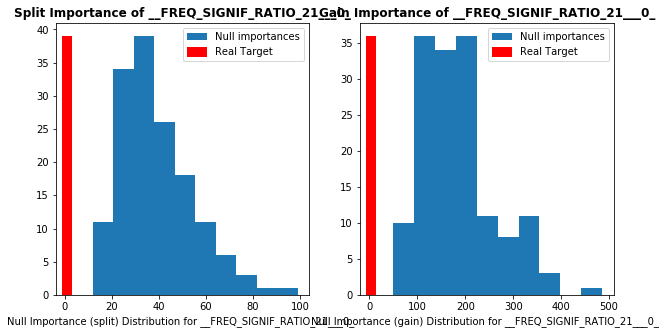

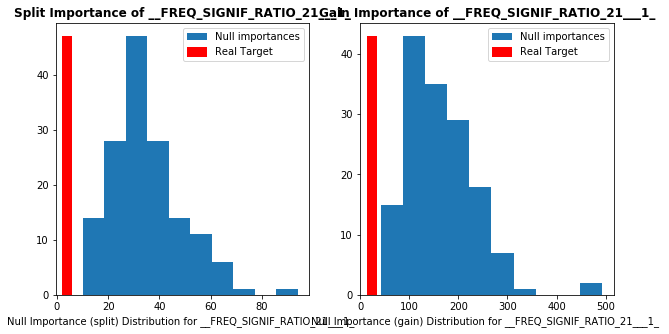

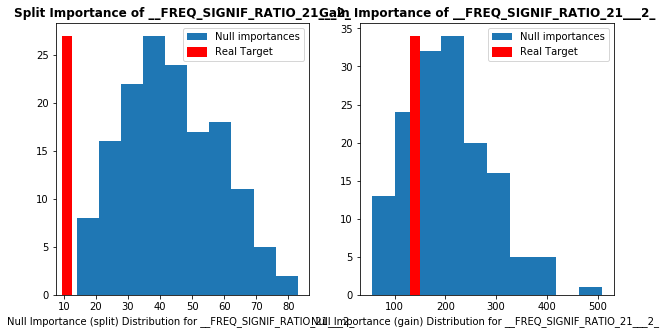

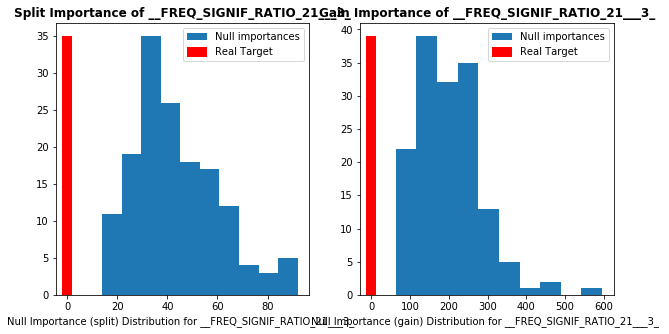

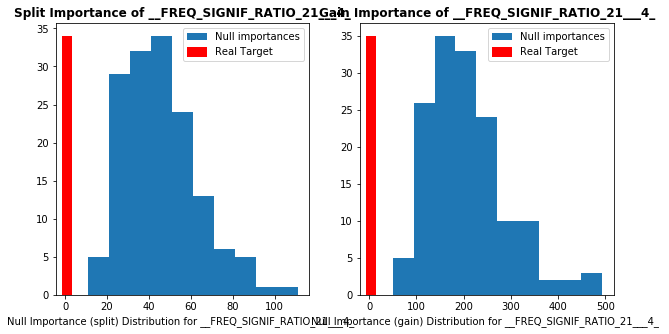

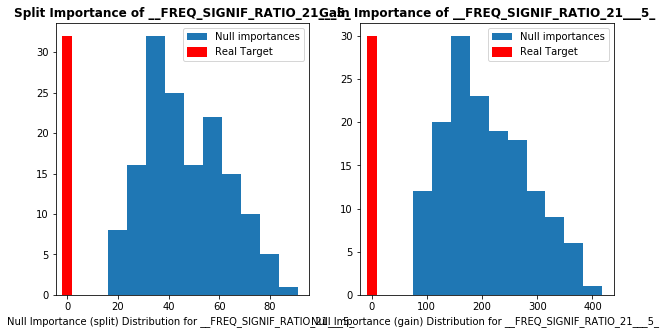

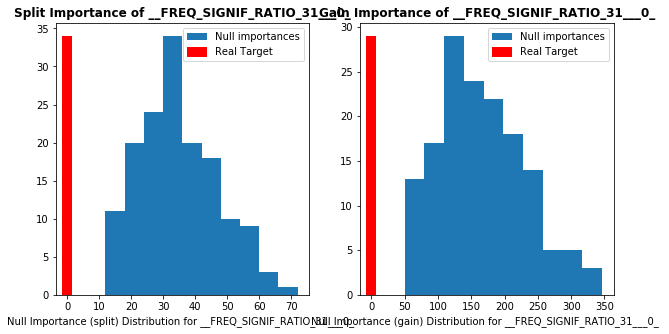

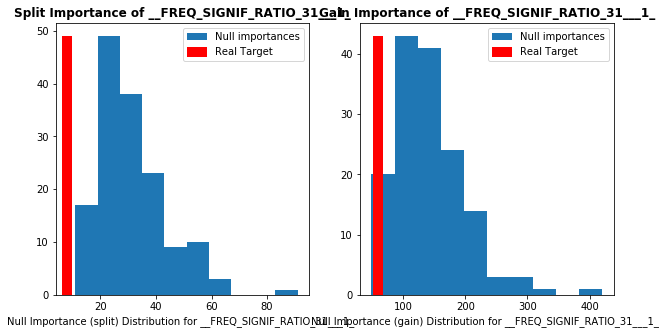

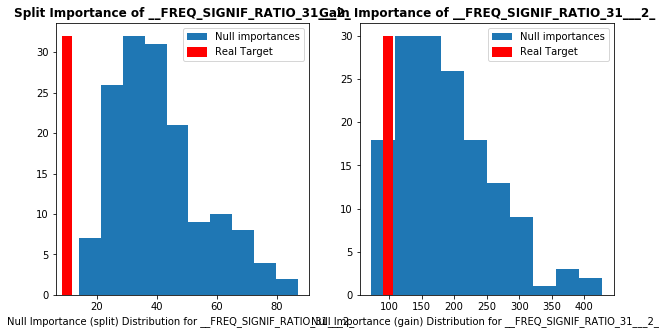

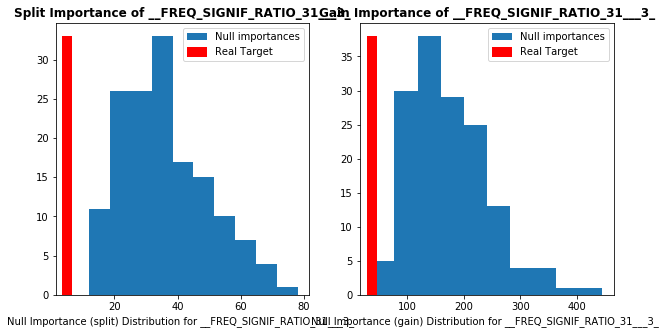

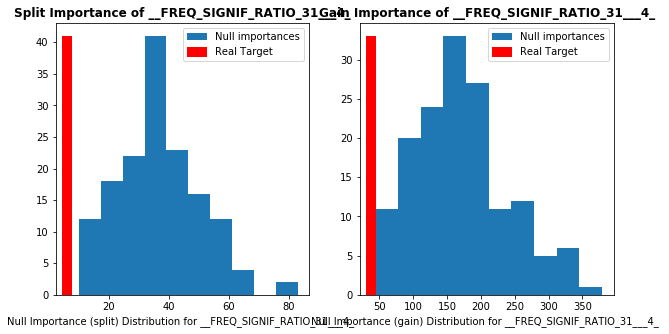

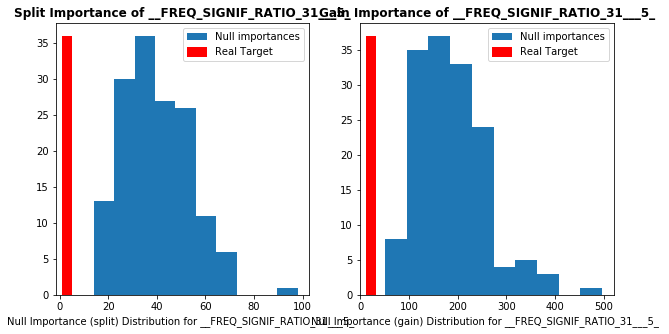

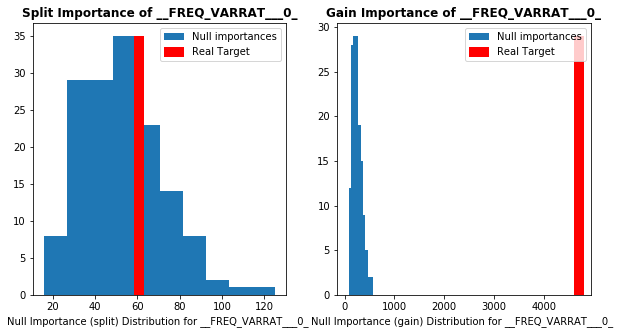

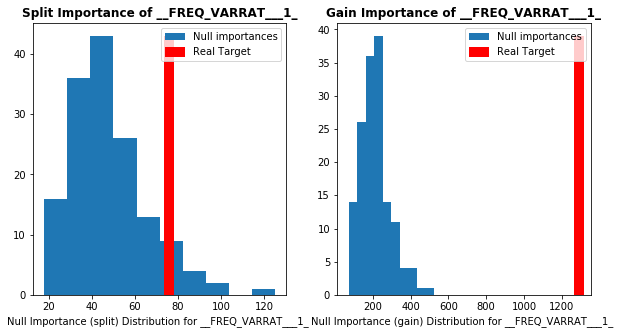

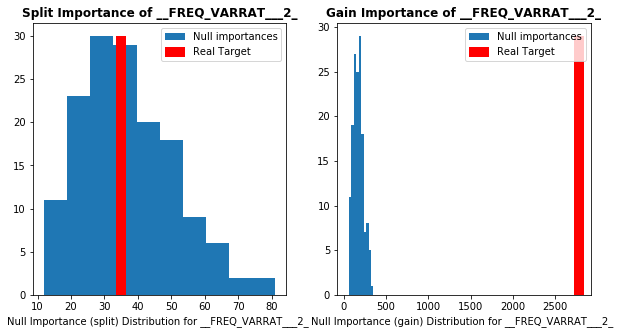

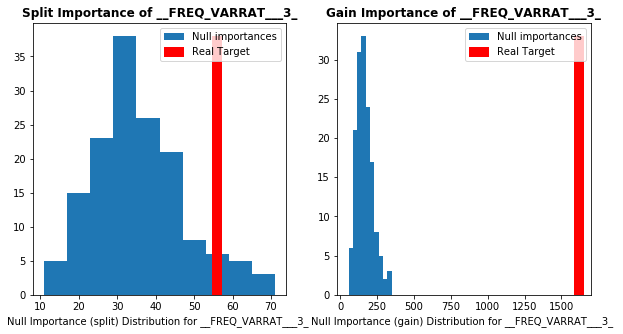

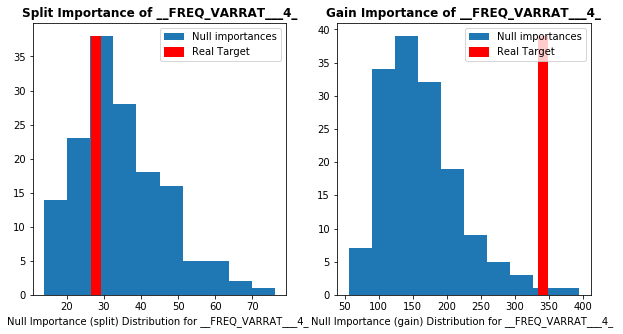

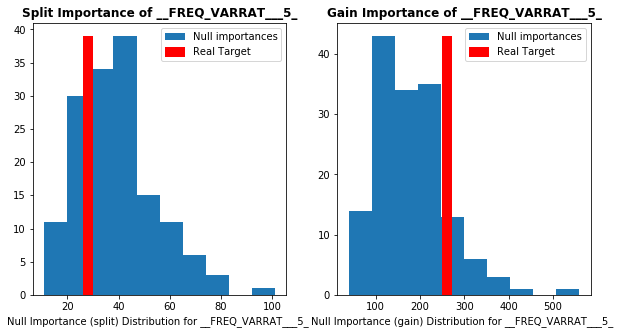

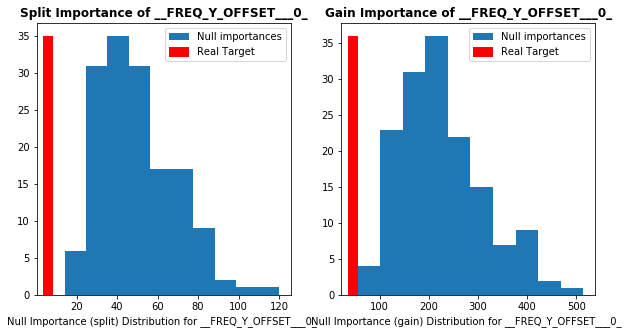

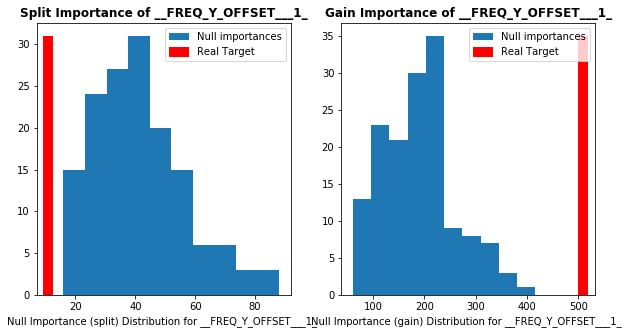

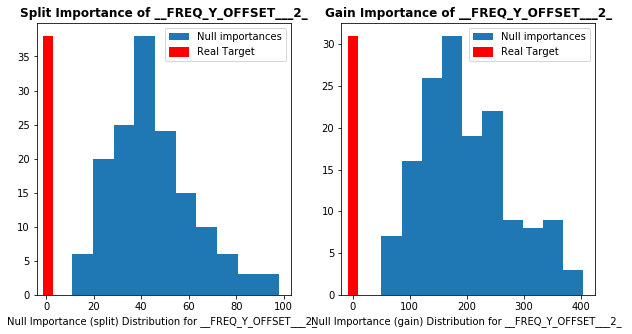

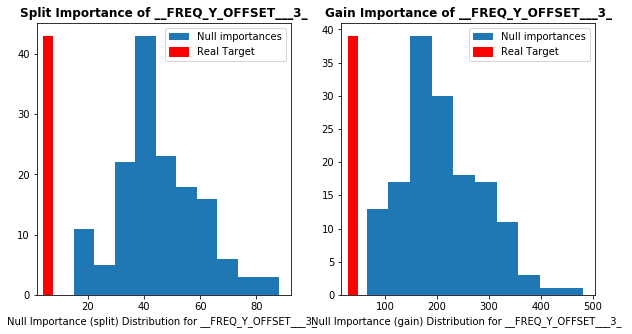

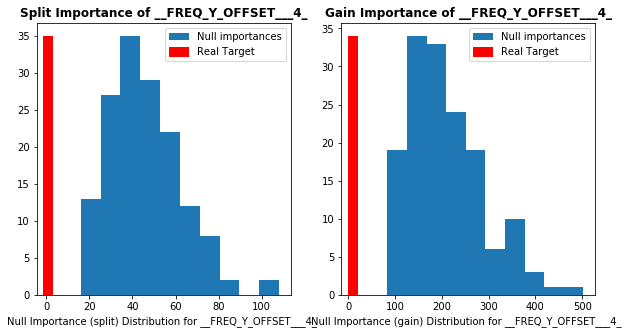

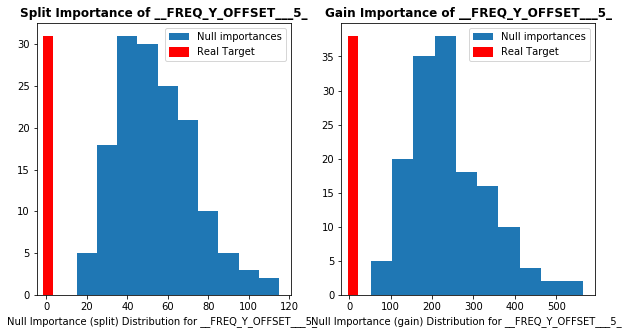

In [35]:
for i in [x for x in list(temp.columns.values) if x not in ['target', 'object_id'] ]:
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=i)

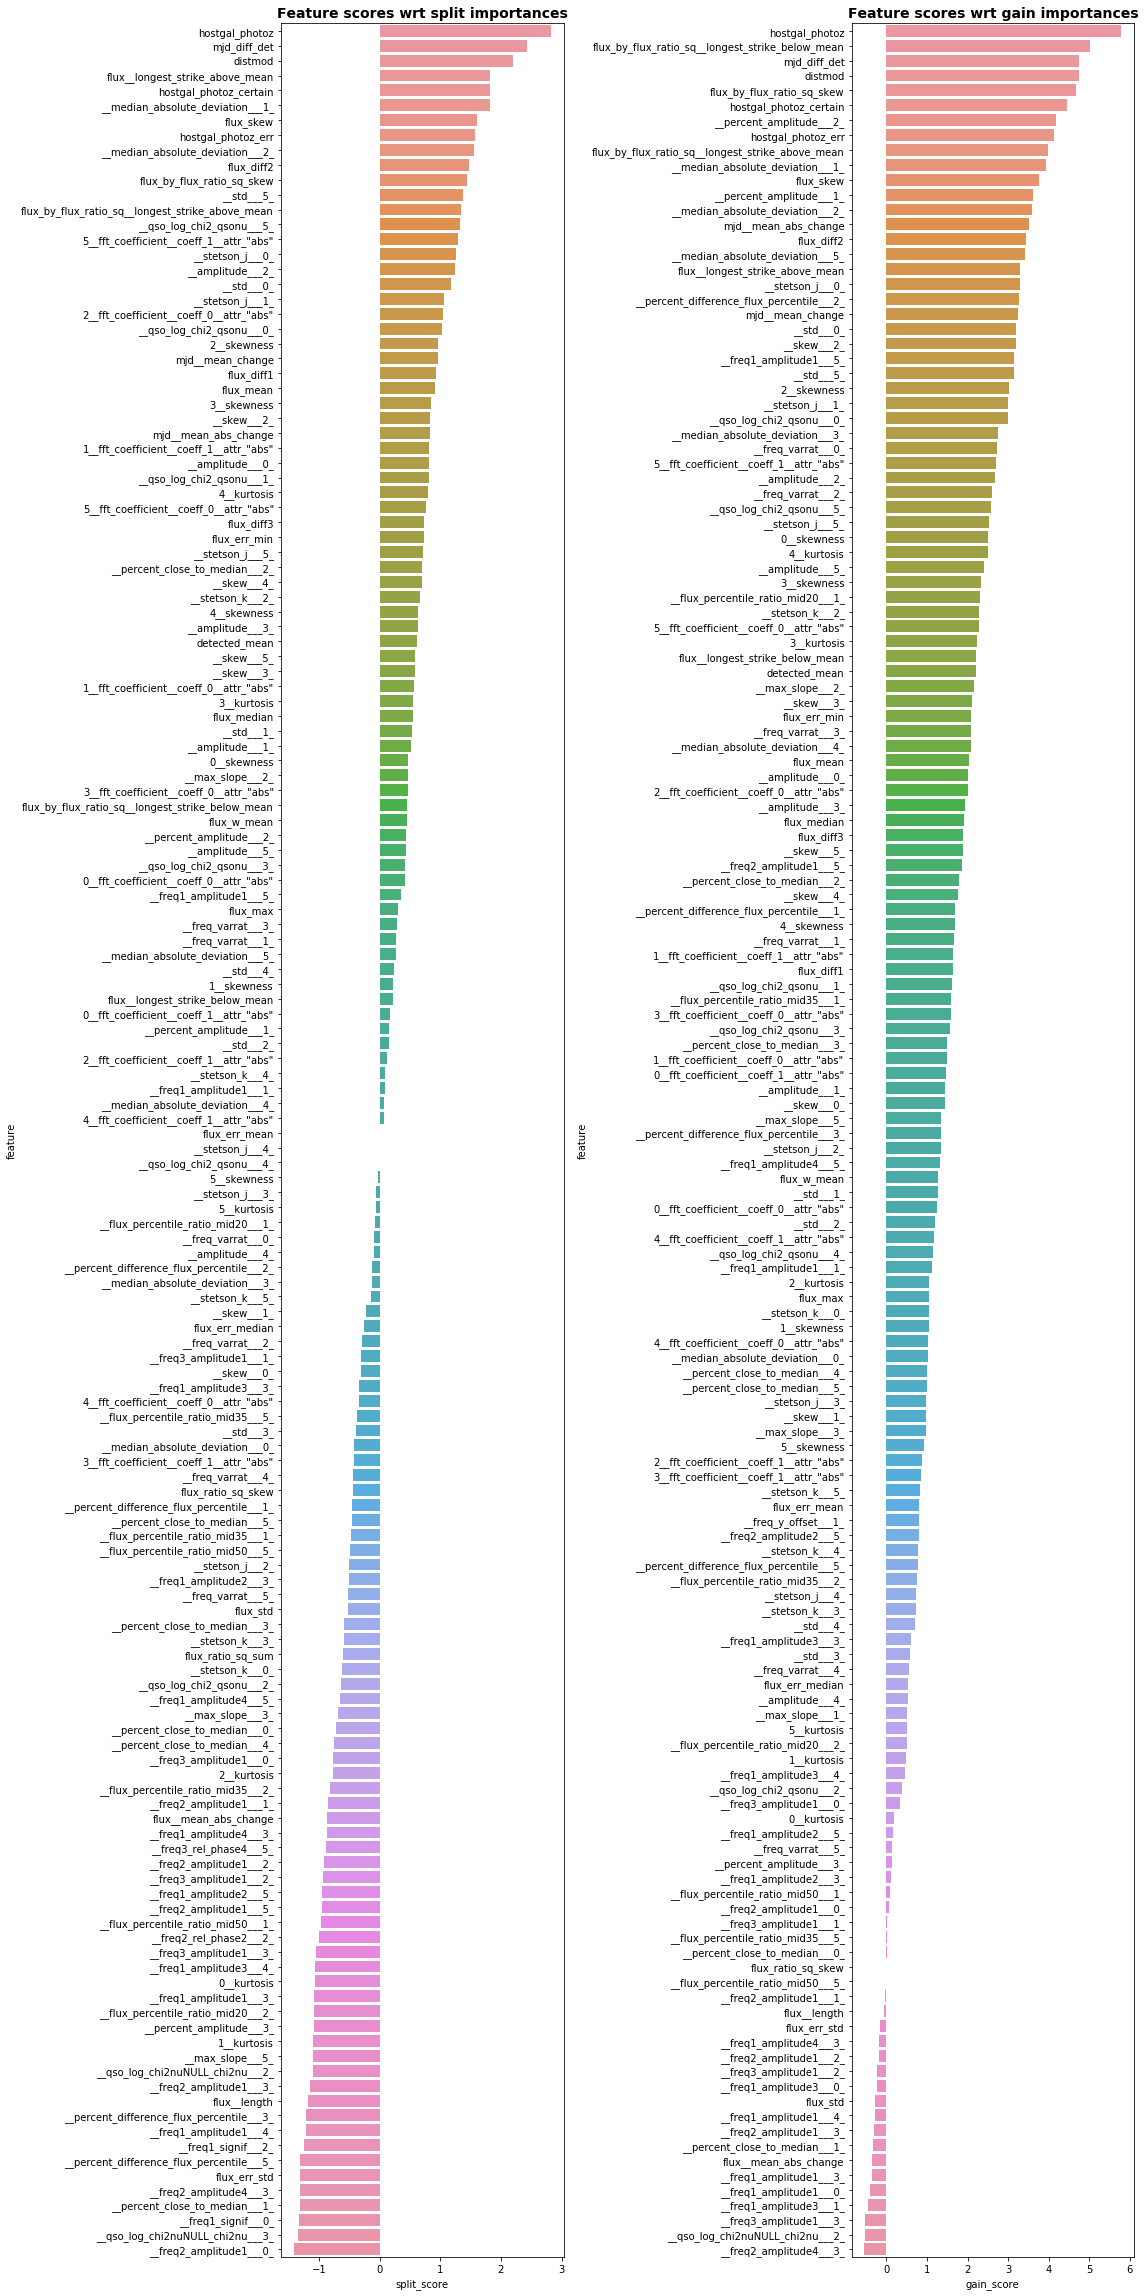

In [36]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:150], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:150], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

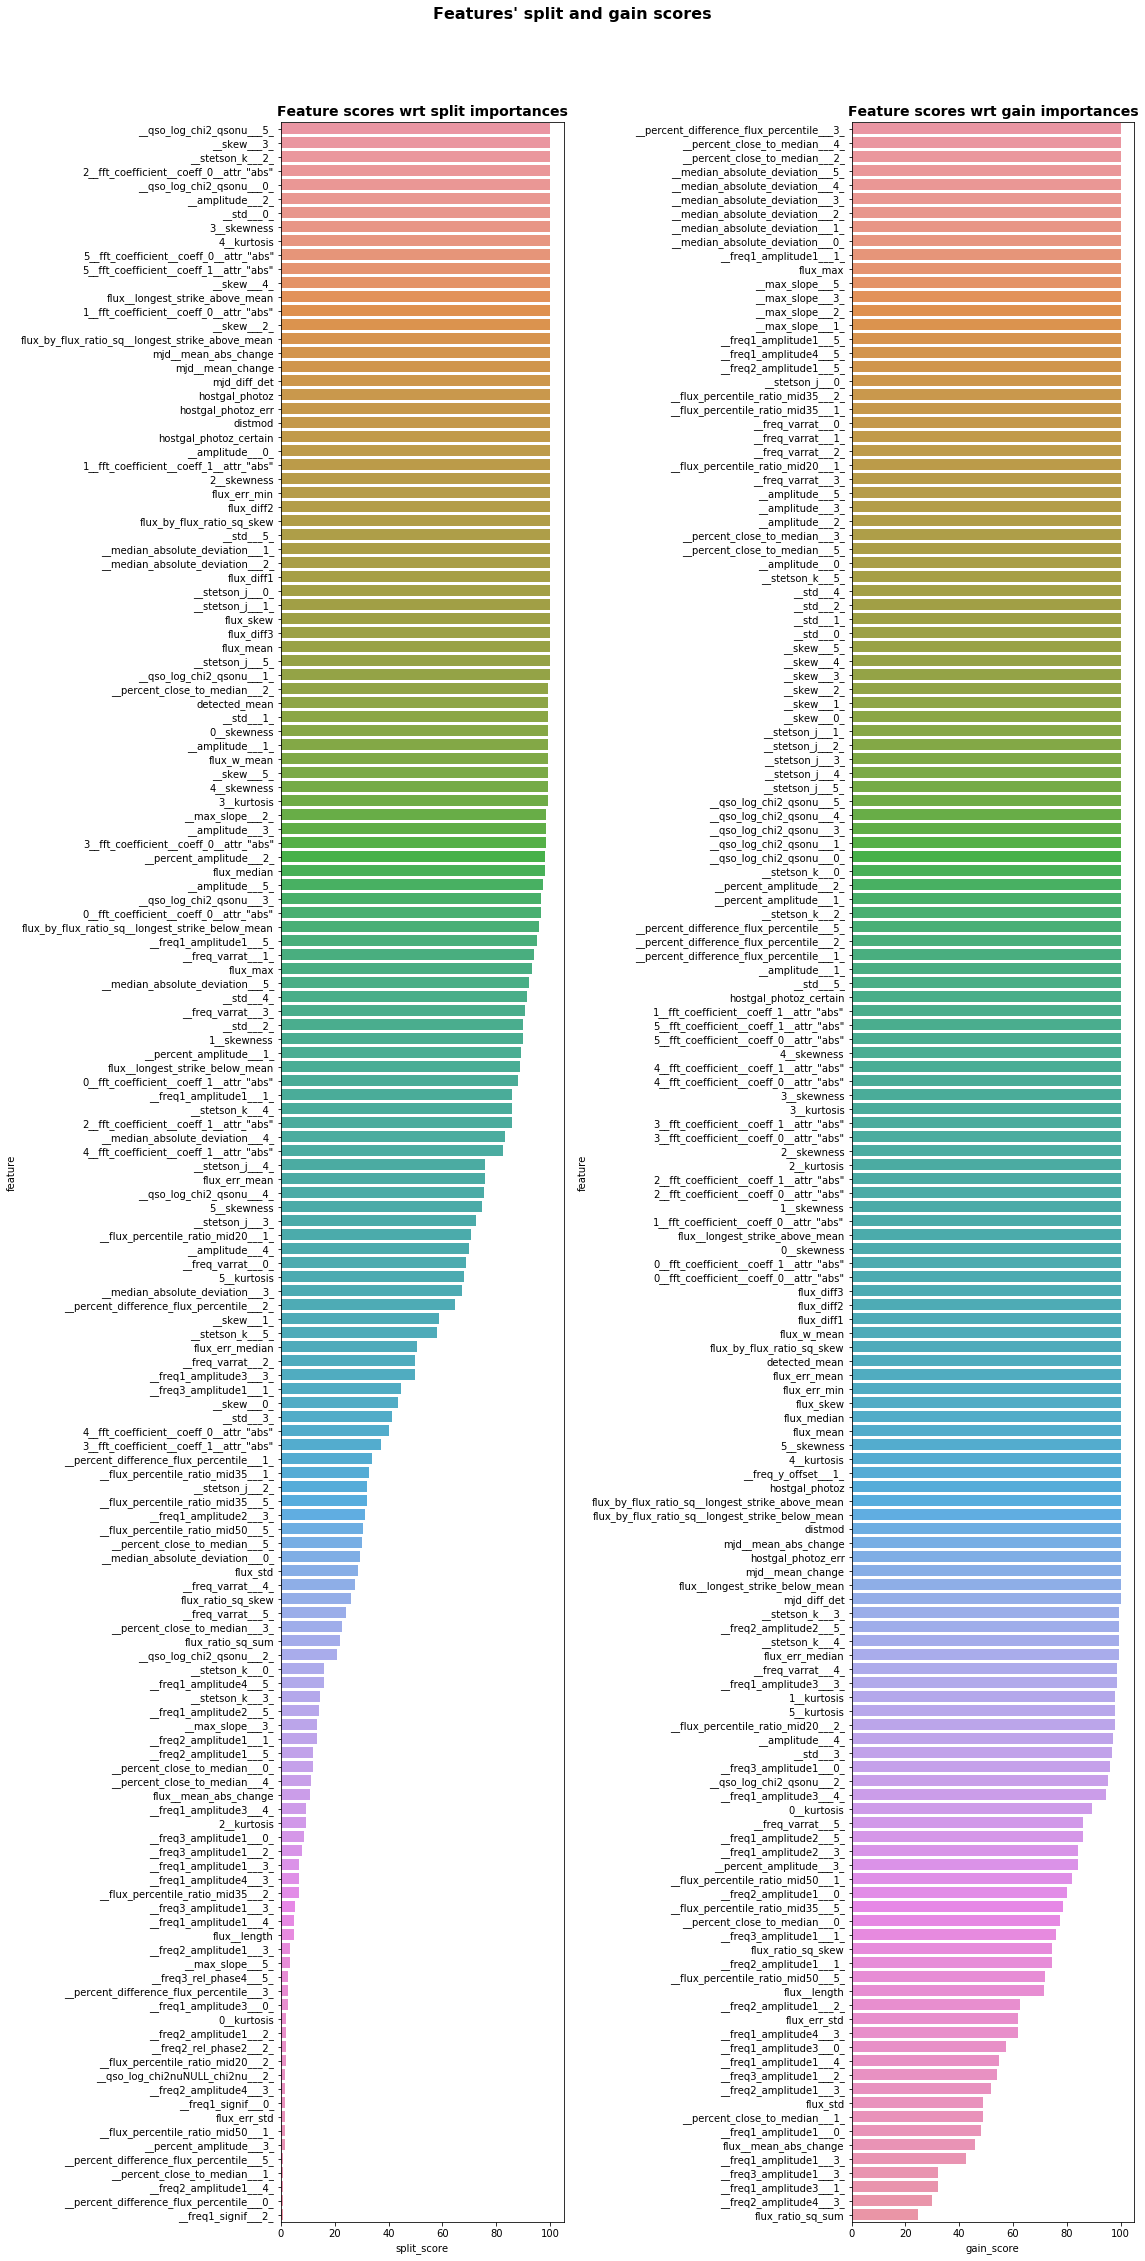

In [37]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:150], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:150], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [38]:
def score_feature_selection(df=None, train_features=None, target=None):
    
    # Fit LightGBM
    le = preprocessing.LabelEncoder()
    
    target, _ = pd.factorize(df['target'])
    
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 250, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['multi_logloss-mean'][-1], hist['multi_logloss-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=temp, train_features=split_feats, target=temp['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=temp, train_features=gain_feats, target=temp['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))


Results for threshold   0
	 SPLIT : 0.902820 +/- 0.008521
	 GAIN  : 0.902820 +/- 0.008521
Results for threshold  10
	 SPLIT : 0.897982 +/- 0.009994
	 GAIN  : 0.899314 +/- 0.008668
Results for threshold  20
	 SPLIT : 0.898708 +/- 0.009602
	 GAIN  : 0.898672 +/- 0.010578
Results for threshold  30
	 SPLIT : 0.896938 +/- 0.009751
	 GAIN  : 0.898095 +/- 0.009758
Results for threshold  40
	 SPLIT : 0.897976 +/- 0.010142
	 GAIN  : 0.898753 +/- 0.009384
Results for threshold  50
	 SPLIT : 0.897964 +/- 0.009448
	 GAIN  : 0.899619 +/- 0.009715
Results for threshold  60
	 SPLIT : 0.897146 +/- 0.011393
	 GAIN  : 0.899863 +/- 0.010051
Results for threshold  70
	 SPLIT : 0.897927 +/- 0.009876
	 GAIN  : 0.897976 +/- 0.009653
Results for threshold  80
	 SPLIT : 0.897879 +/- 0.010429
	 GAIN  : 0.899097 +/- 0.009943
Results for threshold  90
	 SPLIT : 0.899540 +/- 0.011545
	 GAIN  : 0.898647 +/- 0.009479
Results for threshold  95
	 SPLIT : 0.900804 +/- 0.011089
	 GAIN  : 0.898588 +/- 0.009535
Results fo

In [39]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')